In [243]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns
import ruptures as rpt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA as SKPCA



## Where to change the patient file path

In [314]:
sub = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_03_23_2023_LSTN_subject2\Processed DLC\csv folder')

## Functions

In [315]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

In [316]:
def hand_PS_mov(df, t):
    '''reports the peaks and the troughs'''

    start = t[0]
    stop = t[-1]

    fTip1 = df['fTip1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip1[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, 'NA'

In [317]:
def arm_EF_mov(df, t):
    '''reports the peaks and troughs'''

    fs = 100
    
    start = t[0]
    stop = t[-1]

    fTip1 = df['MCP1.1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip1[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, 'NA'



In [318]:

def hand_OC_mov(df, t):
    '''Reports the peaks and troughs from the Euclidean distance'''

    start = t[0]
    stop = t[-1]

    fTip2y = df['fTip2.1']


    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    y = fTip2y[start_idx:end_idx]
    t_np = np.arange(start_idx, end_idx)

    peaks, _ = find_peaks(y, height=30, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)
    troughs, _ = find_peaks(-y, height=None, threshold=None, distance=50, prominence=None, width=10, wlen=None, rel_height=0.5, plateau_size=None)

    # Filter out indices that are out of bounds
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, y

In [ ]:
def compute_peaks_troughs(row):
    base = row['dataset']  # like 'b1', 't2', etc.
    
    # Define both front and side keys
    dff = dataframes.get(base + 'f')
    dfs = dataframes.get(base + 's')

    if df is None:
        print(f"Warning: DataFrame for key '{base}' not found.")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])

    try:
        if row['movement'] == 'hand_OC':
            return pd.Series(hand_OC_mov(dfs, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'hand_PS':
            return pd.Series(hand_PS_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'arm_EF':
            return pd.Series(arm_EF_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        else:
            return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])


In [320]:
def run_PCA(X, indices, view, mov, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Takes into consideration if there are indices or not (helpful for when looking at specific movement)
    if indices is not None:
        X_subset = X.iloc[indices[0]:indices[1]+1]
    else:
        X_subset = X

    # 2. Drop columns containing '.2' --> dropping likelihood rows
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns --> gets rid of runs that were unsuccessful 
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data --> standardize mean to 0 and std to 1 (suggested from geeks for geeks)
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance = pca.explained_variance_
    pca_components = pca.components_ # direction (vectors) the define the PCs in the original feature space pca_components[0] are the scores in regards to PCA1



    return X_pca, explained_variance_ratio, explained_variance, pca_components


def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    Necessary because rows were set to 0 when filtering likelihood
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)

In [321]:
def average_close_indices(index_list, threshold=100):
    if not index_list:
        return []

    averaged = []
    current_group = [index_list[0]]

    for i in range(1, len(index_list)):
        if abs(index_list[i] - sum(current_group)/len(current_group)) <= threshold:
            current_group.append(index_list[i])
        else:
            # Commit the average of the current group
            averaged.append(int(sum(current_group)/len(current_group)))
            # Start new group
            current_group = [index_list[i]]

    # Don't forget the last group
    averaged.append(int(sum(current_group)/len(current_group)))
    return averaged


## Creates dataframes for each depth

In [322]:
# list of all the videos for subject 
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2f', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(sub.iterdir())

# First, filter out the LC2 files from sub directory
valid_files = [file for file in sub.iterdir() if 'LC2' not in file.name]

# Now zip with dbs_loc
for file, label in zip(valid_files, dbs_loc):
    if not label:
        continue  # Skip if label is None, empty string, etc.

    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")



     bodyparts StablePoint StablePoint.1 StablePoint.2   PalmBase PalmBase.1  \
0       coords           x             y    likelihood          x          y   
1            0   312.37256     90.169426     0.9454463  267.89175  287.26443   
2            1    312.2302      90.40724     0.9373964  265.75037  284.86755   
3            2   312.24457      90.30127    0.93601197  265.21674   284.9264   
4            3   311.87827      90.29879     0.9441474  265.31732   286.3712   
...        ...         ...           ...           ...        ...        ...   
1327      1326   312.79306      90.74159     0.9609104   294.0356  367.53326   
1328      1327    312.6162      91.11673    0.96110815  293.51898   368.3171   
1329      1328   312.80075      90.77604     0.9515535   293.1958  368.65656   
1330      1329   312.35977      90.99973     0.9514125  293.29675   368.7996   
1331      1330   312.43835     90.826546     0.9502585  293.31845  368.52686   

      PalmBase.2       MCP1     MCP1.1 

## Creates df for PC1 and PC2 for top 5 features

In [328]:
# creates empty lists for all view scores and one for only the PCA1 scores
rows_front = []
rows_side = []
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []

# iterates over each view and depth (b1s, b1f, b2s......)
# creates new df (pca1_df) with all the scores from PC1 in regards to each movement
for i in dataframes:
    base = i    # like 'b1f', 't2s'
    mov = 'all'  # looking at full video, not yet sectioning out the movements
    df = dataframes[base]  # setting df to qual the data from b1f for example

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()



    print(f' For {base} the variance for PC1 is {explained_variance_ratio[0]} and PC2 is {explained_variance_ratio[1]}')

    #Storing each into a new dataframe to later pull from 
    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create a dict for this depth/view row (PC1)
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }

    # Create a dict for PC2
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }


    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append both rows
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })


    # Create list of (feature, weight) for PC1
    feature_contributions = list(zip(final_cols, pc1))

    # Sort by absolute contribution descending
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

    # Take top 5 contributors
    top5 = feature_contributions[:5]

    # Save top 5 contributors for PC1
    top5_dict = {
        "depth": depth,
        "view": view_type
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_dict)

    # At the end of the loop (outside the for i in dataframes loop), convert lists to DataFrames:
    pca1_df = pd.DataFrame(pca1_rows)
    pca2_df = pd.DataFrame(pca2_rows)
    explained_df = pd.DataFrame(explained_var_rows)
    top5_df = pd.DataFrame(top5_pc1_rows)


top5_df

 For b1f the variance for PC1 is 0.4677905808992578 and PC2 is 0.32938786613912907
 For b1s the variance for PC1 is 0.5357547137482518 and PC2 is 0.34507681255901573
 For b2f the variance for PC1 is 0.5425782753439766 and PC2 is 0.19466294977005266
 For b2s the variance for PC1 is 0.45664887201924204 and PC2 is 0.4207500179125021
 For b3f the variance for PC1 is 0.4582204508156575 and PC2 is 0.28808398153610515
 For b3s the variance for PC1 is 0.47534049753411284 and PC2 is 0.3761800311502542
 For c1f the variance for PC1 is 0.47386366003091873 and PC2 is 0.2527213371776943
 For c1s the variance for PC1 is 0.4620903383508275 and PC2 is 0.3767667690403866
 For c2f the variance for PC1 is 0.5669285215625827 and PC2 is 0.21613538587634434
 For c2s the variance for PC1 is 0.5439582743404607 and PC2 is 0.3244499277010602
 For c3f the variance for PC1 is 0.5080678182015375 and PC2 is 0.24147605300053915
 For c3s the variance for PC1 is 0.5615199747182029 and PC2 is 0.3199167160641154
 For t1

depth   view   feature_1  weight_1 feature_2  weight_2 feature_3  weight_3  \
0     b1  front       fTip3  0.240434   Elbow.1  0.239025     fTip4  0.235319   
1     b1   side        MCP3  0.249545      MCP2  0.249181      MCP4  0.248655   
2     b2  front      MCP2.1  0.239753   fTip2.1  0.236234    MCP3.1  0.232070   
3     b2   side        MCP5  0.264611      MCP4  0.264560      MCP3  0.263513   
4     b3  front      MCP2.1  0.245700   fTip2.1  0.240437   fTip1.1  0.238150   
5     b3   side        MCP3  0.273454      MCP4  0.272974      MCP2  0.272870   
6     c1  front  PalmBase.1  0.274866    MCP4.1  0.251102  PalmBase -0.247674   
7     c1   side        MCP1  0.243886     fTip1  0.243171      MCP2  0.239341   
8     c2  front      MCP1.1  0.236851    MCP2.1  0.231860   fTip4.1  0.229896   
9     c2   side      MCP5.1  0.226989   fTip5.1  0.226067      MCP5  0.218080   
10    c3  front      MCP1.1  0.241796   fTip3.1  0.239253    MCP2.1  0.236303   
11    c3   side     fTip5.1  0.226871    MCP5.1  0.226229    MCP4.1  0.215181   
12    t1  front       fTip3  0.219869     fTip2  0.219538    MCP2.1  0.218285   
13    t1   side     fTip4.1  0.220529      MCP5  0.220500      MCP4  0.217495   
14    t2  front      MCP2.1  0.237157     fTip1  0.234748      MCP2  0.233601   
15    t2   side        MCP3  0.223852      MCP4  0.223399      MCP2  0.223162   
16    t3  front       fTip2  0.237420     fTip3  0.235256     fTip4  0.234369   
17    t3   side     fTip5.1  0.244633      MCP5  0.233292   fTip4.1  0.232408   

   feature_4  weight_4     feature_5  weight_5  
0      fTip2  0.233802         fTip5  0.224488  
1       MCP5  0.247720      PalmBase  0.245167  
2    fTip1.1  0.229204  MidForeArm.1  0.226123  
3       MCP2  0.261108         fTip5  0.258142  
4      fTip3  0.236202        MCP1.1  0.233373  
5      fTip3  0.272103          MCP5  0.271784  
6       MCP4 -0.236199        MCP3.1  0.236027  
7      fTip2  0.237263          MCP3  0.233320  
8     MCP3.1  0.226722       fTip3.1  0.225958  
9       MCP4  0.217452        MCP4.1  0.217401  
10   fTip4.1  0.232279        MCP3.1  0.229135  
11   fTip4.1  0.214777          MCP5  0.210909  
12     fTip4  0.217759        MCP3.1  0.217677  
13    MCP5.1  0.216928          MCP3  0.214078  
14    MCP3.1  0.232699          MCP3  0.232375  
15      MCP5  0.223078    MidForeArm  0.221850  
16      MCP5  0.234289          MCP4  0.233987  
17     fTip5  0.232380        MCP5.1  0.232102

## Outputs the explained variance for PC1 and PC2

In [324]:
# Initialize empty lists before loop
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []
top5_pc2_rows = []

for base in dataframes:
    mov = 'all'  # example movement label
    df = dataframes[base]

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None, base, mov)

    print(f'For {base} the variance for PC1 is {explained_variance_ratio[0]:.4f} and PC2 is {explained_variance_ratio[1]:.4f}')

    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create dicts for PC1 and PC2 rows
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }

    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append rows to respective lists
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    # Save explained variance for PC1 and PC2
    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })

    # Top 5 contributors for PC1
    feature_contributions_pc1 = list(zip(final_cols, pc1))
    feature_contributions_pc1.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc1 = feature_contributions_pc1[:5]

    top5_pc1_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5_pc1):
        top5_pc1_dict[f"feature_{idx+1}"] = feat
        top5_pc1_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_pc1_dict)

    # Top 5 contributors for PC2
    feature_contributions_pc2 = list(zip(final_cols, pc2))
    feature_contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = feature_contributions_pc2[:5]

    top5_pc2_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_pc2_dict[f"feature_{idx+1}"] = feat
        top5_pc2_dict[f"weight_{idx+1}"] = weight
    top5_pc2_rows.append(top5_pc2_dict)

# Create DataFrames after loop
pca1_df = pd.DataFrame(pca1_rows)
pca2_df = pd.DataFrame(pca2_rows)
explained_df = pd.DataFrame(explained_var_rows)
top5_pc1_df = pd.DataFrame(top5_pc1_rows)
top5_pc2_df = pd.DataFrame(top5_pc2_rows)

print(top5_pc1_df)
print(top5_pc2_df)


For b1f the variance for PC1 is 0.4678 and PC2 is 0.3294
For b1s the variance for PC1 is 0.5358 and PC2 is 0.3451
For b2f the variance for PC1 is 0.5426 and PC2 is 0.1947
For b2s the variance for PC1 is 0.4566 and PC2 is 0.4208
For b3f the variance for PC1 is 0.4582 and PC2 is 0.2881
For b3s the variance for PC1 is 0.4753 and PC2 is 0.3762
For c1f the variance for PC1 is 0.4739 and PC2 is 0.2527
For c1s the variance for PC1 is 0.4621 and PC2 is 0.3768
For c2f the variance for PC1 is 0.5669 and PC2 is 0.2161
For c2s the variance for PC1 is 0.5440 and PC2 is 0.3244
For c3f the variance for PC1 is 0.5081 and PC2 is 0.2415
For c3s the variance for PC1 is 0.5615 and PC2 is 0.3199
For t1f the variance for PC1 is 0.7115 and PC2 is 0.1000
For t1s the variance for PC1 is 0.5853 and PC2 is 0.2542
For t2f the variance for PC1 is 0.5471 and PC2 is 0.1888
For t2s the variance for PC1 is 0.5390 and PC2 is 0.3010
For t3f the variance for PC1 is 0.5325 and PC2 is 0.1649
For t3s the variance for PC1 is

In [338]:
top5_pc1_df

depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
0     b1  front       PC1       fTip3  0.240434   Elbow.1  0.239025     fTip4   
1     b1   side       PC1        MCP3  0.249545      MCP2  0.249181      MCP4   
2     b2  front       PC1      MCP2.1  0.239753   fTip2.1  0.236234    MCP3.1   
3     b2   side       PC1        MCP5  0.264611      MCP4  0.264560      MCP3   
4     b3  front       PC1      MCP2.1  0.245700   fTip2.1  0.240437   fTip1.1   
5     b3   side       PC1        MCP3  0.273454      MCP4  0.272974      MCP2   
6     c1  front       PC1  PalmBase.1  0.274866    MCP4.1  0.251102  PalmBase   
7     c1   side       PC1        MCP1  0.243886     fTip1  0.243171      MCP2   
8     c2  front       PC1      MCP1.1  0.236851    MCP2.1  0.231860   fTip4.1   
9     c2   side       PC1      MCP5.1  0.226989   fTip5.1  0.226067      MCP5   
10    c3  front       PC1      MCP1.1  0.241796   fTip3.1  0.239253    MCP2.1   
11    c3   side       PC1     fTip5.1  0.226871    MCP5.1  0.226229    MCP4.1   
12    t1  front       PC1       fTip3  0.219869     fTip2  0.219538    MCP2.1   
13    t1   side       PC1     fTip4.1  0.220529      MCP5  0.220500      MCP4   
14    t2  front       PC1      MCP2.1  0.237157     fTip1  0.234748      MCP2   
15    t2   side       PC1        MCP3  0.223852      MCP4  0.223399      MCP2   
16    t3  front       PC1       fTip2  0.237420     fTip3  0.235256     fTip4   
17    t3   side       PC1     fTip5.1  0.244633      MCP5  0.233292   fTip4.1   

    weight_3 feature_4  weight_4     feature_5  weight_5  
0   0.235319     fTip2  0.233802         fTip5  0.224488  
1   0.248655      MCP5  0.247720      PalmBase  0.245167  
2   0.232070   fTip1.1  0.229204  MidForeArm.1  0.226123  
3   0.263513      MCP2  0.261108         fTip5  0.258142  
4   0.238150     fTip3  0.236202        MCP1.1  0.233373  
5   0.272870     fTip3  0.272103          MCP5  0.271784  
6  -0.247674      MCP4 -0.236199        MCP3.1  0.236027  
7   0.239341     fTip2  0.237263          MCP3  0.233320  
8   0.229896    MCP3.1  0.226722       fTip3.1  0.225958  
9   0.218080      MCP4  0.217452        MCP4.1  0.217401  
10  0.236303   fTip4.1  0.232279        MCP3.1  0.229135  
11  0.215181   fTip4.1  0.214777          MCP5  0.210909  
12  0.218285     fTip4  0.217759        MCP3.1  0.217677  
13  0.217495    MCP5.1  0.216928          MCP3  0.214078  
14  0.233601    MCP3.1  0.232699          MCP3  0.232375  
15  0.223162      MCP5  0.223078    MidForeArm  0.221850  
16  0.234369      MCP5  0.234289          MCP4  0.233987  
17  0.232408     fTip5  0.232380        MCP5.1  0.232102

## Creates 3D graphs of PC1 and PC2 against time with change points shown


Processing depth=b1, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC1     fTip3  0.240434   Elbow.1  0.239025     fTip4   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0  0.235319     fTip2  0.233802     fTip5  0.224488  
  depth   view component feature_1  weight_1 feature_2  weight_2   feature_3  \
0    b1  front       PC2    MCP5.1  0.290214   fTip5.1  0.279951  PalmBase.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0  0.272104    MCP4.1  0.266104   fTip4.1  0.249886  
MCP5.1


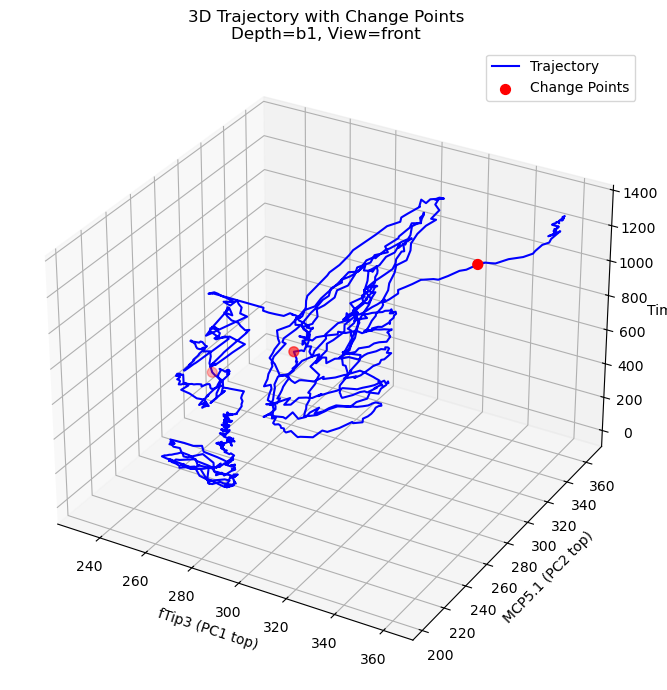

Change points (frame indices) for b1 front: [475, 715, 1265, 1331]

Processing depth=b1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
1    b1  side       PC1      MCP3  0.249545      MCP2  0.249181      MCP4   

   weight_3 feature_4  weight_4 feature_5  weight_5  
1  0.248655      MCP5   0.24772  PalmBase  0.245167  
  depth  view component feature_1  weight_1   feature_2  weight_2  \
1    b1  side       PC2    MCP2.1    0.3067  PalmBase.1  0.290676   

      feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
1  MidForeArm.1   0.28317    MCP3.1  0.281433   fTip2.1  0.265973  
MCP2.1


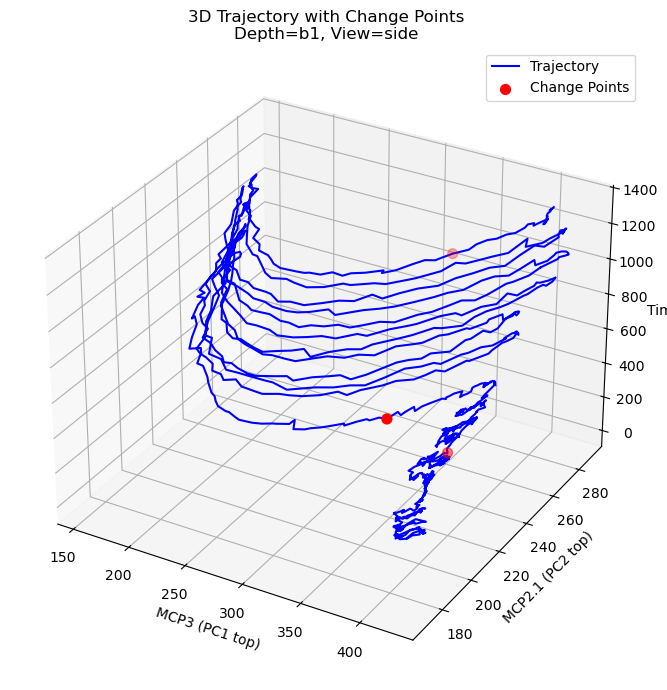

Change points (frame indices) for b1 side: [480, 720, 1265, 1317]

Processing depth=b2, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC1    MCP2.1  0.239753   fTip2.1  0.236234    MCP3.1   

   weight_3 feature_4  weight_4     feature_5  weight_5  
2   0.23207   fTip1.1  0.229204  MidForeArm.1  0.226123  
  depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC2  MidForeArm  0.317838  PalmBase  0.307578     fTip3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
2  0.272293      MCP1   0.25093      MCP4  0.246726  
MidForeArm


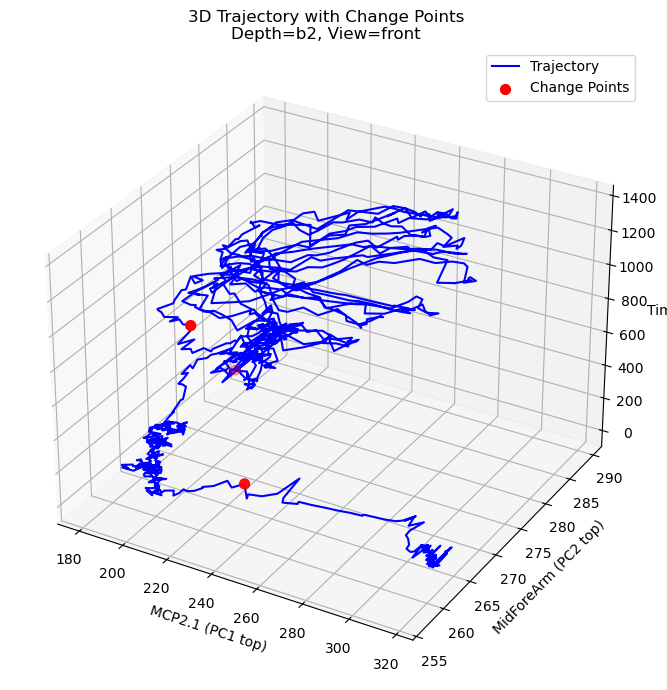

Change points (frame indices) for b2 front: [140, 560, 845, 1361]

Processing depth=b2, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
3    b2  side       PC1      MCP5  0.264611      MCP4   0.26456      MCP3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
3  0.263513      MCP2  0.261108     fTip5  0.258142  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
3    b2  side       PC2    MCP2.1  0.278243   fTip1.1  0.264611    MCP1.1   

   weight_3   feature_4  weight_4 feature_5  weight_5  
3  0.262902  PalmBase.1   0.26195   fTip2.1  0.260741  
MCP2.1


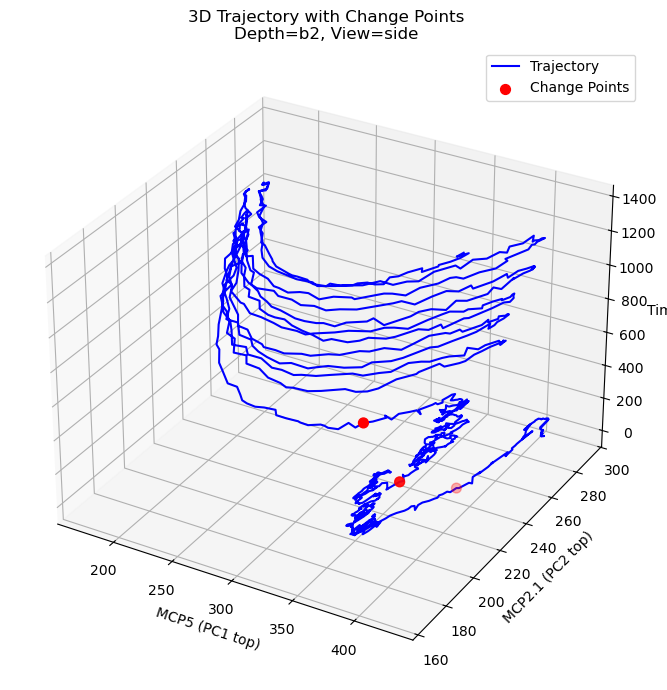

Change points (frame indices) for b2 side: [130, 540, 845, 1364]

Processing depth=b3, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
4    b3  front       PC1    MCP2.1    0.2457   fTip2.1  0.240437   fTip1.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
4   0.23815     fTip3  0.236202    MCP1.1  0.233373  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
4    b3  front       PC2   fTip5.1  0.263728  PalmBase -0.256332      MCP3   

   weight_3   feature_4  weight_4 feature_5  weight_5  
4 -0.255069  PalmBase.1  0.252786    MCP5.1  0.250988  
fTip5.1


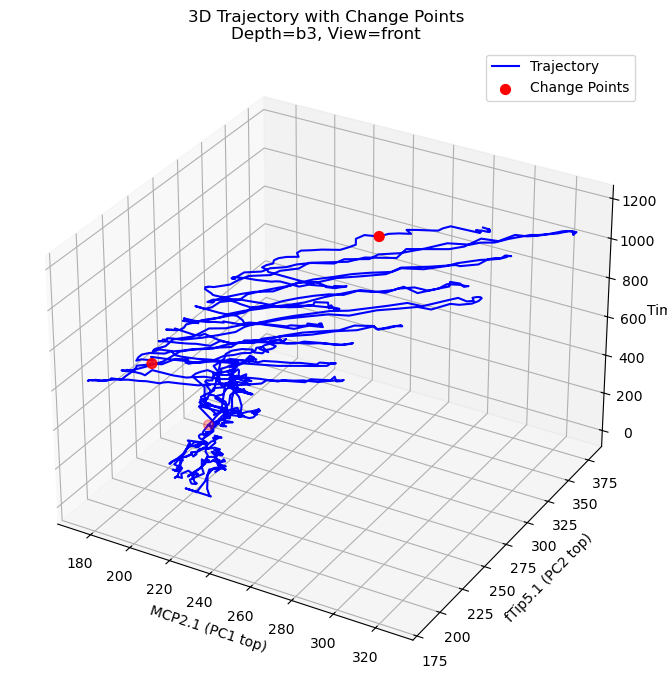

Change points (frame indices) for b3 front: [230, 615, 1135, 1181]

Processing depth=b3, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
5    b3  side       PC1      MCP3  0.273454      MCP4  0.272974      MCP2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
5   0.27287     fTip3  0.272103      MCP5  0.271784  
  depth  view component feature_1  weight_1   feature_2  weight_2 feature_3  \
5    b3  side       PC2    MCP3.1  0.301237  PalmBase.1  0.299209    MCP2.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
5  0.298406    MCP4.1  0.290691    MCP1.1  0.283659  
MCP3.1


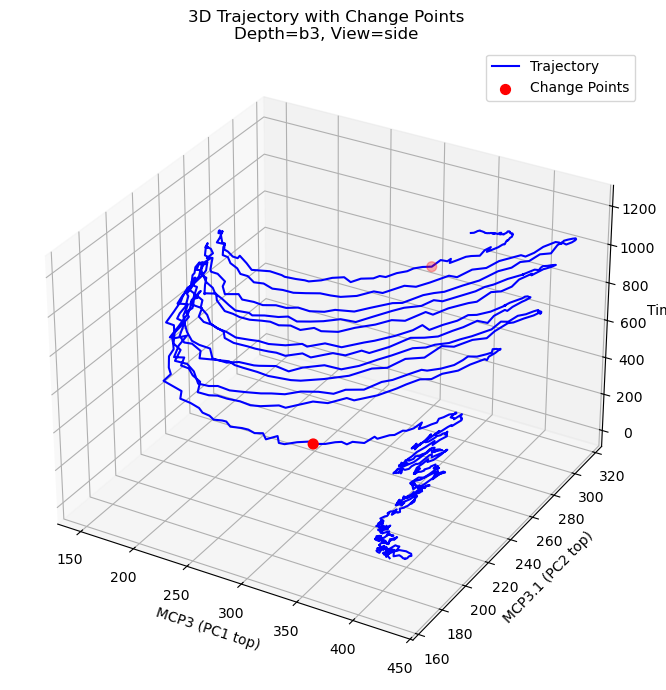

Change points (frame indices) for b3 side: [620, 1135, 1220]

Processing depth=c1, view=front
  depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
6    c1  front       PC1  PalmBase.1  0.274866    MCP4.1  0.251102  PalmBase   

   weight_3 feature_4  weight_4 feature_5  weight_5  
6 -0.247674      MCP4 -0.236199    MCP3.1  0.236027  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
6    c1  front       PC2     fTip2  0.289214   fTip1.1  0.265864   fTip2.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
6  0.258559     fTip4  0.256996   fTip3.1  0.250977  
fTip2


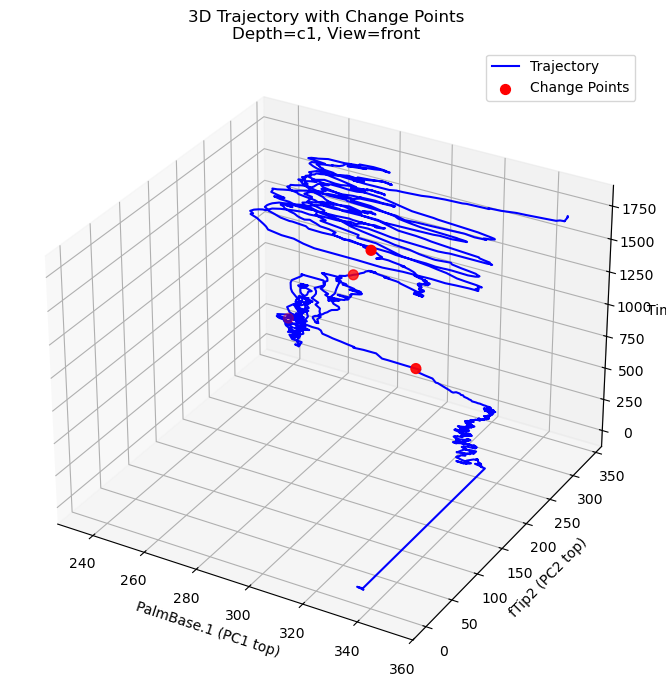

Change points (frame indices) for c1 front: [475, 625, 1000, 1195, 1777]

Processing depth=c1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
7    c1  side       PC1      MCP1  0.243886     fTip1  0.243171      MCP2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.239341     fTip2  0.237263      MCP3   0.23332  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
7    c1  side       PC2    MCP2.1  0.277671   Elbow.1  0.255588   fTip1.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.250201   fTip2.1  0.247285    MCP3.1  0.243925  
MCP2.1


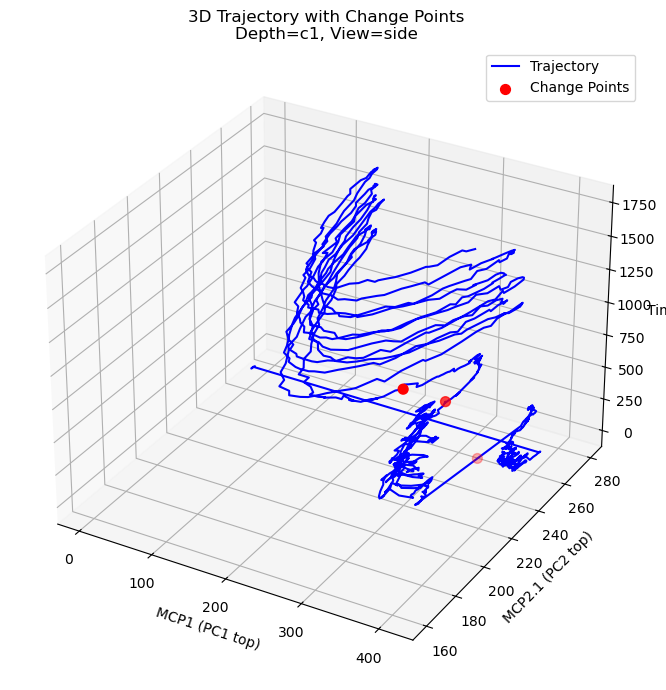

Change points (frame indices) for c1 side: [495, 1015, 1200, 1751]

Processing depth=c2, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
8    c2  front       PC1    MCP1.1  0.236851    MCP2.1   0.23186   fTip4.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
8  0.229896    MCP3.1  0.226722   fTip3.1  0.225958  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
8    c2  front       PC2  PalmBase  0.311604      MCP3     0.285      MCP4   

   weight_3 feature_4  weight_4 feature_5  weight_5  
8  0.282223      MCP1  0.280202      MCP2  0.262377  
PalmBase


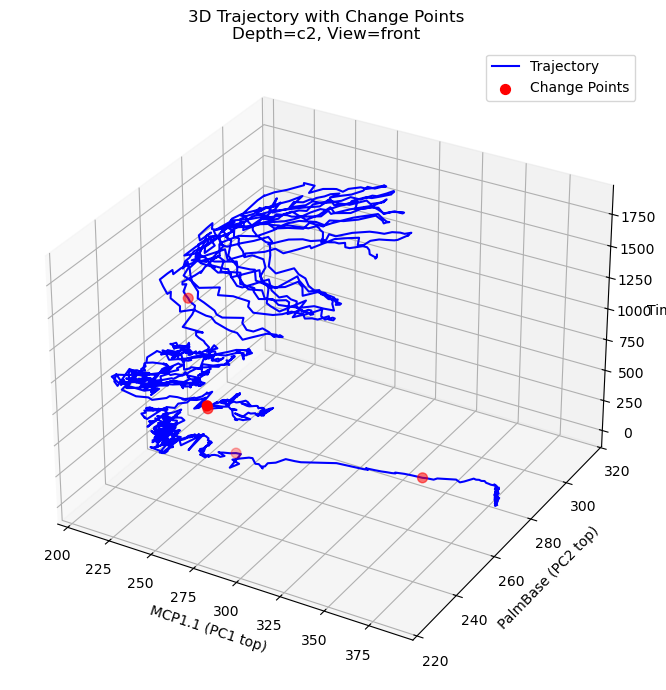

Change points (frame indices) for c2 front: [190, 235, 645, 800, 1260, 1842]

Processing depth=c2, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
9    c2  side       PC1    MCP5.1  0.226989   fTip5.1  0.226067      MCP5   

   weight_3 feature_4  weight_4 feature_5  weight_5  
9   0.21808      MCP4  0.217452    MCP4.1  0.217401  
  depth  view component feature_1  weight_1 feature_2  weight_2  \
9    c2  side       PC2     fTip1  0.271649   Elbow.1 -0.264416   

       feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
9  StablePoint.1  0.250331    MCP2.1 -0.224037      MCP1  0.209087  
fTip1


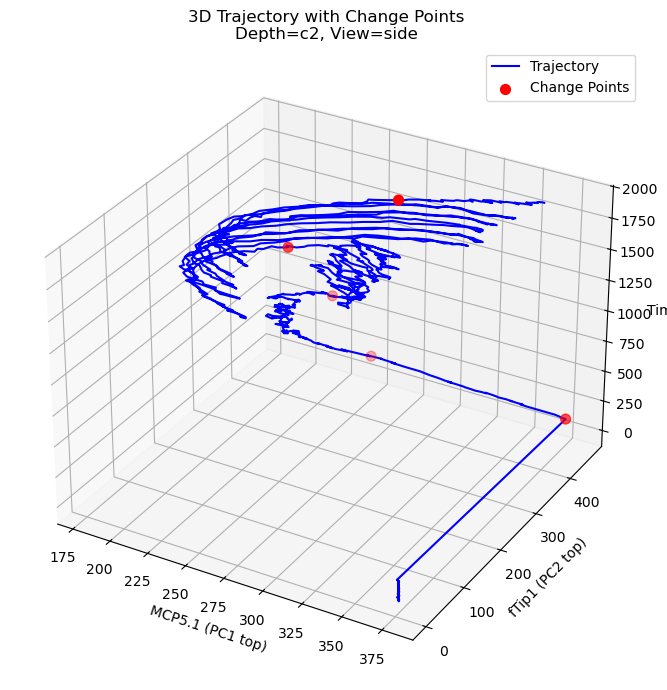

Change points (frame indices) for c2 side: [170, 225, 655, 1260, 1805, 1874]

Processing depth=c3, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC1    MCP1.1  0.241796   fTip3.1  0.239253    MCP2.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
10  0.236303   fTip4.1  0.232279    MCP3.1  0.229135  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC2  PalmBase  0.288237      MCP4  0.265039      MCP1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
10  0.260959     fTip2   0.26022      MCP3  0.259232  
PalmBase


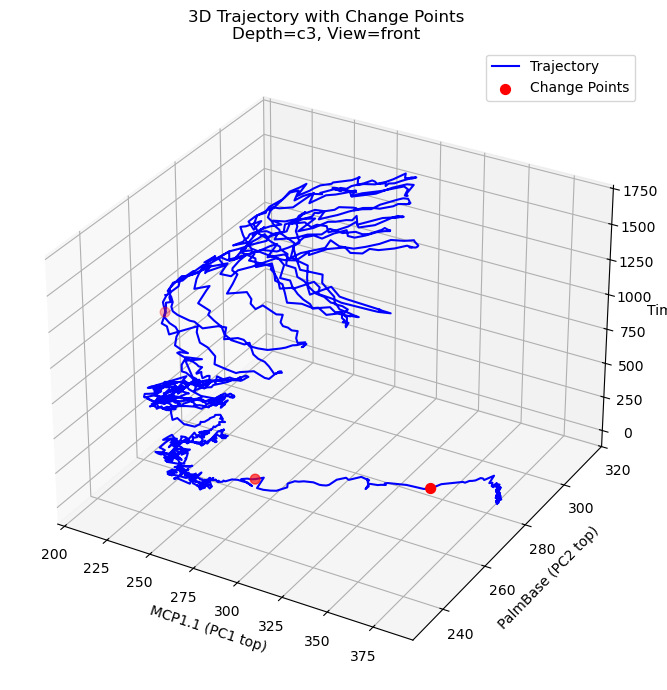

Change points (frame indices) for c3 front: [160, 200, 1085, 1653]

Processing depth=c3, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
11    c3  side       PC1   fTip5.1  0.226871    MCP5.1  0.226229    MCP4.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
11  0.215181   fTip4.1  0.214777      MCP5  0.210909  
   depth  view component feature_1  weight_1      feature_2  weight_2  \
11    c3  side       PC2     fTip1  0.289352  StablePoint.1  0.236706   

   feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
11    MCP2.1 -0.231827   fTip2.1 -0.208513    MCP1.1 -0.208458  
fTip1


KeyboardInterrupt: 

In [343]:
import ruptures as rpt

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

# Helper: get top feature for PC from top5_df DataFrame (which you created above)
def get_top_feature(top5_df, depth, view, component='PC1'):
    subset = top5_df[(top5_df['depth'] == depth) & (top5_df['view'] == view) & (top5_df['component'] == component)]
    print(subset)
    if subset.empty:
        return None
    return subset.iloc[0]['feature_1']  # the top feature is in feature_1 column

# Loop through unique depths and views from pca1_df or explained_df
depths = explained_df['depth'].unique()
views = explained_df['view'].unique()

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        print(top_feature_pc2)

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)


        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # 3D Line Plot of the Trajectory
        ax.plot(x, y, t, label='Trajectory', color='blue')

        # Plot change points as red scatter points
        cp_x = [x[i] for i in change_points[:-1]]  # exclude last if it's just the end
        cp_y = [y[i] for i in change_points[:-1]]
        cp_t = [t[i] for i in change_points[:-1]]
        ax.scatter(cp_x, cp_y, cp_t, color='red', s=50, label='Change Points')

        # Labels and title
        ax.set_xlabel(f"{top_feature_pc1} (PC1 top)")
        ax.set_ylabel(f"{top_feature_pc2} (PC2 top)")
        ax.set_zlabel("Time")
        ax.set_title(f"3D Trajectory with Change Points\nDepth={depth}, View={view}")
        ax.legend()

        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")


## Shows change points on 2D graph --> creates new df for indices


Processing depth=b1, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC1     fTip3  0.240434   Elbow.1  0.239025     fTip4   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0  0.235319     fTip2  0.233802     fTip5  0.224488  
  depth   view component feature_1  weight_1 feature_2  weight_2   feature_3  \
0    b1  front       PC2    MCP5.1  0.290214   fTip5.1  0.279951  PalmBase.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0  0.272104    MCP4.1  0.266104   fTip4.1  0.249886  


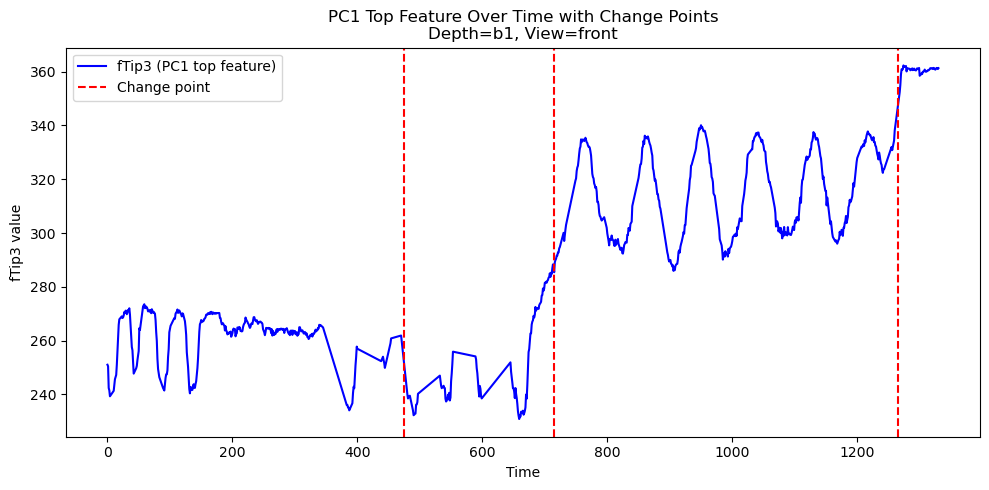

Change points (frame indices) for b1 front: [475, 715, 1265, 1331]

Processing depth=b1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
1    b1  side       PC1      MCP3  0.249545      MCP2  0.249181      MCP4   

   weight_3 feature_4  weight_4 feature_5  weight_5  
1  0.248655      MCP5   0.24772  PalmBase  0.245167  
  depth  view component feature_1  weight_1   feature_2  weight_2  \
1    b1  side       PC2    MCP2.1    0.3067  PalmBase.1  0.290676   

      feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
1  MidForeArm.1   0.28317    MCP3.1  0.281433   fTip2.1  0.265973  


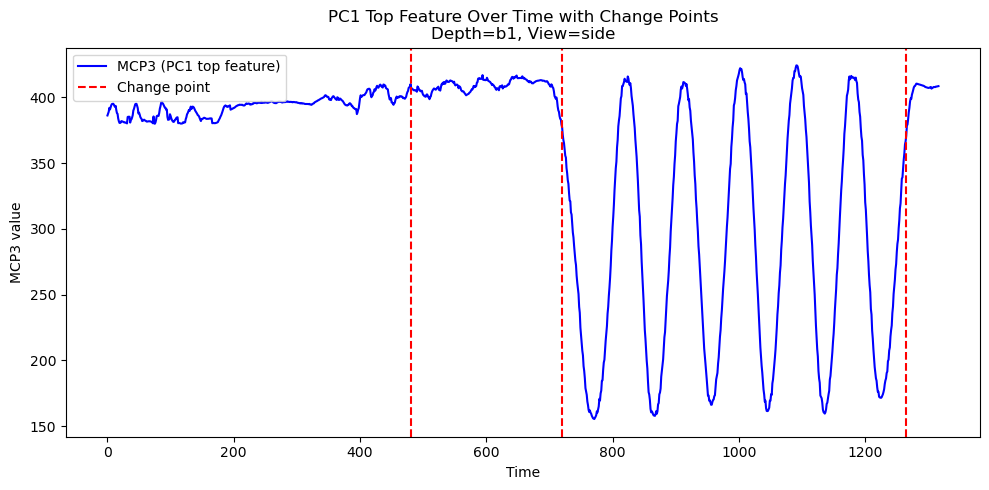

Change points (frame indices) for b1 side: [480, 720, 1265, 1317]

Processing depth=b2, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC1    MCP2.1  0.239753   fTip2.1  0.236234    MCP3.1   

   weight_3 feature_4  weight_4     feature_5  weight_5  
2   0.23207   fTip1.1  0.229204  MidForeArm.1  0.226123  
  depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC2  MidForeArm  0.317838  PalmBase  0.307578     fTip3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
2  0.272293      MCP1   0.25093      MCP4  0.246726  


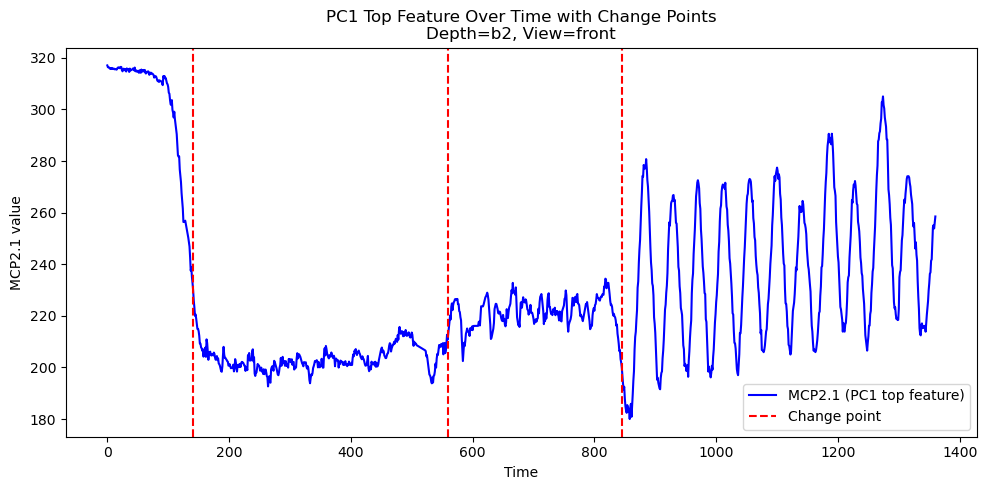

Change points (frame indices) for b2 front: [140, 560, 845, 1361]

Processing depth=b2, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
3    b2  side       PC1      MCP5  0.264611      MCP4   0.26456      MCP3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
3  0.263513      MCP2  0.261108     fTip5  0.258142  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
3    b2  side       PC2    MCP2.1  0.278243   fTip1.1  0.264611    MCP1.1   

   weight_3   feature_4  weight_4 feature_5  weight_5  
3  0.262902  PalmBase.1   0.26195   fTip2.1  0.260741  


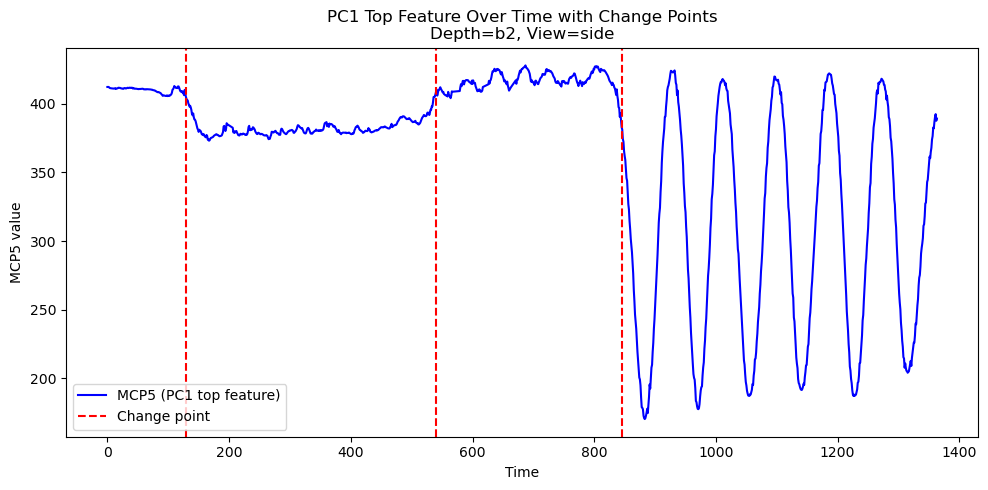

Change points (frame indices) for b2 side: [130, 540, 845, 1364]

Processing depth=b3, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
4    b3  front       PC1    MCP2.1    0.2457   fTip2.1  0.240437   fTip1.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
4   0.23815     fTip3  0.236202    MCP1.1  0.233373  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
4    b3  front       PC2   fTip5.1  0.263728  PalmBase -0.256332      MCP3   

   weight_3   feature_4  weight_4 feature_5  weight_5  
4 -0.255069  PalmBase.1  0.252786    MCP5.1  0.250988  


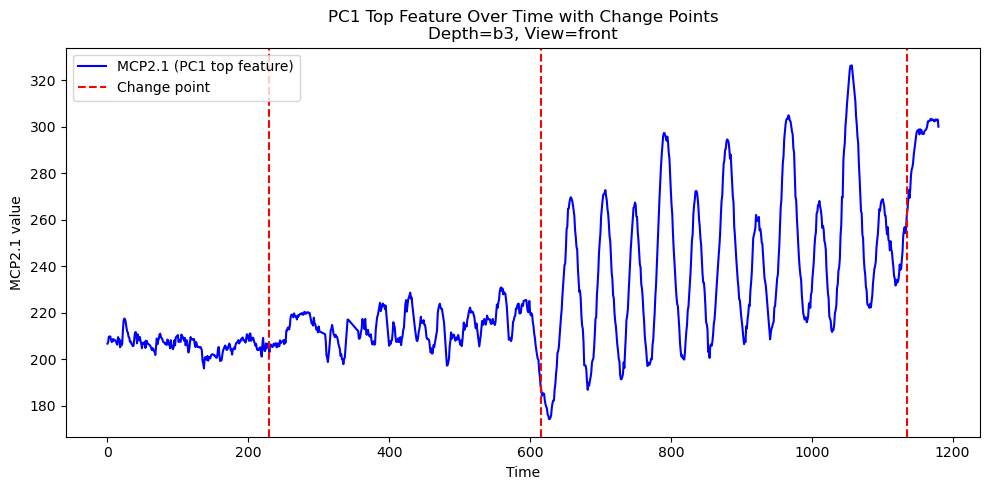

Change points (frame indices) for b3 front: [230, 615, 1135, 1181]

Processing depth=b3, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
5    b3  side       PC1      MCP3  0.273454      MCP4  0.272974      MCP2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
5   0.27287     fTip3  0.272103      MCP5  0.271784  
  depth  view component feature_1  weight_1   feature_2  weight_2 feature_3  \
5    b3  side       PC2    MCP3.1  0.301237  PalmBase.1  0.299209    MCP2.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
5  0.298406    MCP4.1  0.290691    MCP1.1  0.283659  


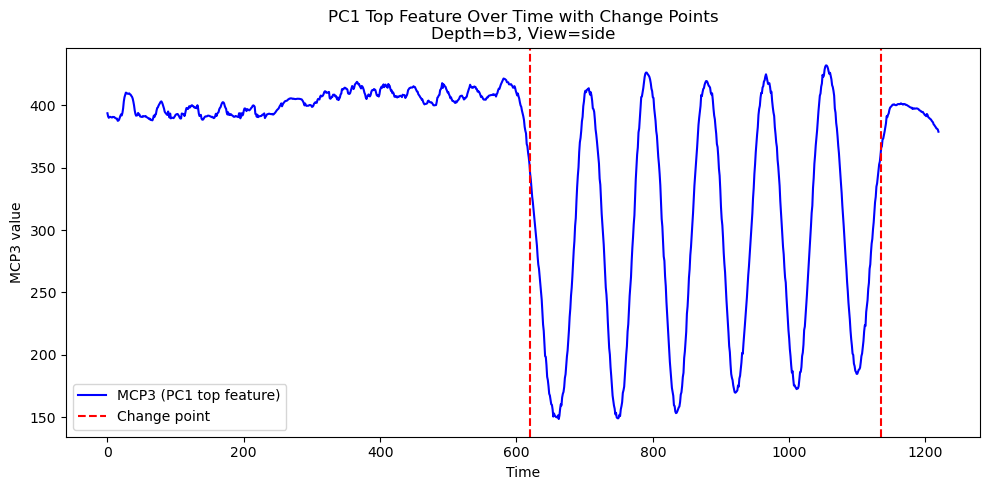

Change points (frame indices) for b3 side: [620, 1135, 1220]

Processing depth=c1, view=front
  depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
6    c1  front       PC1  PalmBase.1  0.274866    MCP4.1  0.251102  PalmBase   

   weight_3 feature_4  weight_4 feature_5  weight_5  
6 -0.247674      MCP4 -0.236199    MCP3.1  0.236027  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
6    c1  front       PC2     fTip2  0.289214   fTip1.1  0.265864   fTip2.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
6  0.258559     fTip4  0.256996   fTip3.1  0.250977  


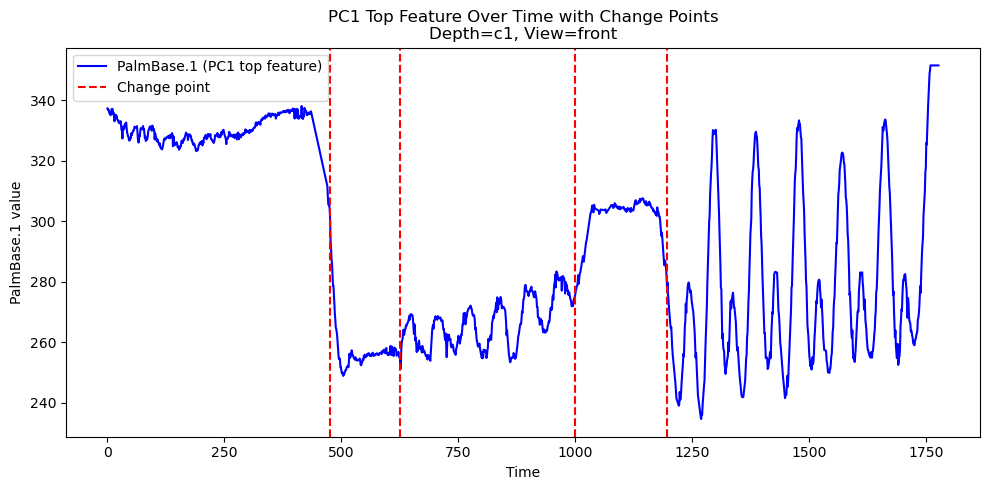

Change points (frame indices) for c1 front: [475, 625, 1000, 1195, 1777]

Processing depth=c1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
7    c1  side       PC1      MCP1  0.243886     fTip1  0.243171      MCP2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.239341     fTip2  0.237263      MCP3   0.23332  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
7    c1  side       PC2    MCP2.1  0.277671   Elbow.1  0.255588   fTip1.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.250201   fTip2.1  0.247285    MCP3.1  0.243925  


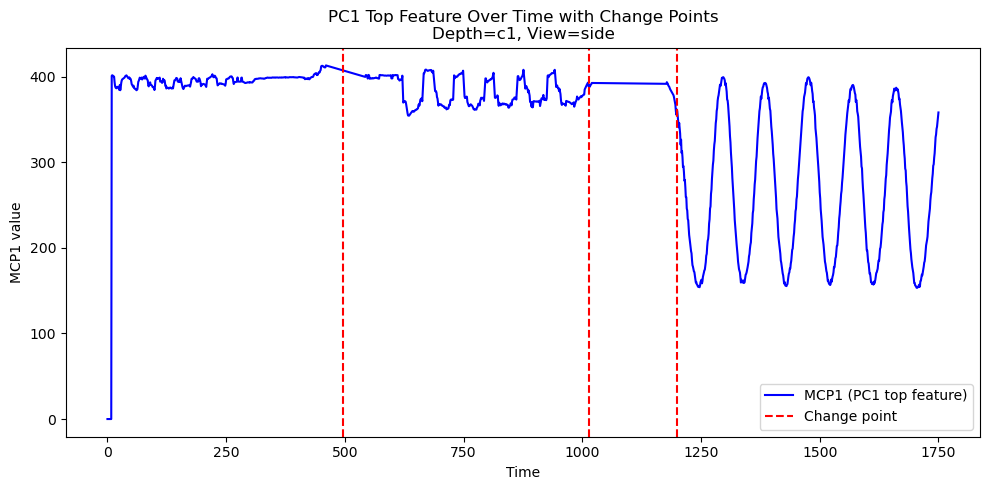

Change points (frame indices) for c1 side: [495, 1015, 1200, 1751]

Processing depth=c2, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
8    c2  front       PC1    MCP1.1  0.236851    MCP2.1   0.23186   fTip4.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
8  0.229896    MCP3.1  0.226722   fTip3.1  0.225958  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
8    c2  front       PC2  PalmBase  0.311604      MCP3     0.285      MCP4   

   weight_3 feature_4  weight_4 feature_5  weight_5  
8  0.282223      MCP1  0.280202      MCP2  0.262377  


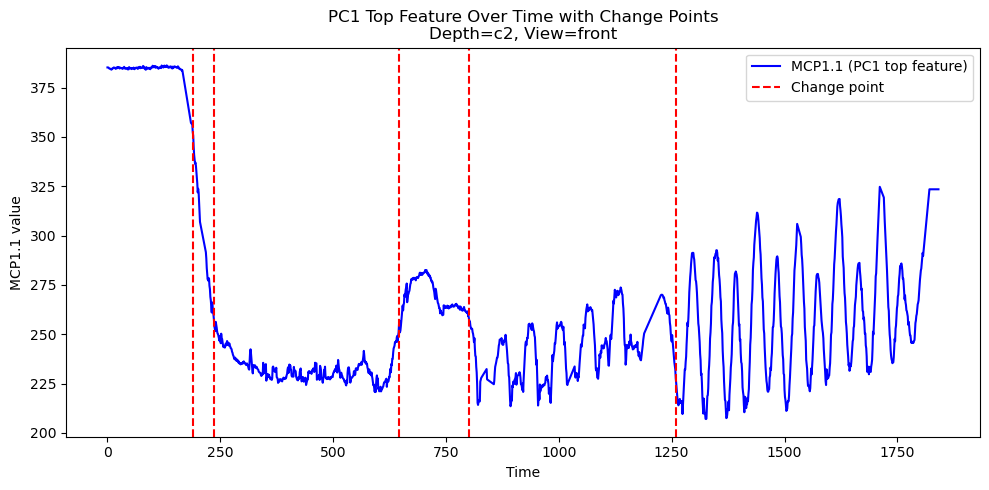

Change points (frame indices) for c2 front: [190, 235, 645, 800, 1260, 1842]

Processing depth=c2, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
9    c2  side       PC1    MCP5.1  0.226989   fTip5.1  0.226067      MCP5   

   weight_3 feature_4  weight_4 feature_5  weight_5  
9   0.21808      MCP4  0.217452    MCP4.1  0.217401  
  depth  view component feature_1  weight_1 feature_2  weight_2  \
9    c2  side       PC2     fTip1  0.271649   Elbow.1 -0.264416   

       feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
9  StablePoint.1  0.250331    MCP2.1 -0.224037      MCP1  0.209087  


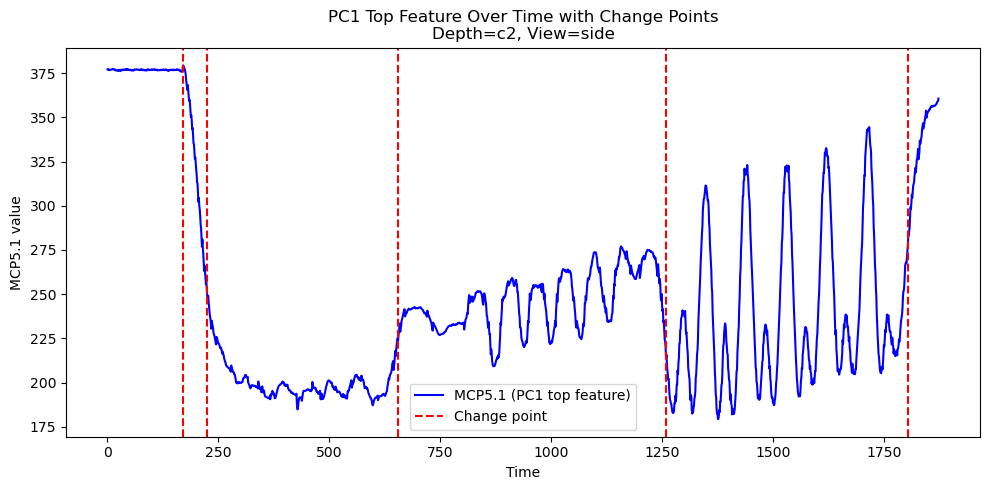

Change points (frame indices) for c2 side: [170, 225, 655, 1260, 1805, 1874]

Processing depth=c3, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC1    MCP1.1  0.241796   fTip3.1  0.239253    MCP2.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
10  0.236303   fTip4.1  0.232279    MCP3.1  0.229135  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC2  PalmBase  0.288237      MCP4  0.265039      MCP1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
10  0.260959     fTip2   0.26022      MCP3  0.259232  


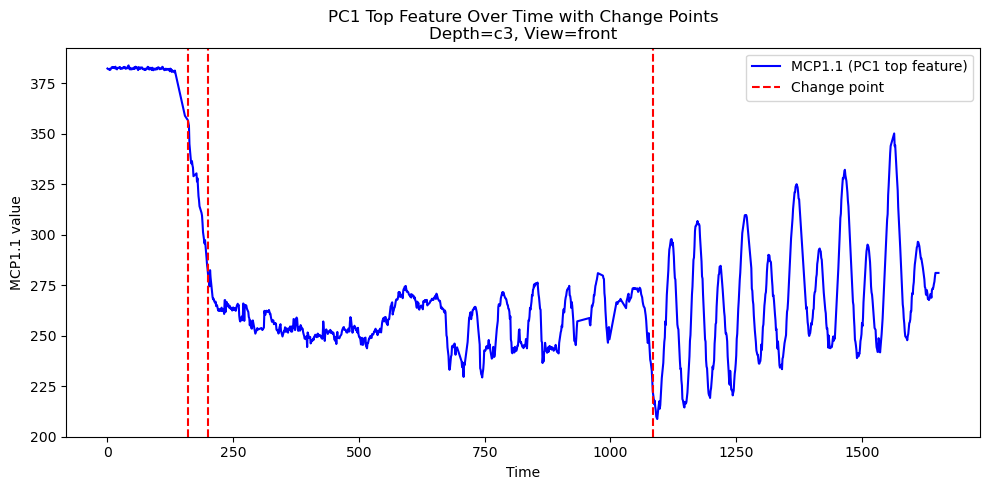

Change points (frame indices) for c3 front: [160, 200, 1085, 1653]

Processing depth=c3, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
11    c3  side       PC1   fTip5.1  0.226871    MCP5.1  0.226229    MCP4.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
11  0.215181   fTip4.1  0.214777      MCP5  0.210909  
   depth  view component feature_1  weight_1      feature_2  weight_2  \
11    c3  side       PC2     fTip1  0.289352  StablePoint.1  0.236706   

   feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
11    MCP2.1 -0.231827   fTip2.1 -0.208513    MCP1.1 -0.208458  


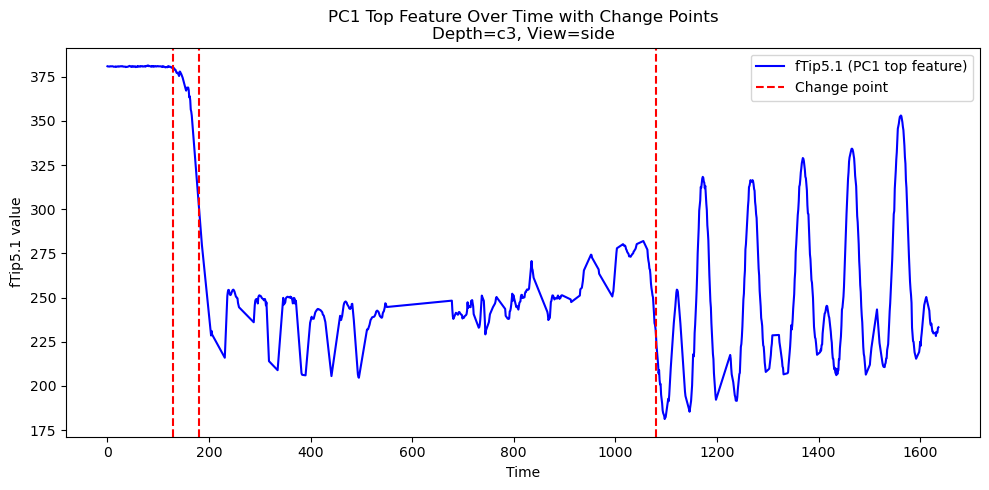

Change points (frame indices) for c3 side: [130, 180, 1080, 1637]

Processing depth=t1, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
12    t1  front       PC1     fTip3  0.219869     fTip2  0.219538    MCP2.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
12  0.218285     fTip4  0.217759    MCP3.1  0.217677  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
12    t1  front       PC2   fTip5.1  0.345715      MCP5 -0.310928      MCP4   

    weight_3 feature_4  weight_4 feature_5  weight_5  
12 -0.265816      MCP3 -0.259654     fTip1 -0.250734  


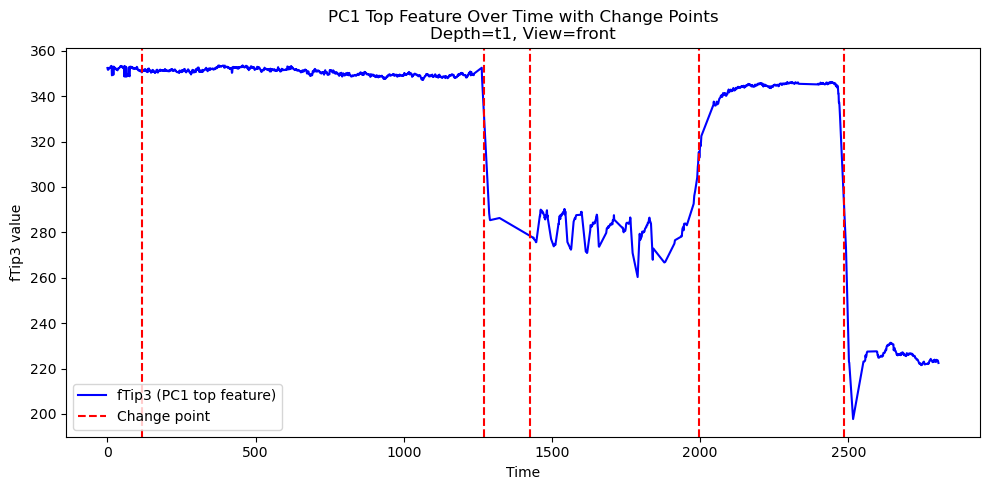

Change points (frame indices) for t1 front: [115, 1270, 1425, 1995, 2485, 2805]

Processing depth=t1, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
13    t1  side       PC1   fTip4.1  0.220529      MCP5    0.2205      MCP4   

    weight_3 feature_4  weight_4 feature_5  weight_5  
13  0.217495    MCP5.1  0.216928      MCP3  0.214078  
   depth  view component feature_1  weight_1     feature_2  weight_2  \
13    t1  side       PC2   Elbow.1  0.342555  MidForeArm.1  0.303029   

     feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
13  PalmBase.1  0.229245    MCP2.1    0.2049  PalmBase -0.202829  


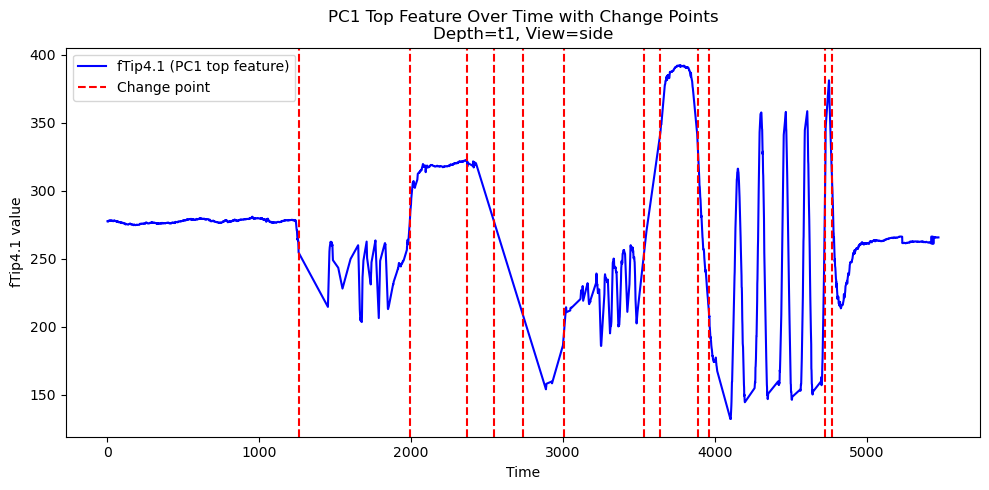

Change points (frame indices) for t1 side: [1260, 1990, 2365, 2545, 2735, 3010, 3535, 3640, 3890, 3960, 4725, 4775, 5474]

Processing depth=t2, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
14    t2  front       PC1    MCP2.1  0.237157     fTip1  0.234748      MCP2   

    weight_3 feature_4  weight_4 feature_5  weight_5  
14  0.233601    MCP3.1  0.232699      MCP3  0.232375  
   depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
14    t2  front       PC2  PalmBase.1  0.277615   fTip5.1  0.268039   fTip2.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
14  0.252148    MCP5.1  0.244878    MCP1.1  0.229153  


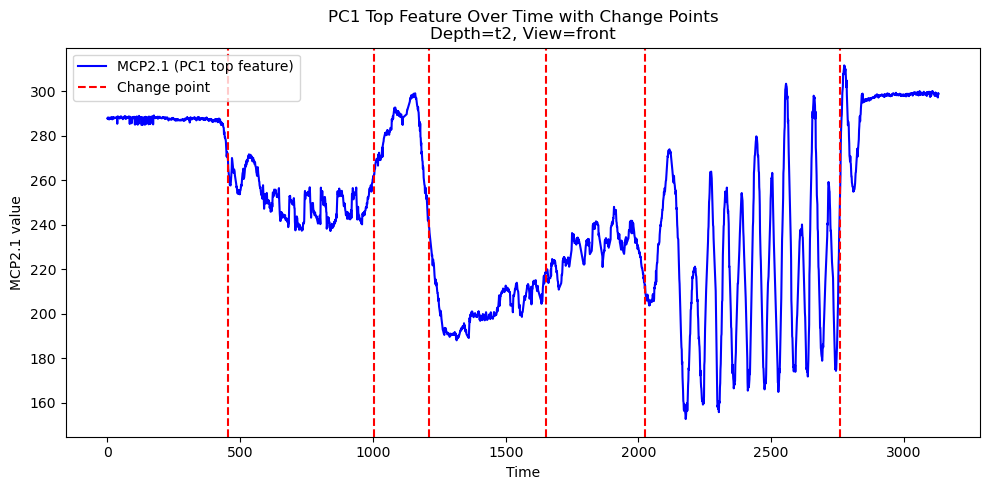

Change points (frame indices) for t2 front: [455, 1005, 1210, 1650, 2025, 2760, 3131]

Processing depth=t2, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
15    t2  side       PC1      MCP3  0.223852      MCP4  0.223399      MCP2   

    weight_3 feature_4  weight_4   feature_5  weight_5  
15  0.223162      MCP5  0.223078  MidForeArm   0.22185  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
15    t2  side       PC2    MCP2.1  0.279011   fTip2.1   0.25056    MCP1.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
15  0.241619   fTip1.1  0.240881    MCP3.1   0.23393  


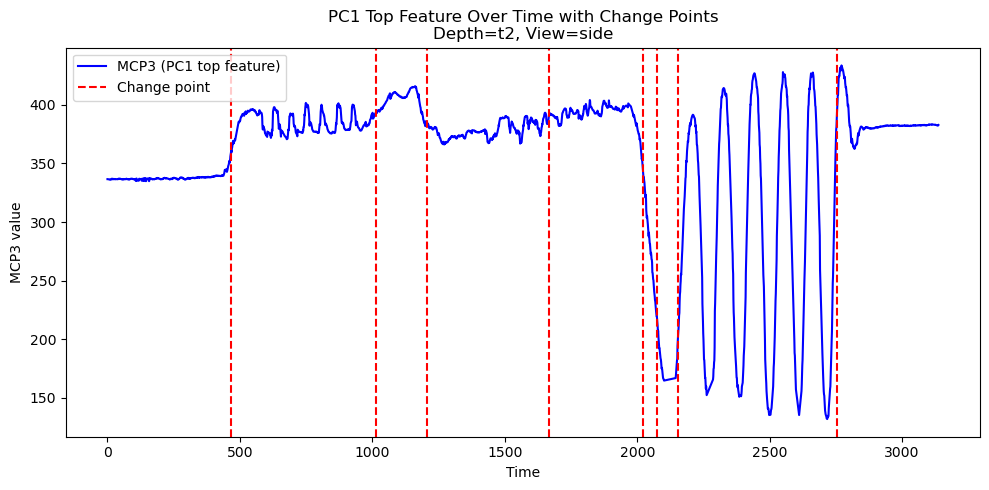

Change points (frame indices) for t2 side: [465, 1015, 1205, 1665, 2020, 2075, 2155, 2755, 3138]

Processing depth=t3, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
16    t3  front       PC1     fTip2   0.23742     fTip3  0.235256     fTip4   

    weight_3 feature_4  weight_4 feature_5  weight_5  
16  0.234369      MCP5  0.234289      MCP4  0.233987  
   depth   view component feature_1  weight_1 feature_2  weight_2  \
16    t3  front       PC2   fTip5.1  0.375554     fTip5  0.312463   

       feature_3  weight_3   feature_4  weight_4 feature_5  weight_5  
16  MidForeArm.1  0.309231  MidForeArm  0.285133    MCP1.1  0.266994  


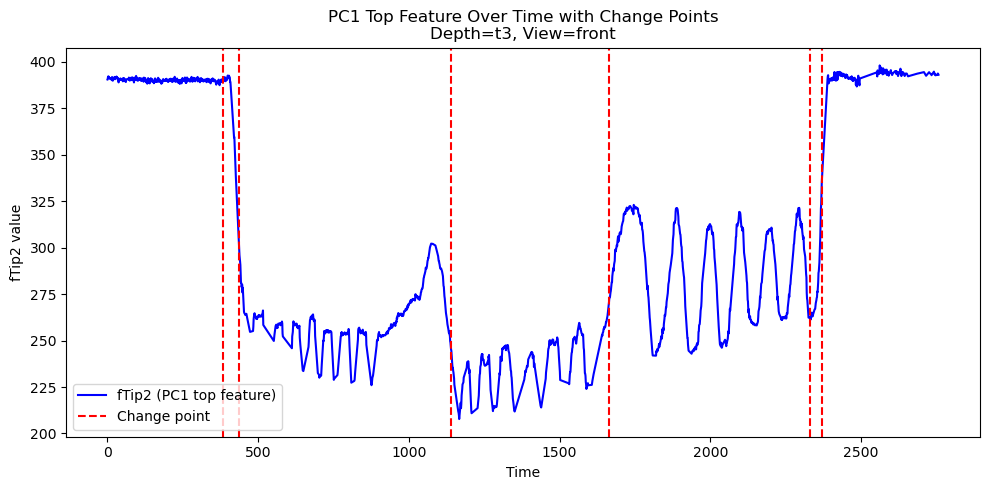

Change points (frame indices) for t3 front: [385, 435, 1140, 1665, 2330, 2370, 2758]

Processing depth=t3, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
17    t3  side       PC1   fTip5.1  0.244633      MCP5  0.233292   fTip4.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
17  0.232408     fTip5   0.23238    MCP5.1  0.232102  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
17    t3  side       PC2     fTip3  0.317763  PalmBase  0.316197   Elbow.1   

    weight_3 feature_4  weight_4     feature_5  weight_5  
17 -0.274461    MCP2.1 -0.246796  MidForeArm.1 -0.238147  


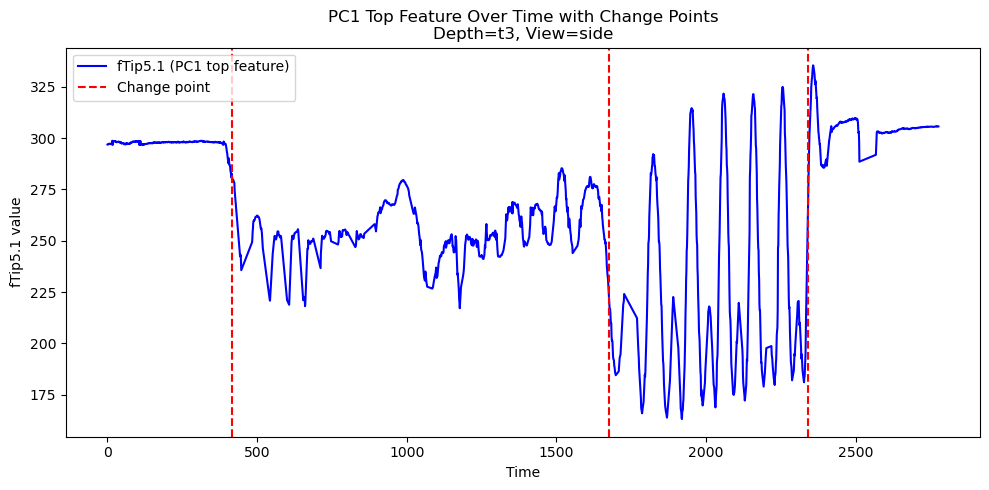

Change points (frame indices) for t3 side: [415, 1675, 2340, 2777]


In [351]:
results_list = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)



        # Inside the nested loop after change_points are computed
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label=f"{top_feature_pc1} (PC1 top feature)", color='blue')
        for cp in change_points[:-1]:  # Skip the last point if it's just the end of signal
            plt.axvline(x=cp, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")
        plt.xlabel("Time")
        plt.ylabel(f"{top_feature_pc1} value")
        plt.title(f"PC1 Top Feature Over Time with Change Points\nDepth={depth}, View={view}")
        plt.legend()
        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        # Create a dictionary for storing change point results
        dic_indices = {
            "depth": depth,
            "view": view,
            "component": "indices"
        }

        # Save the top features and their change points
        dic_indices["feature_1"] = top_feature_pc1
        dic_indices["feature_2"] = top_feature_pc2
        dic_indices["change_points"] = change_points

        # Assuming you're collecting multiple such dictionaries into a list
        results_list.append(dic_indices)





## Visualize indices df

In [379]:
df_indices = pd.DataFrame(results_list)

df_indices 

depth   view component   feature_1   feature_2  \
0     b1  front   indices       fTip3      MCP5.1   
1     b1   side   indices        MCP3      MCP2.1   
2     b2  front   indices      MCP2.1  MidForeArm   
3     b2   side   indices        MCP5      MCP2.1   
4     b3  front   indices      MCP2.1     fTip5.1   
5     b3   side   indices        MCP3      MCP3.1   
6     c1  front   indices  PalmBase.1       fTip2   
7     c1   side   indices        MCP1      MCP2.1   
8     c2  front   indices      MCP1.1    PalmBase   
9     c2   side   indices      MCP5.1       fTip1   
10    c3  front   indices      MCP1.1    PalmBase   
11    c3   side   indices     fTip5.1       fTip1   
12    t1  front   indices       fTip3     fTip5.1   
13    t1   side   indices     fTip4.1     Elbow.1   
14    t2  front   indices      MCP2.1  PalmBase.1   
15    t2   side   indices        MCP3      MCP2.1   
16    t3  front   indices       fTip2     fTip5.1   
17    t3   side   indices     fTip5.1       fTip3   

                                        change_points  
0                              [475, 715, 1265, 1331]  
1                              [480, 720, 1265, 1317]  
2                               [140, 560, 845, 1361]  
3                               [130, 540, 845, 1364]  
4                              [230, 615, 1135, 1181]  
5                                   [620, 1135, 1220]  
6                        [475, 625, 1000, 1195, 1777]  
7                             [495, 1015, 1200, 1751]  
8                    [190, 235, 645, 800, 1260, 1842]  
9                   [170, 225, 655, 1260, 1805, 1874]  
10                             [160, 200, 1085, 1653]  
11                             [130, 180, 1080, 1637]  
12                [115, 1270, 1425, 1995, 2485, 2805]  
13  [1260, 1990, 2365, 2545, 2735, 3010, 3535, 364...  
14          [455, 1005, 1210, 1650, 2025, 2760, 3131]  
15  [465, 1015, 1205, 1665, 2020, 2075, 2155, 2755...  
16           [385, 435, 1140, 1665, 2330, 2370, 2758]  
17                            [415, 1675, 2340, 2777]

## Averaging close datapoints

In [380]:
# Create an empty list to hold averaged points for each row
averaged_points_list = []

# Loop through each row in the DataFrame
for _, row in df_indices.iterrows():
    change_points = row['change_points']
    averaged_points = average_close_indices(change_points, threshold=100)
    averaged_points_list.append(averaged_points)

# Assign the results as a new column in the DataFrame
df_indices['averaged_points'] = averaged_points_list

## Creating movement df for armEF

In [383]:
df_movements = pd.DataFrame(columns=['dataset', 'view', 'arm_EF', 'hand_OC', 'hand_PS'])

for _, row in df_indices.iterrows():
    all_indices = row['averaged_points']
    movement = 'arm_EF'

    if len(all_indices) == 1:
        continue

    dif = all_indices[-2] - all_indices[-1]
    print(f'the difference is {dif}')

    if np.abs(all_indices[-2] - all_indices[-1]) < 500:
        if len(all_indices) >= 3:
            start = all_indices[-3]
            end = all_indices[-2]
        else: 
            start = all_indices[-2]
            end = all_indices[-1]
    else:
        start = all_indices[-2]
        end = all_indices[-1]
        

    df_movements = pd.concat([
    df_movements,
    pd.DataFrame([{
        'dataset': row['depth'],        # <- use `row` to access data from df_indices
        'view': row['view'],
        'arm_EF': (start, end),
        'hand_OC': (0,0),
        'hand_PS': (0,0)
    }])
], ignore_index=True)

print(df_movements)

the difference is -583
the difference is -571
the difference is -516
the difference is -519
the difference is -543
the difference is -557
the difference is -582
the difference is -551
the difference is -582
the difference is -579
the difference is -568
the difference is -557
the difference is -320
the difference is -724
the difference is -371
the difference is -383
the difference is -408
the difference is -437
   dataset   view        arm_EF hand_OC hand_PS
0       b1  front   (715, 1298)  (0, 0)  (0, 0)
1       b1   side   (720, 1291)  (0, 0)  (0, 0)
2       b2  front   (845, 1361)  (0, 0)  (0, 0)
3       b2   side   (845, 1364)  (0, 0)  (0, 0)
4       b3  front   (615, 1158)  (0, 0)  (0, 0)
5       b3   side   (620, 1177)  (0, 0)  (0, 0)
6       c1  front  (1195, 1777)  (0, 0)  (0, 0)
7       c1   side  (1200, 1751)  (0, 0)  (0, 0)
8       c2  front  (1260, 1842)  (0, 0)  (0, 0)
9       c2   side  (1260, 1839)  (0, 0)  (0, 0)
10      c3  front  (1085, 1653)  (0, 0)  (0, 0)
11      c3

## Visualizing armEF segmentation

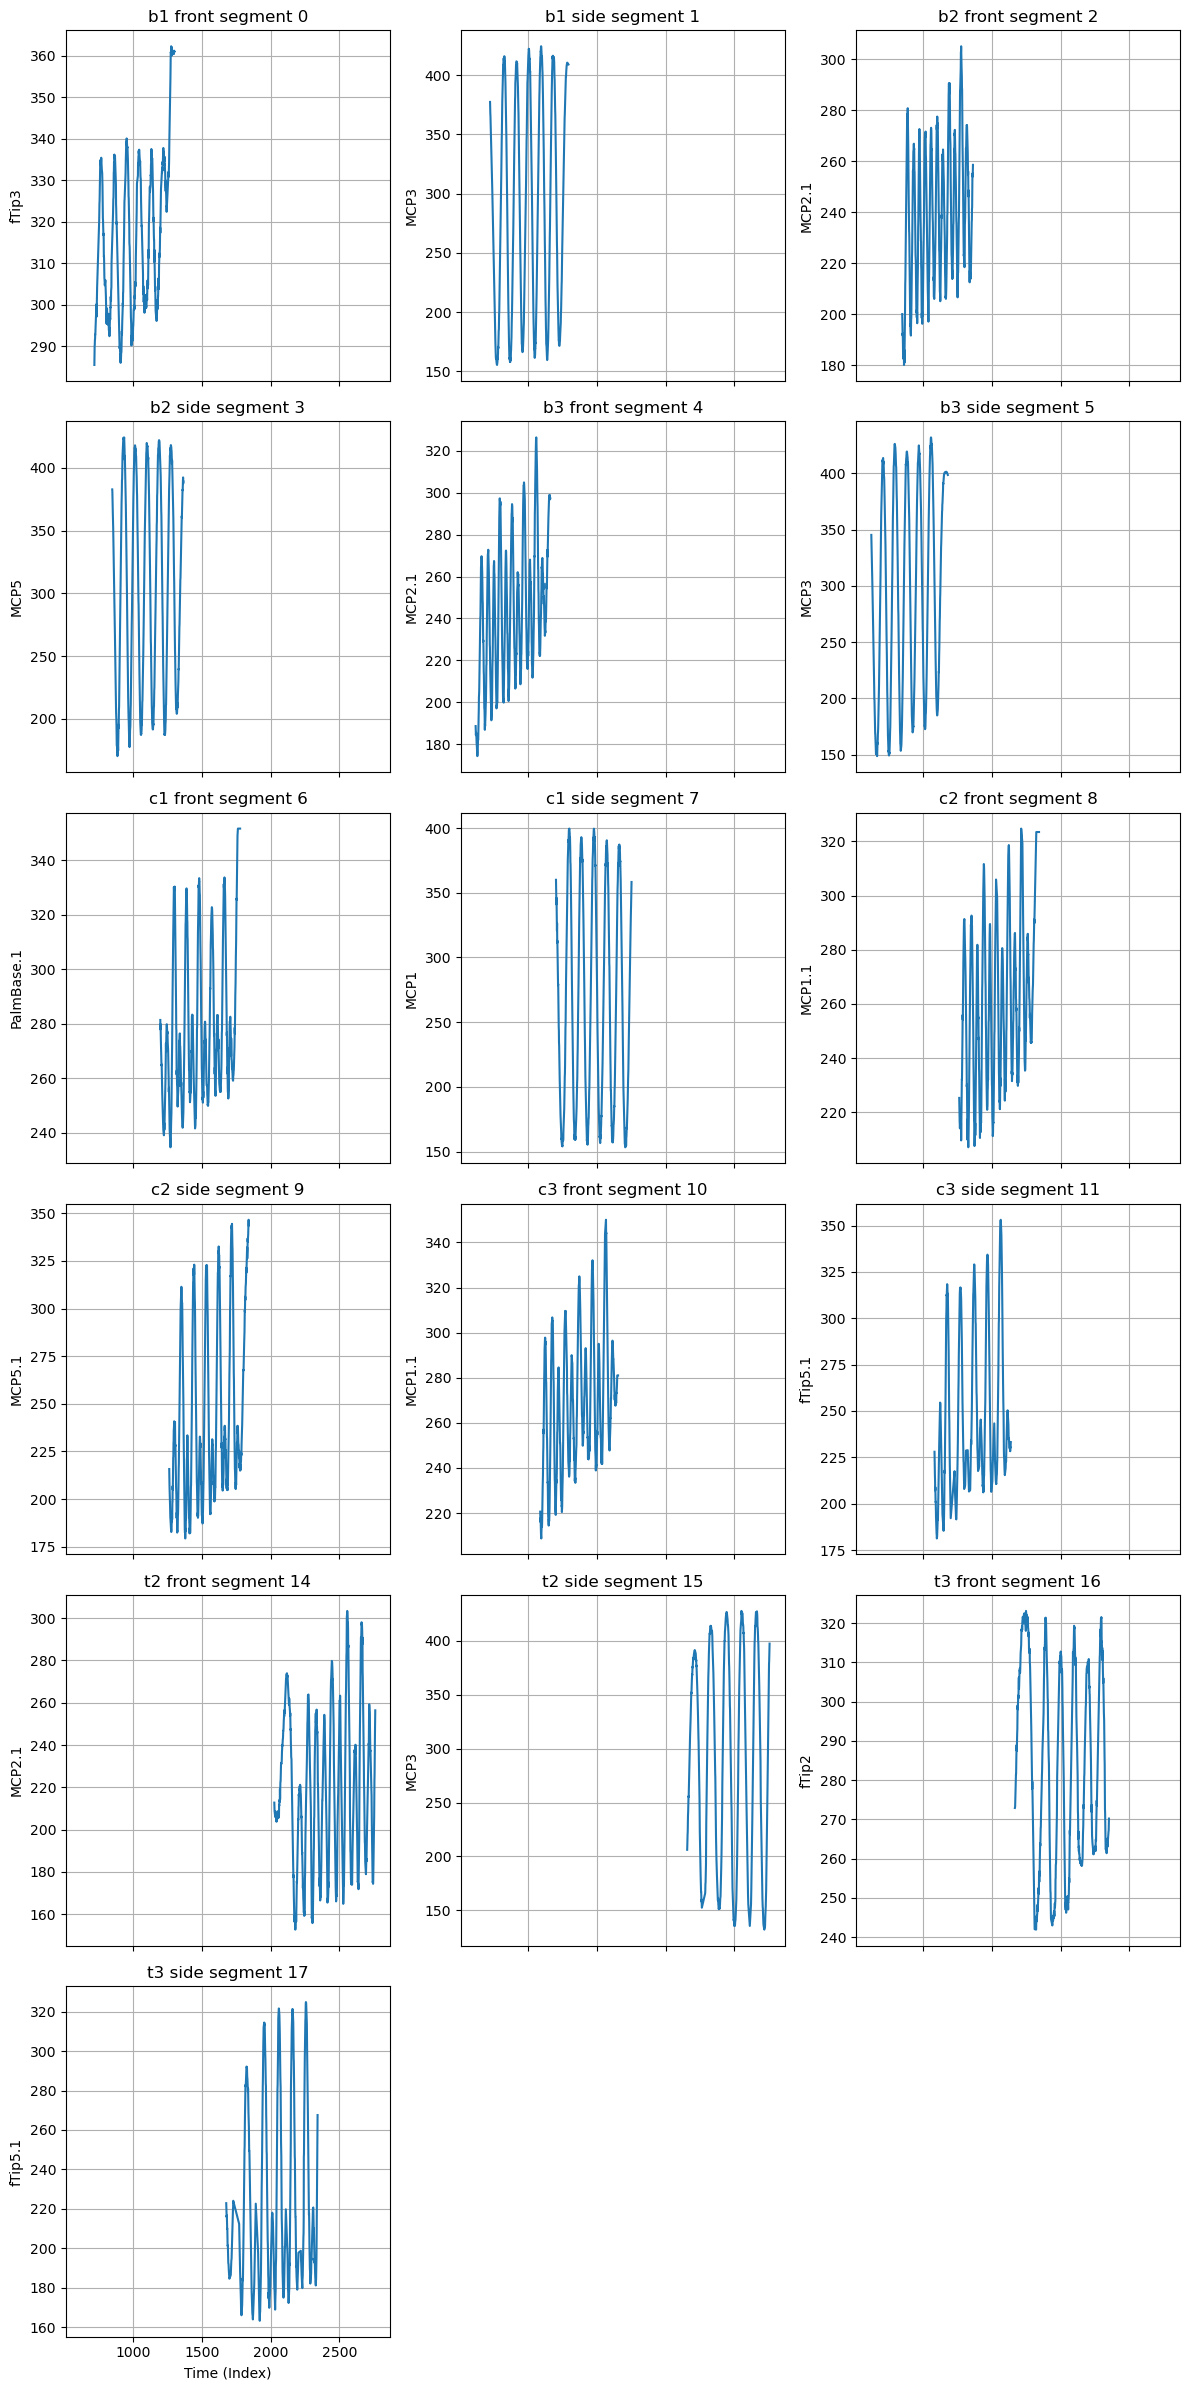

In [300]:
import matplotlib.pyplot as plt
import math

# Filter out rows where depth is 't1'
filtered_movements = df_movements[df_movements['dataset'] != 't1']
n = len(filtered_movements)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=True)
axs = axs.flatten()

for idx, (i, row) in enumerate(filtered_movements.iterrows()):
    depth = row['dataset']
    view_type = row['view']
    start, end = row['indices']

    df_key = depth + ('f' if view_type == 'front' else 's')
    if df_key not in dataframes:
        print(f"Data for {df_key} not found.")
        continue

    df = dataframes[df_key]

    top_feature = get_top_feature(top5_pc1_df, depth, view_type, 'PC1')
    if top_feature not in df.columns:
        print(f"{top_feature} not found in data for {df_key}")
        continue

    segment = df[top_feature].iloc[start:end+1]

    ax = axs[idx]
    ax.plot(segment.index, segment.values)
    ax.set_title(f"{depth} {view_type} segment {i}")
    ax.set_ylabel(f"{top_feature}")
    ax.grid(True)

# Hide any unused subplots
for i in range(n, len(axs)):
    fig.delaxes(axs[i])

plt.xlabel("Time (Index)")
plt.tight_layout()
plt.show()


## Run PCA on only handOC and handPS time - working on now

In [348]:
# New containers for start-segment PCA data
pca1_start_rows = []
pca2_start_rows = []
explained_start_rows = []
top5_start_pc1_rows = []
top5_start_pc2_rows = []

view_map = {"front": "f", "side": "s"}

for _, row in df_movements.iterrows():
    depth = row["dataset"]
    view = row["view"]

    # Skip if missing
    if pd.isna(depth) or pd.isna(view):
        continue

    # Map "front"/"side" to "f"/"s"
    view_letter = view_map.get(view.lower())

    if view_letter is None:
        print(f"Unrecognized view: {view}")
        continue

    base = f"{depth}{view_letter}"

    if base not in dataframes:
        print(f"Skipping {base} - not found in dataframes.")
        continue

    df_full = dataframes[base]
    


    # Get starting segment: from 0 to first change point of armEF so it only includes handOC and armPS
    change_points = row['indices']  
    if not change_points or len(change_points) == 0:
        continue  # Skip if no change points
    
    first_cp = int(change_points[0])
    df_segment = df_full.iloc[:first_cp]

    # Trim initial zeros like before
    df_trimmed = trim_initial_zeros(df_segment)

    # Run PCA on start segment
    X_pca, explained_ratio, explained_raw, components = run_PCA(df_segment, None, base, "start")

    used_columns = df_segment.loc[:, ~df_segment.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    pc1 = components[0]
    pc2 = components[1]

    # Build PCA1 row
    row_pc1 = {"depth": depth, "view": view_letter, "component": "PC1"}
    row_pc2 = {"depth": depth, "view": view_letter, "component": "PC2"}
    
    for feat, w1, w2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = w1
        row_pc2[feat] = w2

    pca1_start_rows.append(row_pc1)
    pca2_start_rows.append(row_pc2)

    explained_start_rows.append({
        "depth": depth,
        "view": view_letter,
        "PC1_var": explained_ratio[0],
        "PC2_var": explained_ratio[1]
    })

    # Top 5 for PC1
    contributions = list(zip(final_cols, pc1))
    contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    top5 = contributions[:5]

    top5_dict = {
        "depth": depth,
        "view": view,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_start_pc1_rows.append(top5_dict)


    # Top 5 for PC2
    contributions_pc2 = list(zip(final_cols, pc2))
    contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = contributions_pc2[:5]

    top5_dict_pc2 = {
        "depth": depth,
        "view": view,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_dict_pc2[f"feature_{idx+1}"] = feat
        top5_dict_pc2[f"weight_{idx+1}"] = weight
    top5_start_pc2_rows.append(top5_dict_pc2)


# At the end: convert to dataframes
pca1_start_df = pd.DataFrame(pca1_start_rows)
pca2_start_df = pd.DataFrame(pca2_start_rows)
explained_start_df = pd.DataFrame(explained_start_rows)
top5_start_pc1_df = pd.DataFrame(top5_start_pc1_rows)
top5_start_pc2_df = pd.DataFrame(top5_start_pc2_rows)



In [346]:
top5_start_pc1_df

depth   view component     feature_1  weight_1     feature_2  weight_2  \
0     b1  front       PC1        MCP4.1  0.285107        MCP5.1  0.283261   
1     b1   side       PC1        MCP3.1  0.261067        MCP4.1  0.260727   
2     b2  front       PC1  MidForeArm.1  0.218299    PalmBase.1  0.217230   
3     b2   side       PC1  MidForeArm.1  0.250556        MCP2.1  0.250305   
4     b3  front       PC1          MCP2  0.315122       fTip5.1 -0.312210   
5     b3   side       PC1          MCP4  0.294266          MCP5  0.288715   
6     c1  front       PC1    PalmBase.1  0.265863      PalmBase -0.265418   
7     c1   side       PC1       fTip1.1  0.259997        MCP2.1  0.259522   
8     c2  front       PC1        MCP1.1  0.214995          MCP5  0.213767   
9     c2   side       PC1        MCP2.1  0.220064        MCP5.1  0.219996   
10    c3  front       PC1        MCP1.1  0.218667      PalmBase  0.217235   
11    c3   side       PC1        MCP2.1  0.224382        MCP5.1  0.224173   
12    t1  front       PC1        MCP3.1  0.221051        MCP2.1  0.220930   
13    t1   side       PC1          MCP5  0.219805       fTip4.1  0.219516   
14    t2  front       PC1      PalmBase  0.236575          MCP1  0.235947   
15    t2   side       PC1         fTip4  0.263123         fTip3  0.262222   
16    t3  front       PC1          MCP5  0.225735          MCP4  0.224261   
17    t3   side       PC1         fTip3  0.239972  MidForeArm.1 -0.238638   

       feature_3  weight_3 feature_4  weight_4     feature_5  weight_5  
0        fTip5.1  0.277543    MCP3.1  0.268088  MidForeArm.1  0.264720  
1         MCP5.1  0.258208      MCP4  0.256631        MCP2.1  0.253560  
2         MCP2.1  0.216981   Elbow.1  0.216181          MCP4  0.215776  
3     PalmBase.1  0.249920    MCP3.1  0.248845        MCP4.1  0.246636  
4         MCP4.1 -0.302603      MCP3  0.285905        MCP3.1 -0.259391  
5          fTip5  0.280769      MCP3  0.278954        MCP4.1  0.275206  
6         MCP2.1  0.264205    MCP3.1  0.263780        MCP4.1  0.261699  
7   MidForeArm.1  0.256361   Elbow.1  0.254618        MCP3.1  0.250514  
8     MidForeArm -0.211422    MCP2.1  0.209099       fTip5.1  0.209053  
9         MCP3.1  0.219856    MCP4.1  0.219701    PalmBase.1  0.218045  
10          MCP4  0.217006   fTip5.1  0.216892    PalmBase.1  0.216859  
11        MCP3.1  0.223987    MCP4.1  0.223488    PalmBase.1  0.223041  
12       fTip1.1  0.220919     fTip4  0.219864          MCP5  0.219646  
13          MCP4  0.216827    MCP5.1  0.215782          MCP3  0.213630  
14          MCP3  0.235897      MCP4  0.233854         fTip4  0.233740  
15         fTip2  0.255400     fTip5  0.252924          MCP3  0.235265  
16         fTip2  0.223756     fTip4  0.223361    MidForeArm -0.223088  
17      PalmBase  0.236226   Elbow.1 -0.231813    PalmBase.1  0.230945

## Runs Ruptures on the handOC and handPS


Processing depth=b1, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC1    MCP4.1  0.285107    MCP5.1  0.283261   fTip5.1   

   weight_3 feature_4  weight_4     feature_5  weight_5  
0  0.277543    MCP3.1  0.268088  MidForeArm.1   0.26472  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC2    MCP1.1  0.366563   fTip2.1  0.309663     Elbow   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0 -0.298816   fTip3.1  0.259781      MCP3  0.259466  


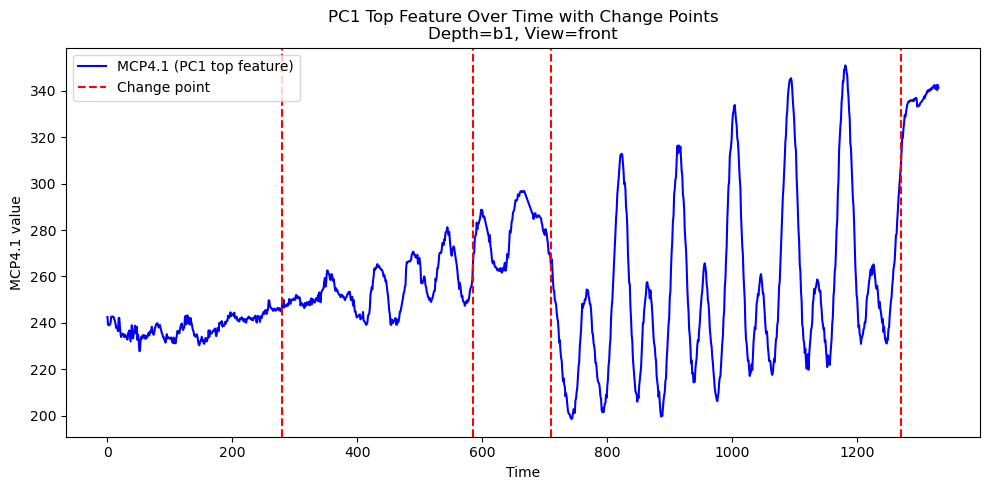

Change points (frame indices) for b1 front: [280, 585, 710, 1270, 1331]

Processing depth=b1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
1    b1  side       PC1    MCP3.1  0.261067    MCP4.1  0.260727    MCP5.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
1  0.258208      MCP4  0.256631    MCP2.1   0.25356  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
1    b1  side       PC2   fTip1.1  0.410647    MCP1.1  0.403156     fTip1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
1  0.398587      MCP1  0.398527  PalmBase  0.291886  


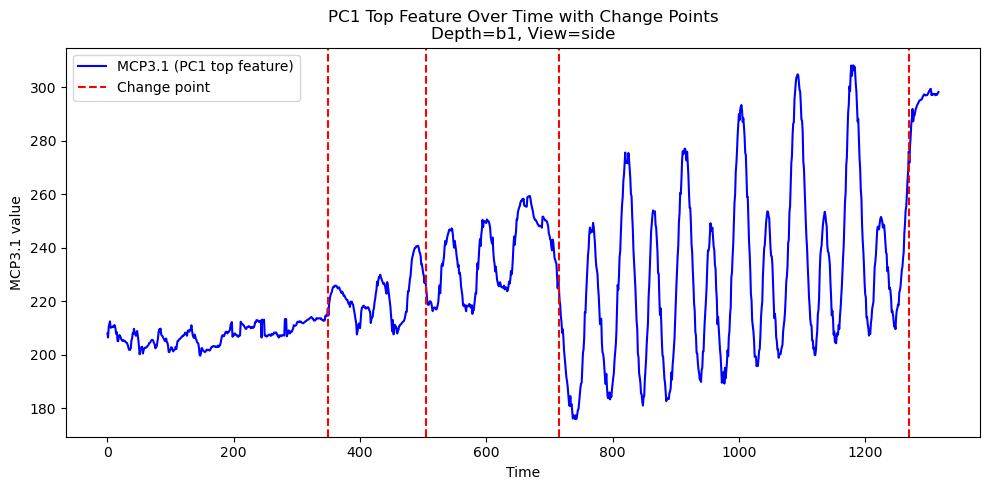

Change points (frame indices) for b1 side: [350, 505, 715, 1270, 1317]

Processing depth=b2, view=front
  depth   view component     feature_1  weight_1   feature_2  weight_2  \
2    b2  front       PC1  MidForeArm.1  0.218299  PalmBase.1   0.21723   

  feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
2    MCP2.1  0.216981   Elbow.1  0.216181      MCP4  0.215776  
  depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
2    b2  front       PC2  MidForeArm   0.58982     Elbow  0.340159      MCP2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
2 -0.286712   fTip3.1  0.239376     fTip5  0.236217  


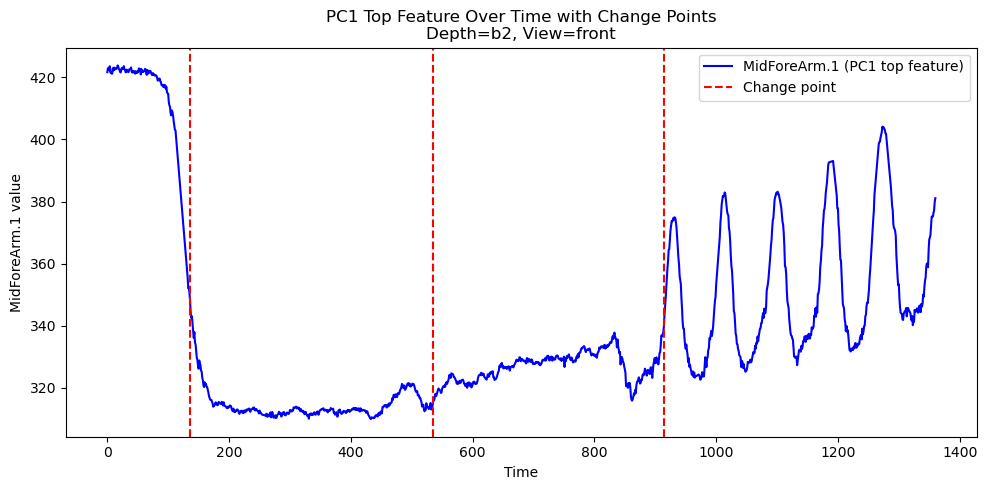

Change points (frame indices) for b2 front: [135, 535, 915, 1361]

Processing depth=b2, view=side
  depth  view component     feature_1  weight_1 feature_2  weight_2  \
3    b2  side       PC1  MidForeArm.1  0.250556    MCP2.1  0.250305   

    feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
3  PalmBase.1   0.24992    MCP3.1  0.248845    MCP4.1  0.246636  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
3    b2  side       PC2     fTip4  0.332962     fTip5  0.330474     fTip2   

   weight_3 feature_4  weight_4 feature_5  weight_5  
3  0.329001      MCP3  0.306733      MCP4    0.2987  


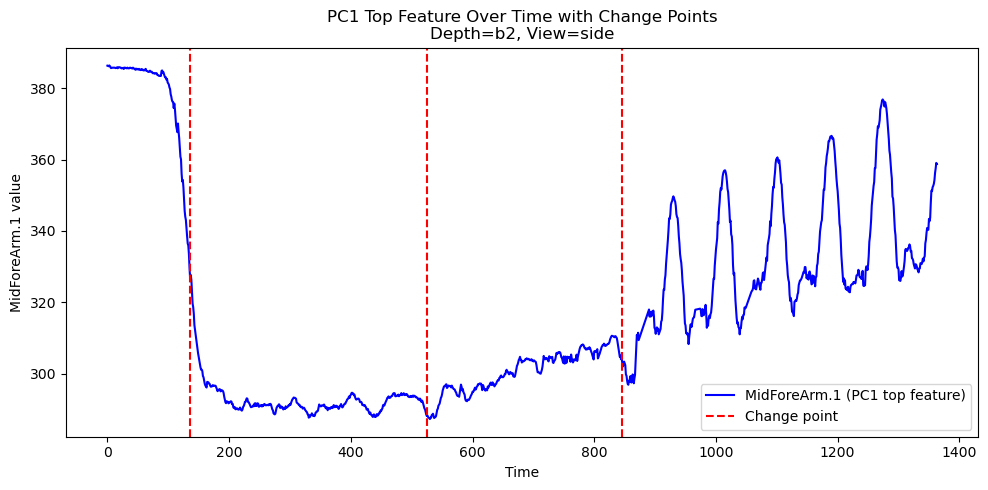

Change points (frame indices) for b2 side: [135, 525, 845, 1364]

Processing depth=b3, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
4    b3  front       PC1      MCP2  0.315122   fTip5.1  -0.31221    MCP4.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
4 -0.302603      MCP3  0.285905    MCP3.1 -0.259391  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
4    b3  front       PC2      MCP4  0.368935     fTip4    0.2977     fTip3   

   weight_3 feature_4  weight_4 feature_5  weight_5  
4  0.293448      MCP5  0.281345  PalmBase  0.271837  


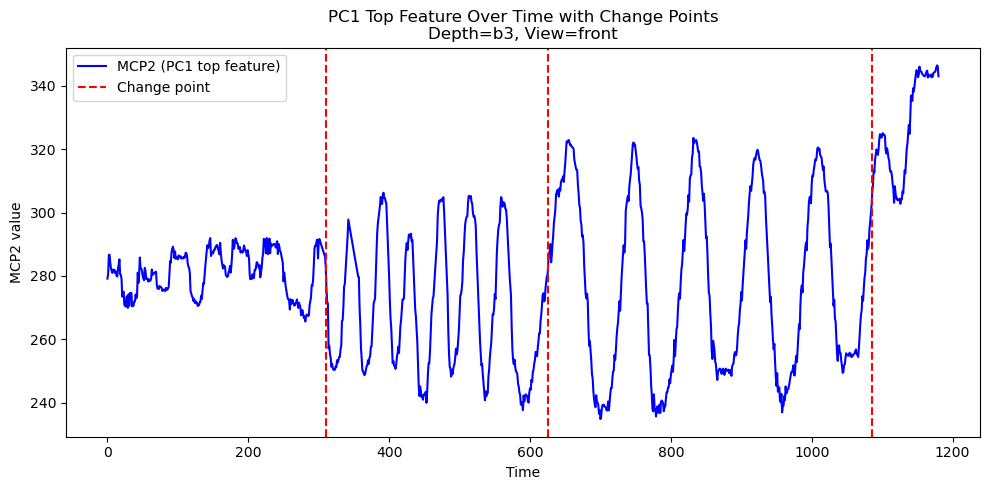

Change points (frame indices) for b3 front: [310, 625, 1085, 1181]

Processing depth=b3, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
5    b3  side       PC1      MCP4  0.294266      MCP5  0.288715     fTip5   

   weight_3 feature_4  weight_4 feature_5  weight_5  
5  0.280769      MCP3  0.278954    MCP4.1  0.275206  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
5    b3  side       PC2      MCP1  0.412184     fTip1  0.409773    MCP1.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
5  0.367171   fTip1.1  0.352386  PalmBase  0.304773  


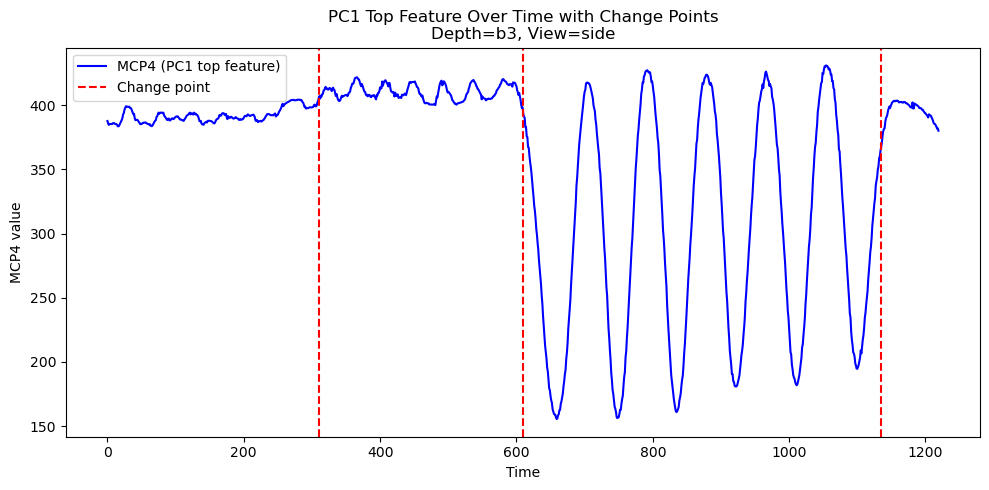

Change points (frame indices) for b3 side: [310, 610, 1135, 1220]

Processing depth=c1, view=front
  depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
6    c1  front       PC1  PalmBase.1  0.265863  PalmBase -0.265418    MCP2.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
6  0.264205    MCP3.1   0.26378    MCP4.1  0.261699  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
6    c1  front       PC2     fTip2  0.359992     fTip4  0.317365    MCP5.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
6   0.28313     fTip3  0.281385   fTip1.1   0.28007  


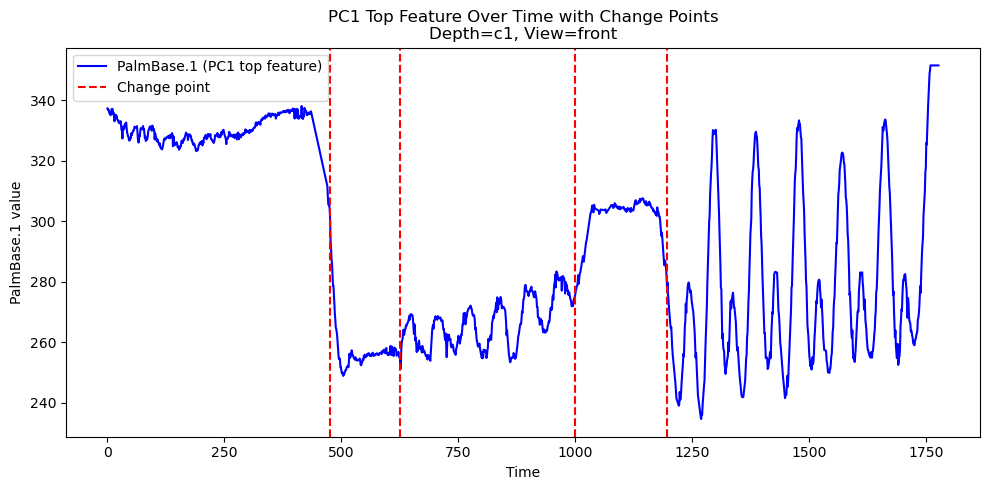

Change points (frame indices) for c1 front: [475, 625, 1000, 1195, 1777]

Processing depth=c1, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2     feature_3  \
7    c1  side       PC1   fTip1.1  0.259997    MCP2.1  0.259522  MidForeArm.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.256361   Elbow.1  0.254618    MCP3.1  0.250514  
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
7    c1  side       PC2     fTip2  0.366423     fTip3   0.36045  PalmBase   

   weight_3 feature_4  weight_4 feature_5  weight_5  
7  0.353888     fTip4  0.342152      MCP1   0.30672  


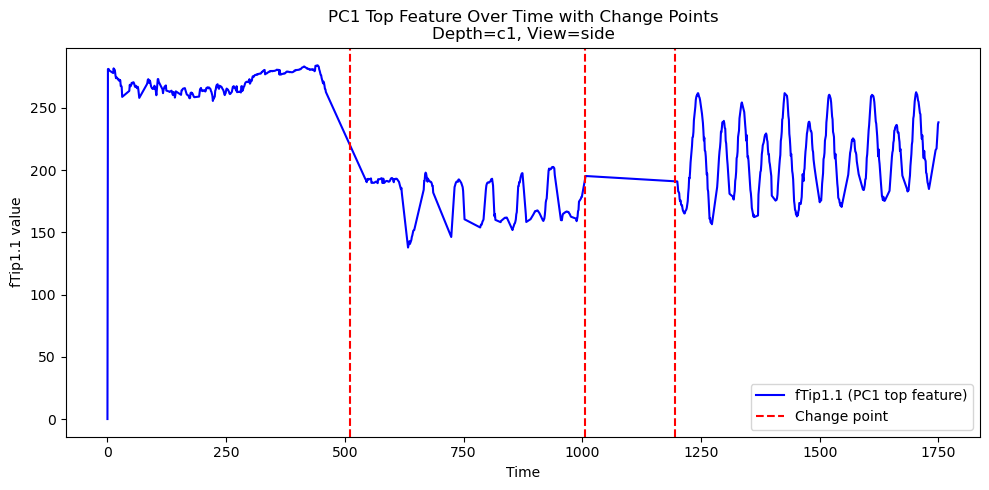

Change points (frame indices) for c1 side: [510, 1005, 1195, 1751]

Processing depth=c2, view=front
  depth   view component feature_1  weight_1 feature_2  weight_2   feature_3  \
8    c2  front       PC1    MCP1.1  0.214995      MCP5  0.213767  MidForeArm   

   weight_3 feature_4  weight_4 feature_5  weight_5  
8 -0.211422    MCP2.1  0.209099   fTip5.1  0.209053  
  depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
8    c2  front       PC2      MCP2  0.414004     fTip2  0.356176      MCP1   

   weight_3 feature_4  weight_4      feature_5  weight_5  
8  0.339827      MCP3  0.334787  StablePoint.1 -0.315541  


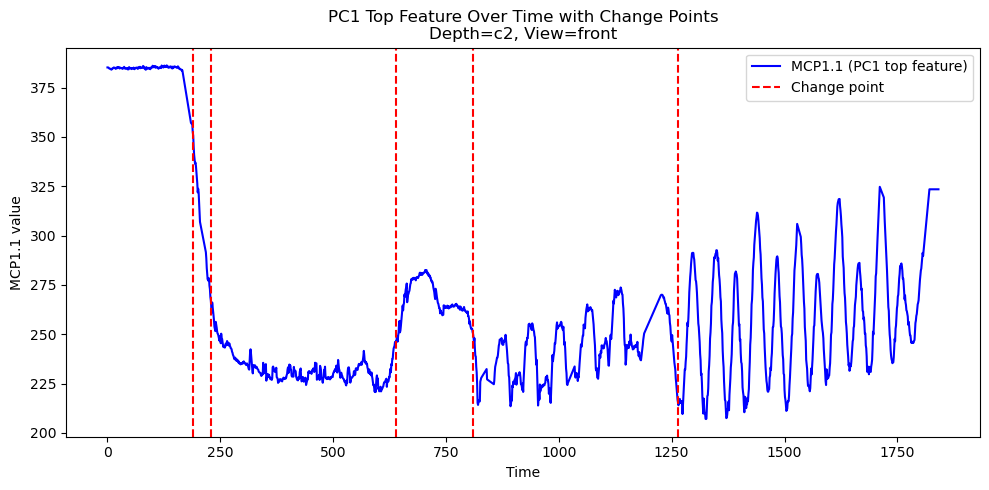

Change points (frame indices) for c2 front: [190, 230, 640, 810, 1265, 1842]

Processing depth=c2, view=side
  depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
9    c2  side       PC1    MCP2.1  0.220064    MCP5.1  0.219996    MCP3.1   

   weight_3 feature_4  weight_4   feature_5  weight_5  
9  0.219856    MCP4.1  0.219701  PalmBase.1  0.218045  
  depth  view component feature_1  weight_1 feature_2  weight_2  \
9    c2  side       PC2     Elbow  0.423515     fTip4  0.347962   

       feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
9  StablePoint.1   0.34077     fTip5  0.334442     fTip3  0.317377  


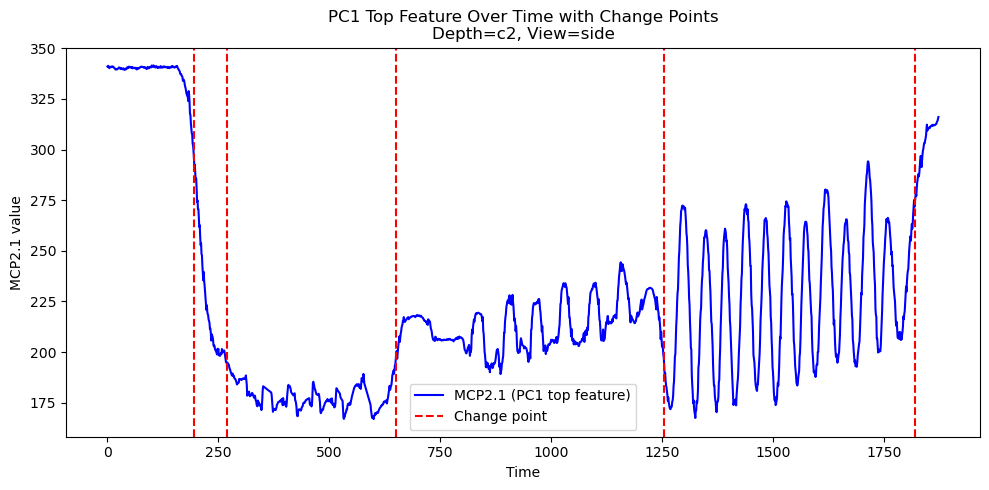

Change points (frame indices) for c2 side: [195, 270, 650, 1255, 1820, 1874]

Processing depth=c3, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC1    MCP1.1  0.218667  PalmBase  0.217235      MCP4   

    weight_3 feature_4  weight_4   feature_5  weight_5  
10  0.217006   fTip5.1  0.216892  PalmBase.1  0.216859  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
10    c3  front       PC2     Elbow   0.61468   Elbow.1  0.512228     fTip1   

    weight_3 feature_4  weight_4    feature_5  weight_5  
10  0.374924   fTip1.1    0.3003  StablePoint   0.17712  


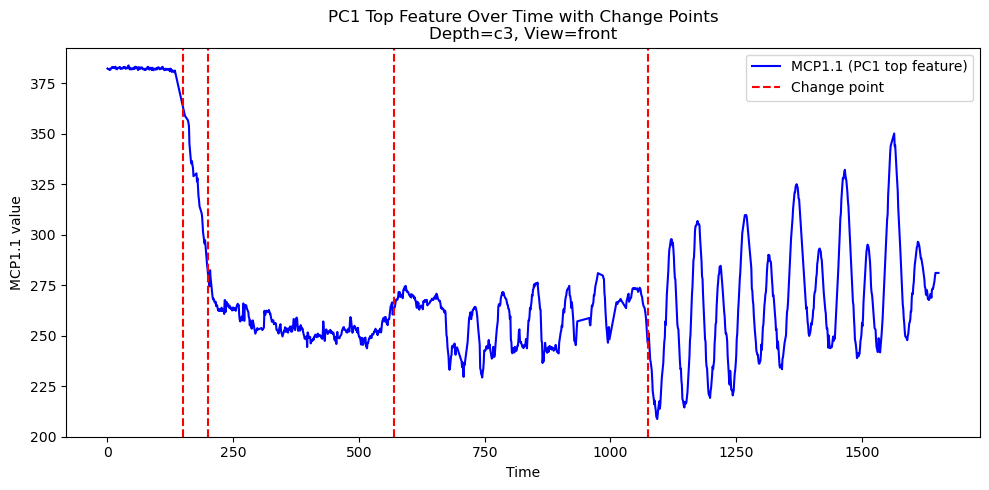

Change points (frame indices) for c3 front: [150, 200, 570, 1075, 1653]

Processing depth=c3, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
11    c3  side       PC1    MCP2.1  0.224382    MCP5.1  0.224173    MCP3.1   

    weight_3 feature_4  weight_4   feature_5  weight_5  
11  0.223987    MCP4.1  0.223488  PalmBase.1  0.223041  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
11    c3  side       PC2     fTip4  0.381724     fTip3  0.372809     fTip5   

    weight_3      feature_4  weight_4 feature_5  weight_5  
11   0.34967  StablePoint.1  0.320321     fTip2    0.3158  


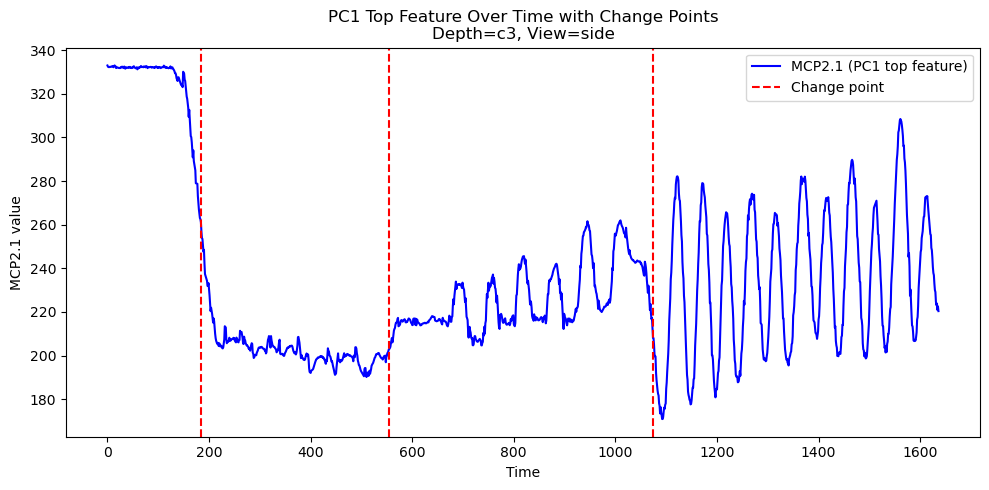

Change points (frame indices) for c3 side: [185, 555, 1075, 1637]

Processing depth=t1, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
12    t1  front       PC1    MCP3.1  0.221051    MCP2.1   0.22093   fTip1.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
12  0.220919     fTip4  0.219864      MCP5  0.219646  
   depth   view component feature_1  weight_1 feature_2  weight_2  \
12    t1  front       PC2   fTip5.1  0.533284     fTip5  0.477984   

      feature_3  weight_3      feature_4  weight_4   feature_5  weight_5  
12  StablePoint -0.401734  StablePoint.1 -0.400061  PalmBase.1  0.246309  


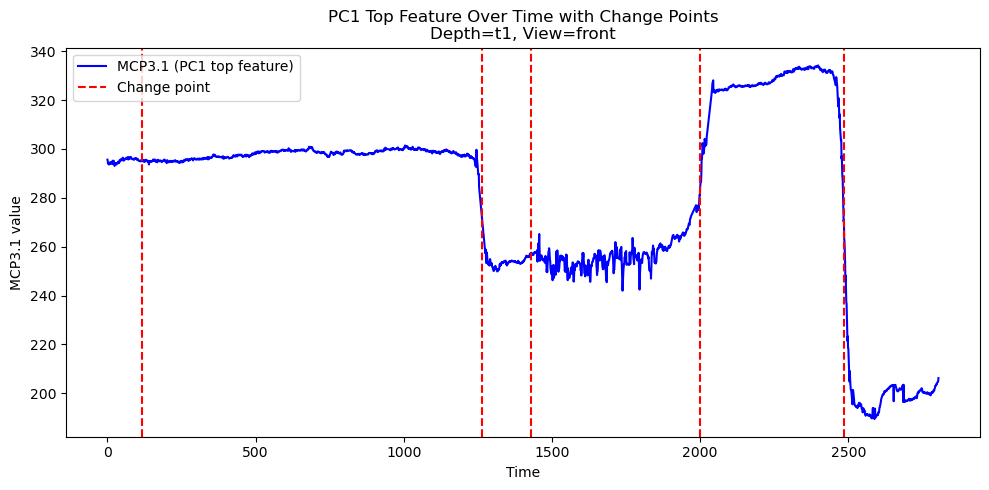

Change points (frame indices) for t1 front: [115, 1265, 1430, 2000, 2485, 2805]

Processing depth=t1, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
13    t1  side       PC1      MCP5  0.219805   fTip4.1  0.219516      MCP4   

    weight_3 feature_4  weight_4 feature_5  weight_5  
13  0.216827    MCP5.1  0.215782      MCP3   0.21363  
   depth  view component feature_1  weight_1     feature_2  weight_2  \
13    t1  side       PC2   Elbow.1  0.342701  MidForeArm.1  0.301461   

     feature_3  weight_3 feature_4  weight_4 feature_5  weight_5  
13  PalmBase.1  0.226887    MCP2.1  0.201787  PalmBase -0.201318  


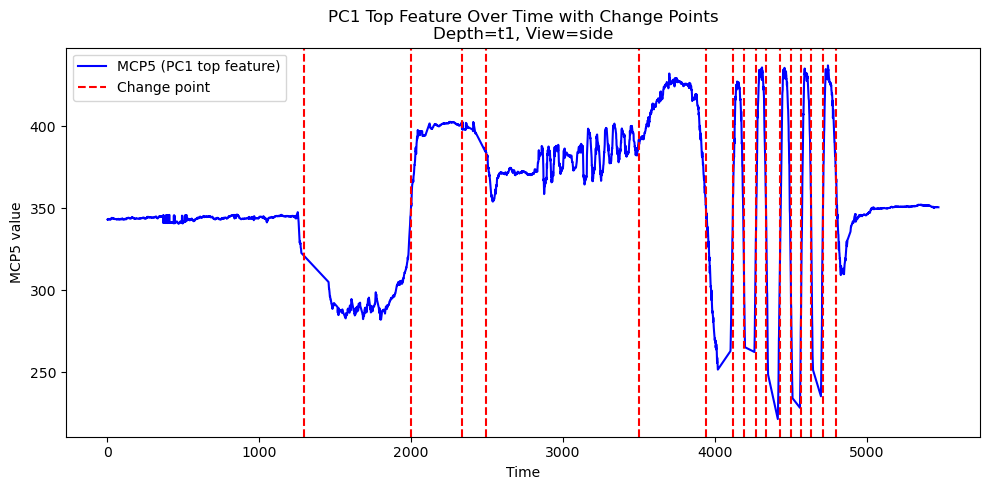

Change points (frame indices) for t1 side: [1295, 2000, 2335, 2495, 3500, 3940, 4120, 4190, 4270, 4340, 4430, 4500, 4570, 4635, 4710, 4795, 5474]

Processing depth=t2, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
14    t2  front       PC1  PalmBase  0.236575      MCP1  0.235947      MCP3   

    weight_3 feature_4  weight_4 feature_5  weight_5  
14  0.235897      MCP4  0.233854     fTip4   0.23374  
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
14    t2  front       PC2   fTip2.1  0.356333   fTip3.1  0.302757    MCP1.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
14  0.280379   fTip5.1  0.274681   fTip4.1  0.266428  


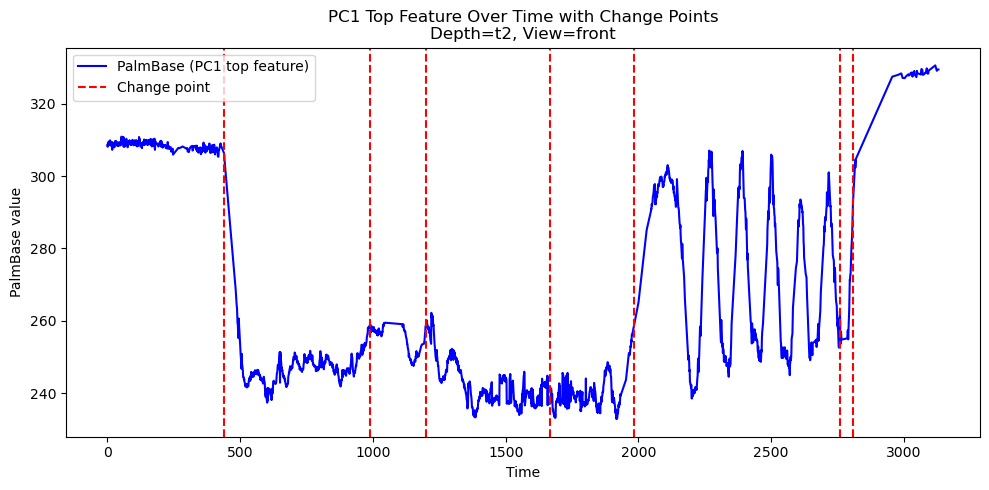

Change points (frame indices) for t2 front: [440, 990, 1200, 1665, 1985, 2760, 2810, 3131]

Processing depth=t2, view=side
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
15    t2  side       PC1     fTip4  0.263123     fTip3  0.262222     fTip2   

    weight_3 feature_4  weight_4 feature_5  weight_5  
15    0.2554     fTip5  0.252924      MCP3  0.235265  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
15    t2  side       PC2   fTip5.1  0.271755    MCP5.1  0.265484   fTip3.1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
15  0.262345   fTip4.1  0.260566    MCP4.1  0.249076  


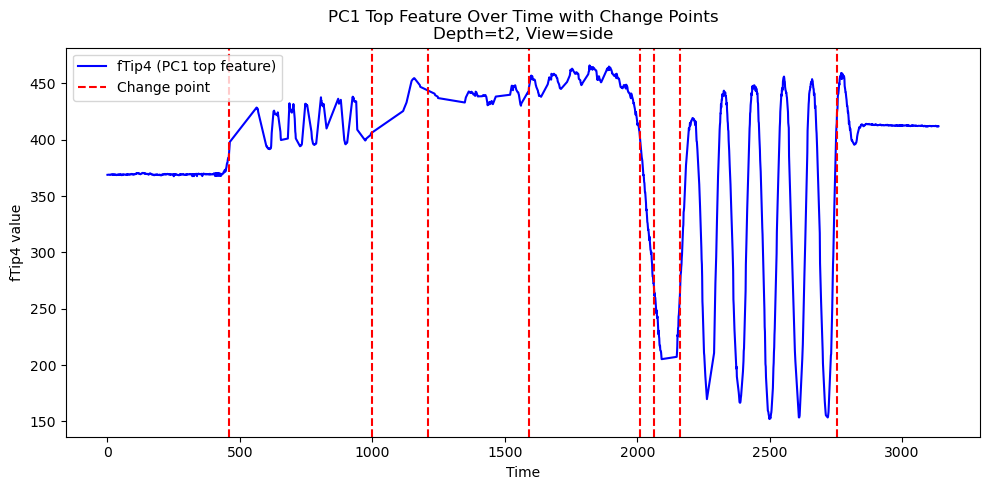

Change points (frame indices) for t2 side: [460, 1000, 1210, 1590, 2010, 2065, 2160, 2755, 3138]

Processing depth=t3, view=front
   depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
16    t3  front       PC1      MCP5  0.225735      MCP4  0.224261     fTip2   

    weight_3 feature_4  weight_4   feature_5  weight_5  
16  0.223756     fTip4  0.223361  MidForeArm -0.223088  
   depth   view component feature_1  weight_1   feature_2  weight_2 feature_3  \
16    t3  front       PC2    MCP1.1  0.546169  PalmBase.1  0.506904      MCP1   

    weight_3 feature_4  weight_4 feature_5  weight_5  
16  0.498386  PalmBase    0.3983     fTip5  0.078819  


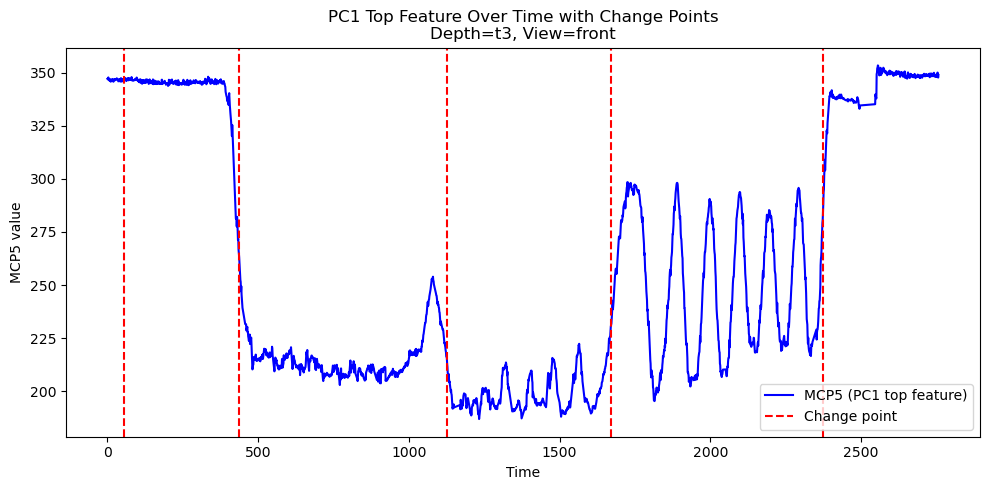

Change points (frame indices) for t3 front: [55, 435, 1125, 1670, 2375, 2758]

Processing depth=t3, view=side
   depth  view component feature_1  weight_1     feature_2  weight_2  \
17    t3  side       PC1     fTip3  0.239972  MidForeArm.1 -0.238638   

   feature_3  weight_3 feature_4  weight_4   feature_5  weight_5  
17  PalmBase  0.236226   Elbow.1 -0.231813  PalmBase.1  0.230945  
   depth  view component feature_1  weight_1 feature_2  weight_2 feature_3  \
17    t3  side       PC2      MCP4  0.394808      MCP3  0.378816      MCP5   

    weight_3 feature_4  weight_4 feature_5  weight_5  
17  0.335074     fTip5  0.328112     fTip4  0.314635  


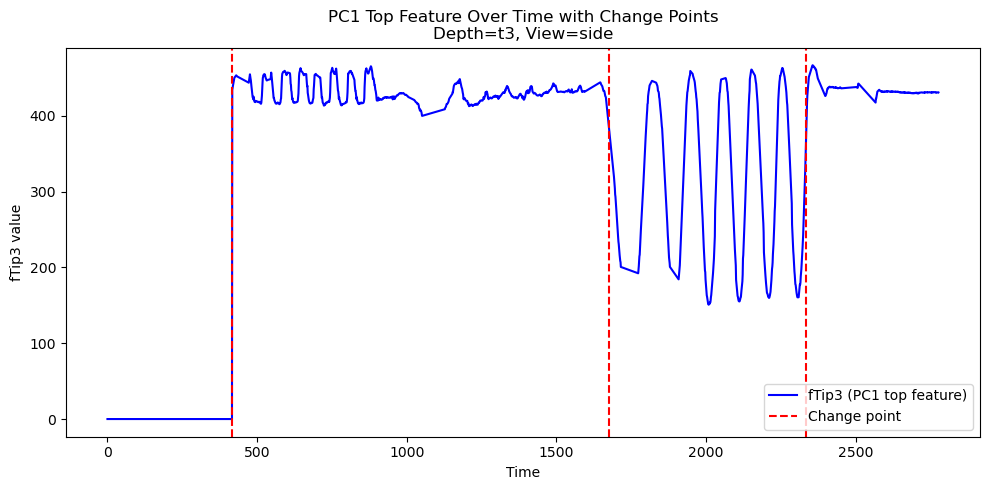

Change points (frame indices) for t3 side: [415, 1675, 2335, 2777]


depth   view component     feature_1   feature_2  \
0     b1  front   indices        MCP4.1      MCP1.1   
1     b1   side   indices        MCP3.1     fTip1.1   
2     b2  front   indices  MidForeArm.1  MidForeArm   
3     b2   side   indices  MidForeArm.1       fTip4   
4     b3  front   indices          MCP2        MCP4   
5     b3   side   indices          MCP4        MCP1   
6     c1  front   indices    PalmBase.1       fTip2   
7     c1   side   indices       fTip1.1       fTip2   
8     c2  front   indices        MCP1.1        MCP2   
9     c2   side   indices        MCP2.1       Elbow   
10    c3  front   indices        MCP1.1       Elbow   
11    c3   side   indices        MCP2.1       fTip4   
12    t1  front   indices        MCP3.1     fTip5.1   
13    t1   side   indices          MCP5     Elbow.1   
14    t2  front   indices      PalmBase     fTip2.1   
15    t2   side   indices         fTip4     fTip5.1   
16    t3  front   indices          MCP5      MCP1.1   
17    t3   side   indices         fTip3        MCP4   

                                        change_points  
0                         [280, 585, 710, 1270, 1331]  
1                         [350, 505, 715, 1270, 1317]  
2                               [135, 535, 915, 1361]  
3                               [135, 525, 845, 1364]  
4                              [310, 625, 1085, 1181]  
5                              [310, 610, 1135, 1220]  
6                        [475, 625, 1000, 1195, 1777]  
7                             [510, 1005, 1195, 1751]  
8                    [190, 230, 640, 810, 1265, 1842]  
9                   [195, 270, 650, 1255, 1820, 1874]  
10                        [150, 200, 570, 1075, 1653]  
11                             [185, 555, 1075, 1637]  
12                [115, 1265, 1430, 2000, 2485, 2805]  
13  [1295, 2000, 2335, 2495, 3500, 3940, 4120, 419...  
14     [440, 990, 1200, 1665, 1985, 2760, 2810, 3131]  
15  [460, 1000, 1210, 1590, 2010, 2065, 2160, 2755...  
16                  [55, 435, 1125, 1670, 2375, 2758]  
17                            [415, 1675, 2335, 2777]

In [363]:
results_list2 = []

# Parameters for ruptures
model = "rbf"
penalty_value = 30  # Adjust as needed

# creates new column for new change points
if 'cp_handOC_handPS' not in df_indices.columns:
    df_indices['cp_handOC_handPS'] = None
    df_indices['cp_handOC_handPS'] = df_indices['cp_handOC_handPS'].astype(object)


for depth in depths:
    for view in views:
        print(f"\nProcessing depth={depth}, view={view}")

        # Get top PC1 and PC2 features
        top_feature_pc1 = get_top_feature(top5_start_pc1_df, depth, view, 'PC1')
        top_feature_pc2 = get_top_feature(top5_start_pc2_df, depth, view, 'PC2')

        if top_feature_pc1 is None or top_feature_pc2 is None:
            print(f"Skipping {depth} {view} - missing top features")
            continue

        df_key = depth + ('f' if view == 'front' else 's')
        if df_key not in dataframes:
            print(f"Data for {df_key} not found in dataframes.")
            continue

        df = dataframes[df_key]

        if top_feature_pc1 not in df.columns or top_feature_pc2 not in df.columns:
            print(f"Features {top_feature_pc1} or {top_feature_pc2} not found in dataframe for {df_key}")
            continue

        # Extract data
        x = df[top_feature_pc1].to_numpy()
        y = df[top_feature_pc2].to_numpy()
        t = np.arange(len(x))

        # Stack for ruptures input
        signal = np.column_stack((x, y))  # shape (n_samples, 2)

        # Run RBF change point detection
        algo = rpt.Pelt(model=model).fit(signal)
        change_points = algo.predict(pen=penalty_value)



        # Inside the nested loop after change_points are computed
        plt.figure(figsize=(10, 5))
        plt.plot(t, x, label=f"{top_feature_pc1} (PC1 top feature)", color='blue')
        for cp in change_points[:-1]:  # Skip the last point if it's just the end of signal
            plt.axvline(x=cp, color='red', linestyle='--', label='Change point' if cp == change_points[0] else "")
        plt.xlabel("Time")
        plt.ylabel(f"{top_feature_pc1} value")
        plt.title(f"PC1 Top Feature Over Time with Change Points\nDepth={depth}, View={view}")
        plt.legend()
        plt.tight_layout()
        plt.show()




        # Print results
        print(f"Change points (frame indices) for {depth} {view}: {change_points}")

        # Create a dictionary for storing change point results
        dic_indices2 = {
            "depth": depth,
            "view": view,
            "component": "indices"
        }

        # Save the top features and their change points
        dic_indices2["feature_1"] = top_feature_pc1
        dic_indices2["feature_2"] = top_feature_pc2
        dic_indices2["change_points"] = change_points

        # Assuming you're collecting multiple such dictionaries into a list
        results_list2.append(dic_indices2)

df_indices2 = pd.DataFrame(results_list2)

df_indices2 


## Segment

In [ ]:
# run through df_movements, df_indices, df_indices2 at the same time

    # set armEF_start = indice[0] from df_movement
    # cp_list_beg = indices/cp from the df_indices2
    # cp_list_all = cp from 

    # get rid of any points in the lists that are equal or after the arm_EF_start

    # average the points within 100 of one another within cp_list_beg

    # compare the points to the ruptures of the overall PCA
    # so compare cp_list_beg and cp_list_all

    # graph the points in common and the armEF segment
    # create new list of points in common of within 100 of each other from the two lists as well as the indices from the armEF indices one from df_movements and then i want to graph it on the 
    # x = df[top_feature_pc1].to_numpy() 

In [384]:
print(df_movements)


   dataset   view        arm_EF hand_OC hand_PS
0       b1  front   (715, 1298)  (0, 0)  (0, 0)
1       b1   side   (720, 1291)  (0, 0)  (0, 0)
2       b2  front   (845, 1361)  (0, 0)  (0, 0)
3       b2   side   (845, 1364)  (0, 0)  (0, 0)
4       b3  front   (615, 1158)  (0, 0)  (0, 0)
5       b3   side   (620, 1177)  (0, 0)  (0, 0)
6       c1  front  (1195, 1777)  (0, 0)  (0, 0)
7       c1   side  (1200, 1751)  (0, 0)  (0, 0)
8       c2  front  (1260, 1842)  (0, 0)  (0, 0)
9       c2   side  (1260, 1839)  (0, 0)  (0, 0)
10      c3  front  (1085, 1653)  (0, 0)  (0, 0)
11      c3   side  (1080, 1637)  (0, 0)  (0, 0)
12      t1  front  (1995, 2485)  (0, 0)  (0, 0)
13      t1   side  (4750, 5474)  (0, 0)  (0, 0)
14      t2  front  (2025, 2760)  (0, 0)  (0, 0)
15      t2   side  (2155, 2755)  (0, 0)  (0, 0)
16      t3  front  (1665, 2350)  (0, 0)  (0, 0)
17      t3   side  (1675, 2340)  (0, 0)  (0, 0)


[280, 585, 710, 1270, 1331]
[475, 715, 1265, 1331]


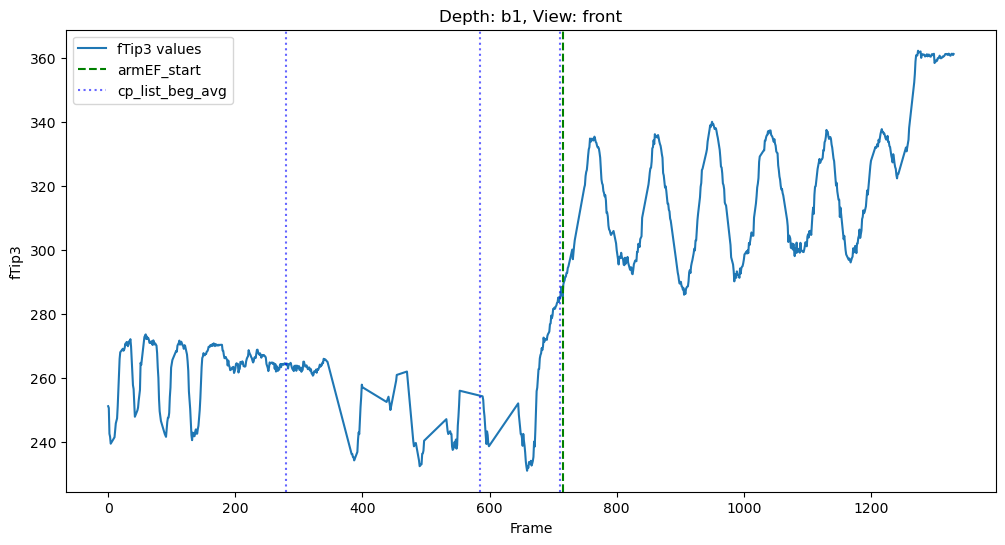

[350, 505, 715, 1270, 1317]
[480, 720, 1265, 1317]


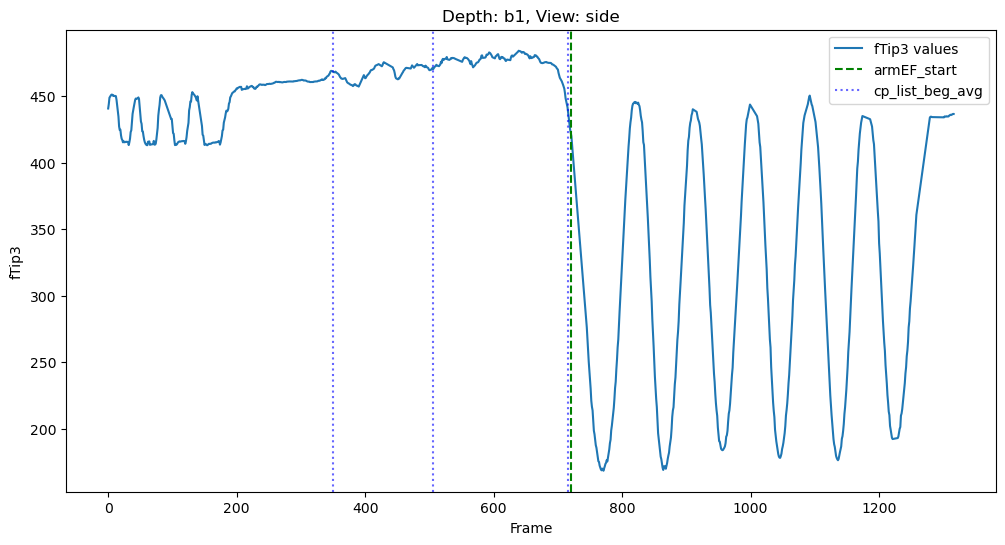

[135, 535, 915, 1361]
[140, 560, 845, 1361]


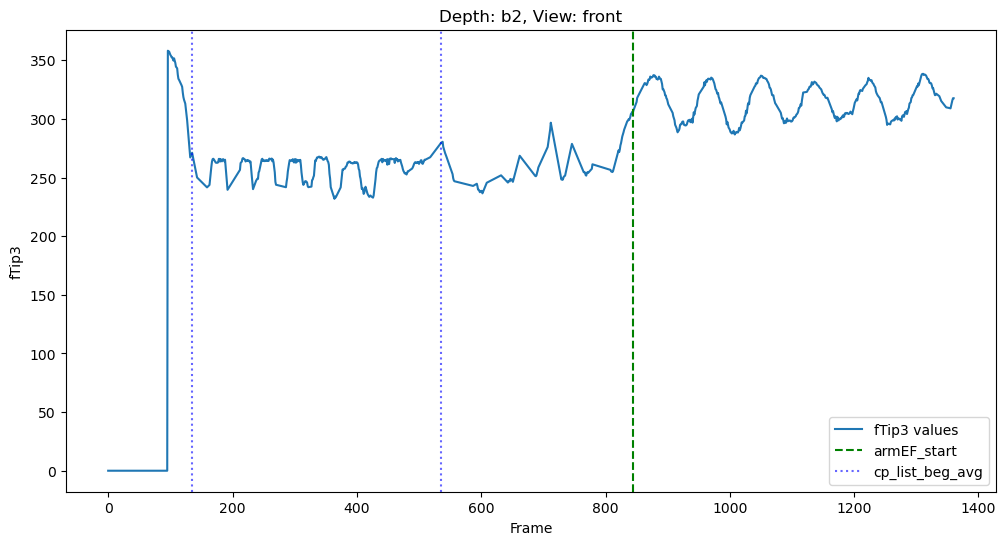

[135, 525, 845, 1364]
[130, 540, 845, 1364]


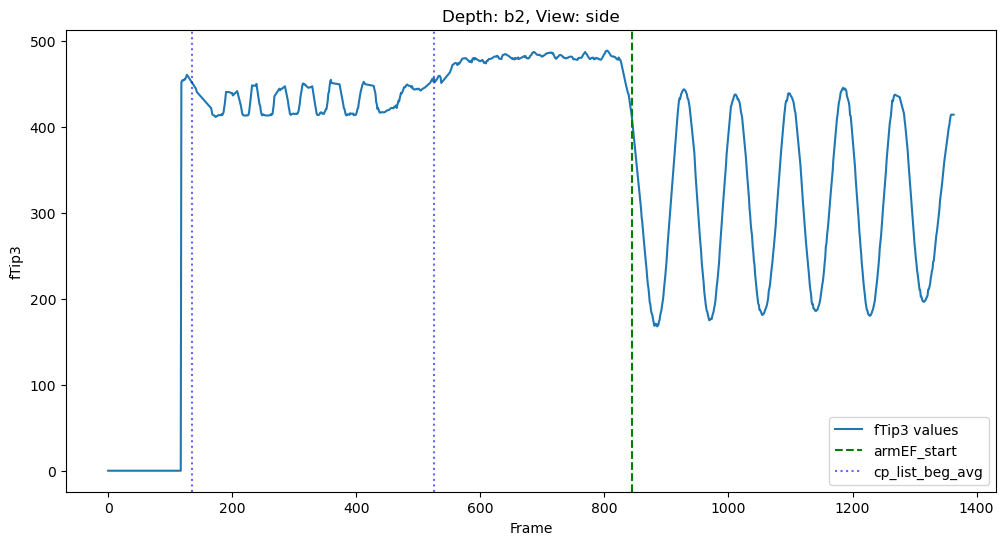

[310, 625, 1085, 1181]
[230, 615, 1135, 1181]


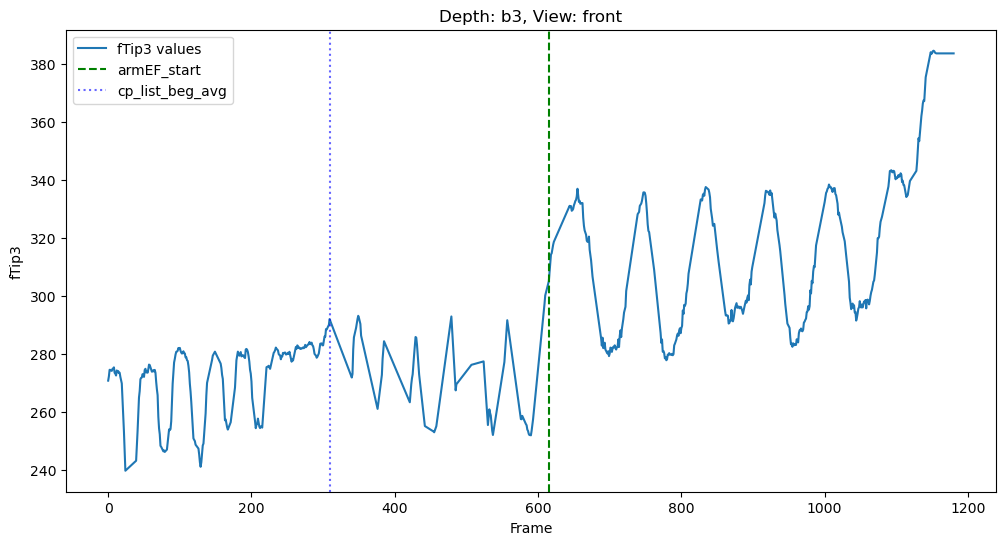

[310, 610, 1135, 1220]
[620, 1135, 1220]


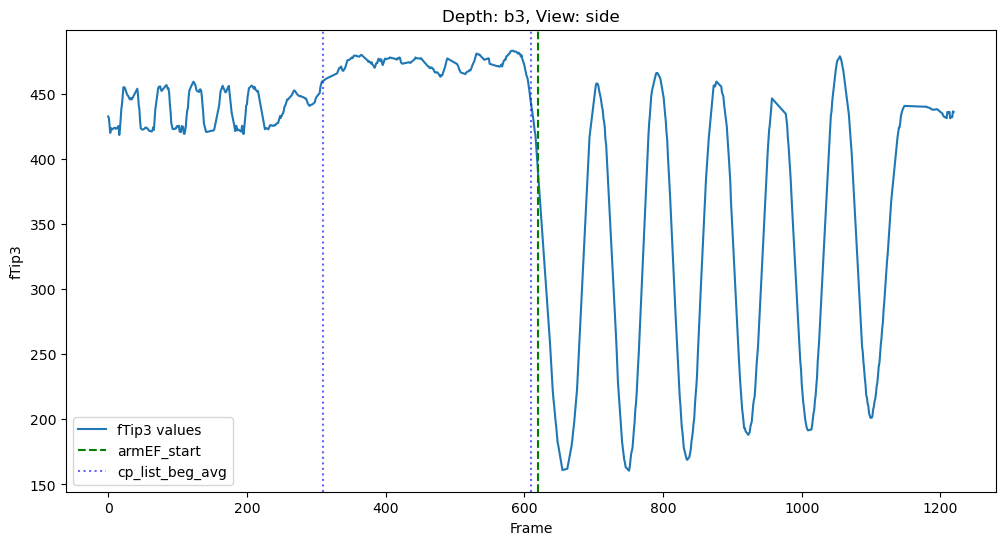

[475, 625, 1000, 1195, 1777]
[475, 625, 1000, 1195, 1777]


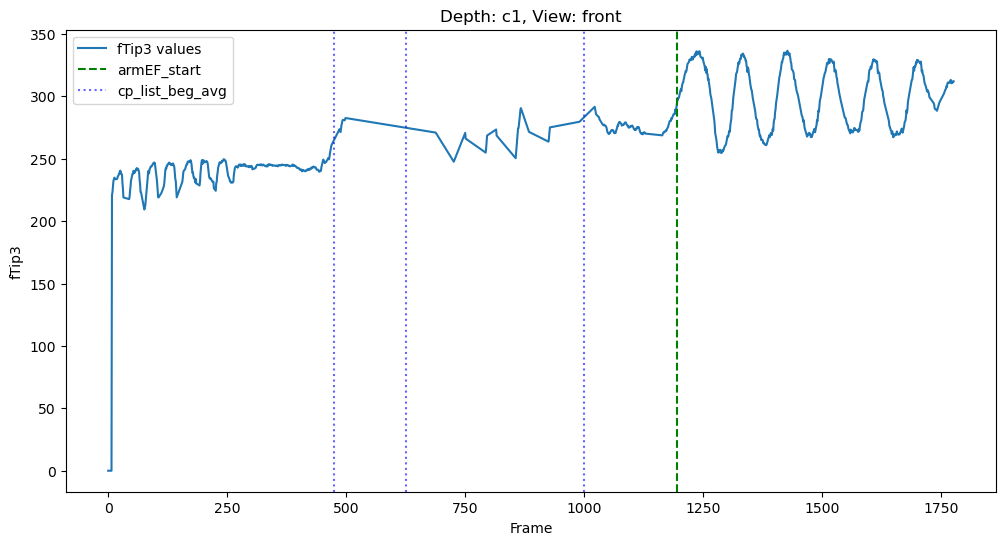

[510, 1005, 1195, 1751]
[495, 1015, 1200, 1751]


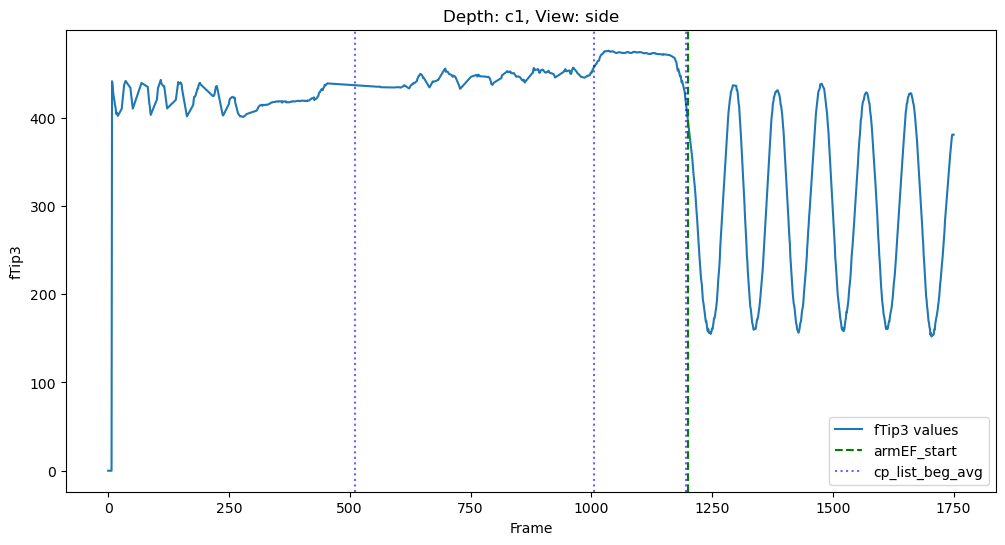

[190, 230, 640, 810, 1265, 1842]
[190, 235, 645, 800, 1260, 1842]


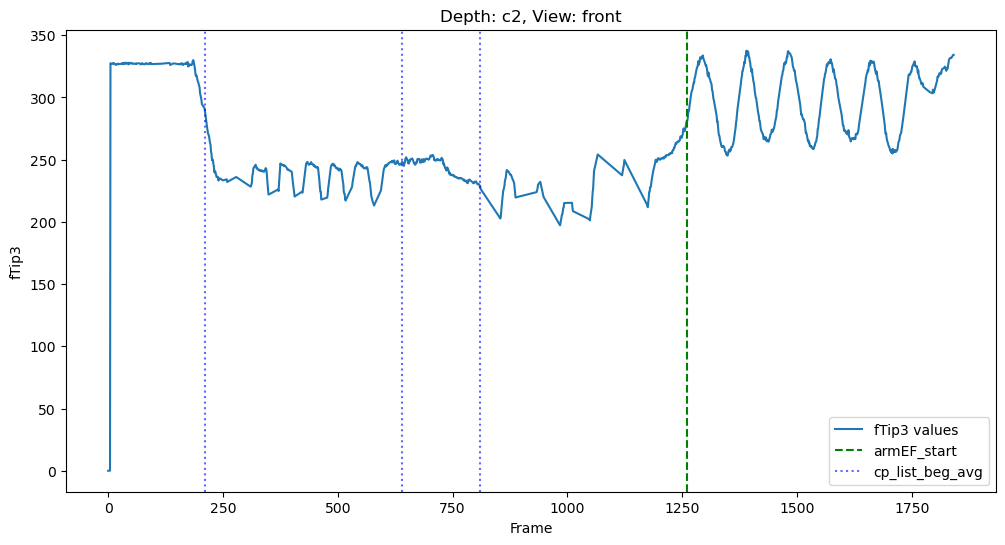

[195, 270, 650, 1255, 1820, 1874]
[170, 225, 655, 1260, 1805, 1874]


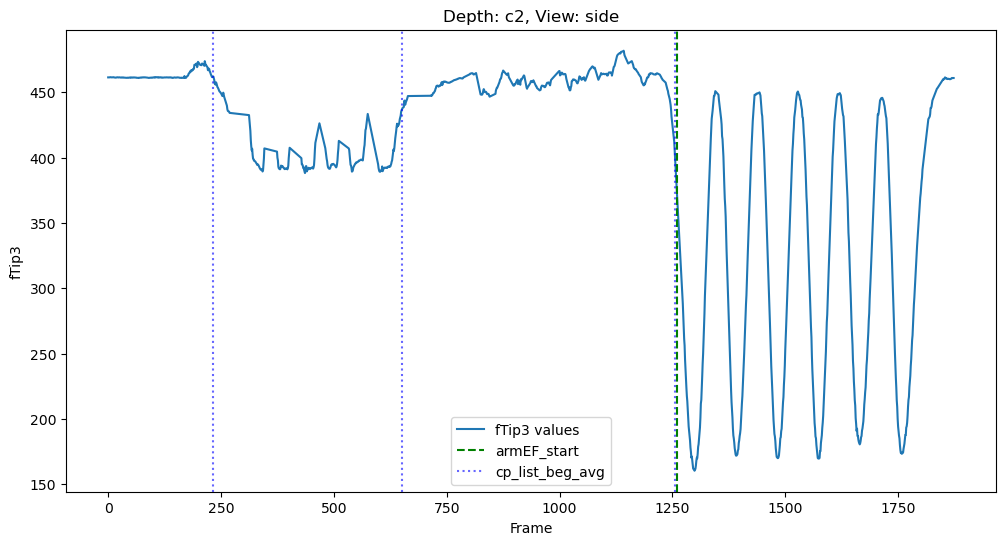

[150, 200, 570, 1075, 1653]
[160, 200, 1085, 1653]


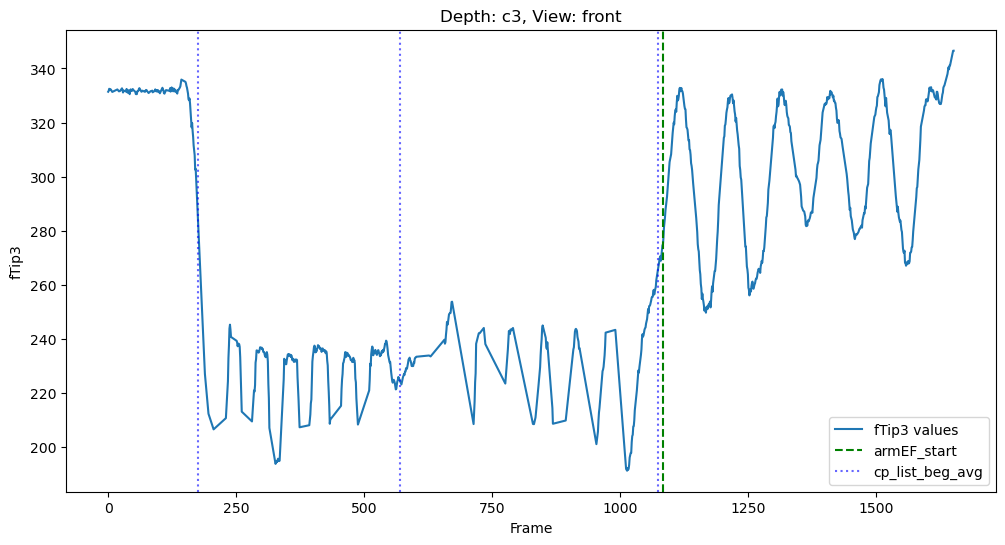

[185, 555, 1075, 1637]
[130, 180, 1080, 1637]


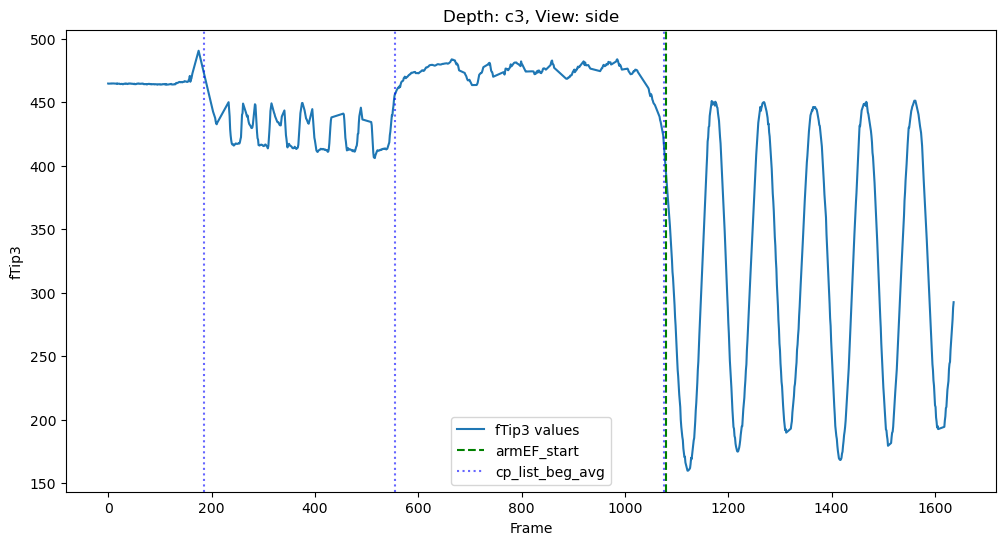

[115, 1265, 1430, 2000, 2485, 2805]
[115, 1270, 1425, 1995, 2485, 2805]


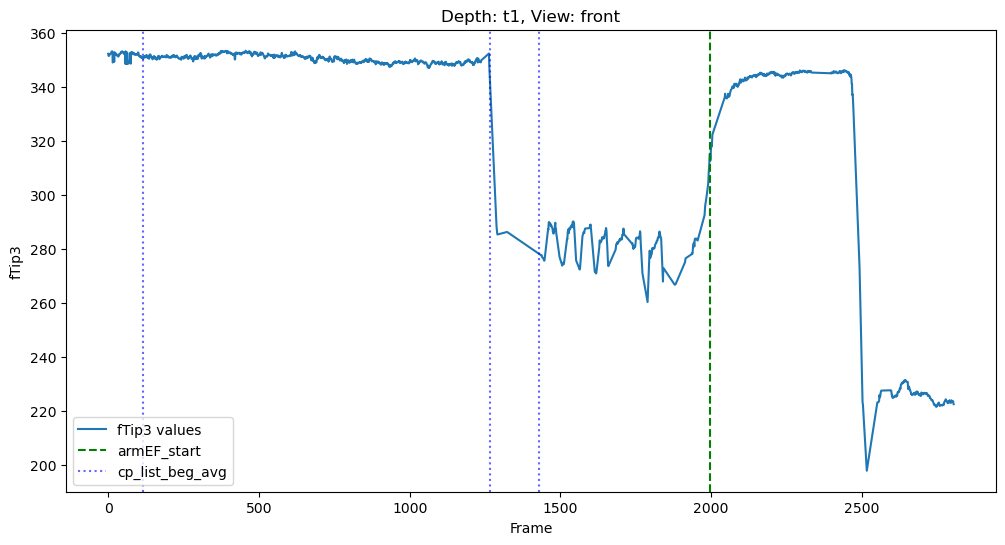

[1295, 2000, 2335, 2495, 3500, 3940, 4120, 4190, 4270, 4340, 4430, 4500, 4570, 4635, 4710, 4795, 5474]
[1260, 1990, 2365, 2545, 2735, 3010, 3535, 3640, 3890, 3960, 4725, 4775, 5474]


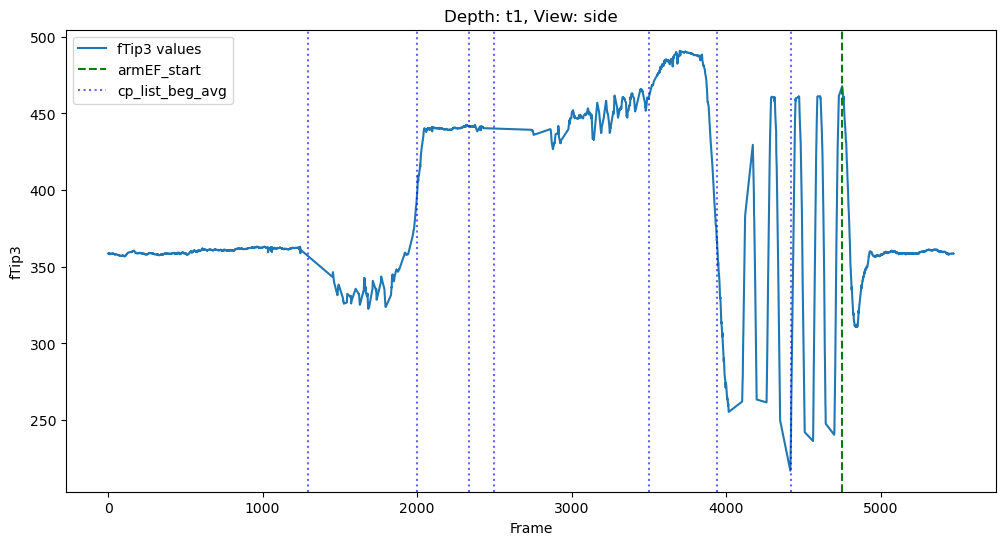

[440, 990, 1200, 1665, 1985, 2760, 2810, 3131]
[455, 1005, 1210, 1650, 2025, 2760, 3131]


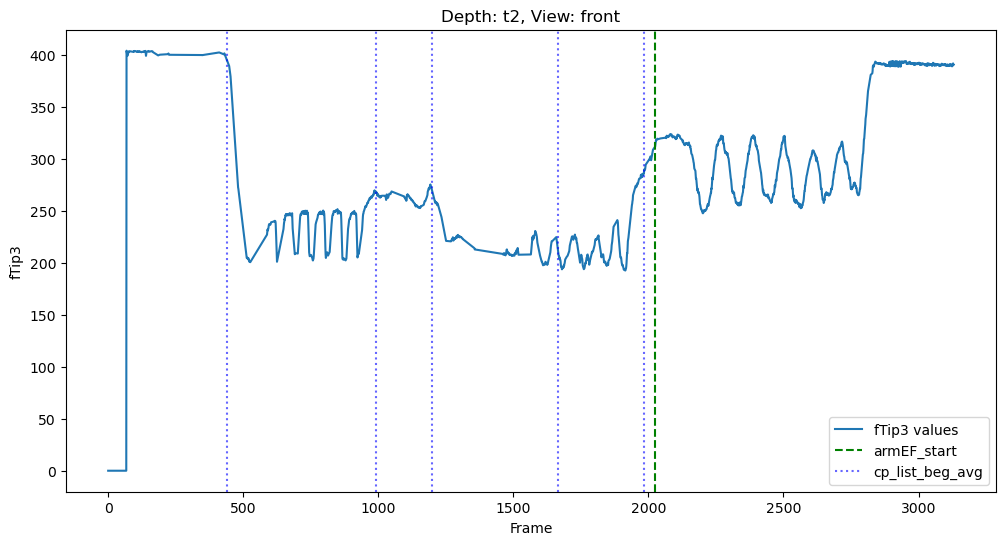

[460, 1000, 1210, 1590, 2010, 2065, 2160, 2755, 3138]
[465, 1015, 1205, 1665, 2020, 2075, 2155, 2755, 3138]


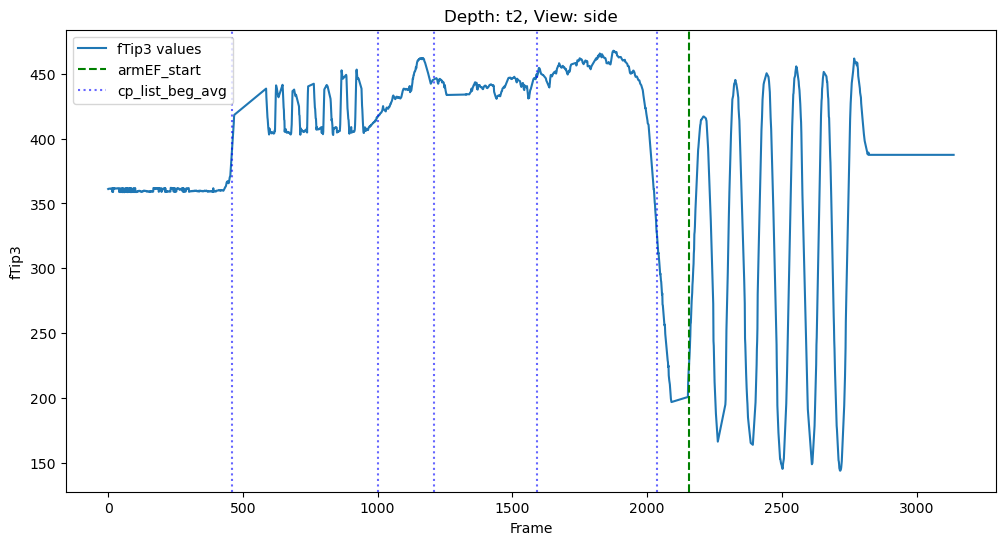

[55, 435, 1125, 1670, 2375, 2758]
[385, 435, 1140, 1665, 2330, 2370, 2758]


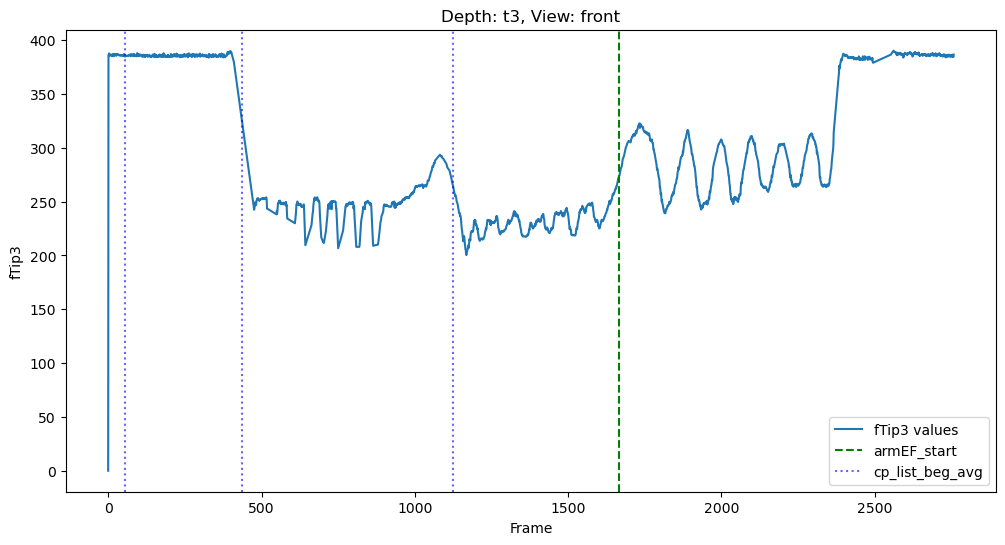

[415, 1675, 2335, 2777]
[415, 1675, 2340, 2777]


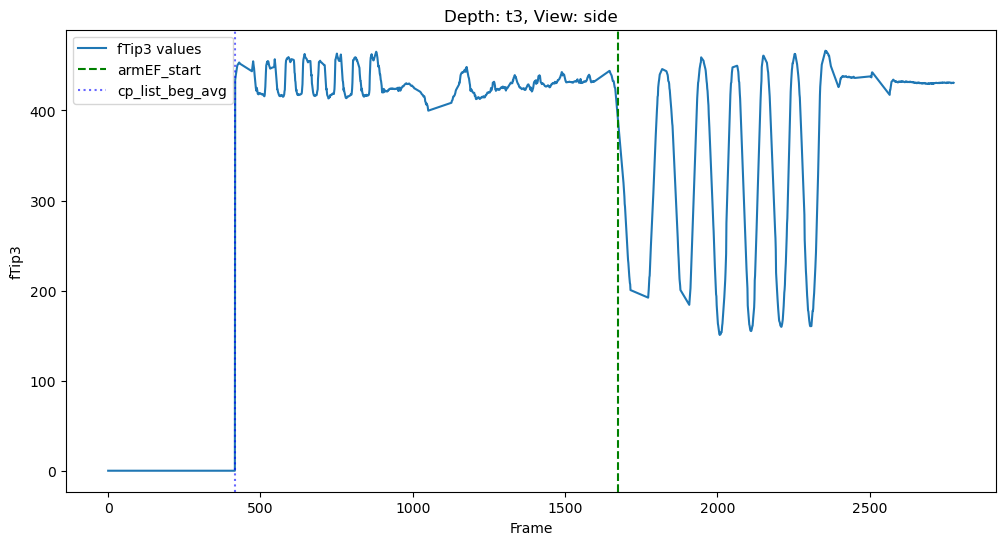

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def average_close_points(points, threshold=100):
    """Average points that are within threshold of each other."""
    points = sorted(points)
    averaged = []
    cluster = [points[0]]
    for p in points[1:]:
        if p - cluster[-1] <= threshold:
            cluster.append(p)
        else:
            averaged.append(int(np.mean(cluster)))
            cluster = [p]
    averaged.append(int(np.mean(cluster)))
    return averaged

for idx, (depth, view) in enumerate(zip(df_movements['dataset'], df_movements['view'])):
    
    armEF_start = df_movements.iloc[idx]['arm_EF'][0]  # First value of the tuple

    
    # Get cp lists from df_indices2 and df_indices (or wherever cp_list_all is)
    cp_list_beg = df_indices2.loc[
        (df_indices2['depth'] == depth) & (df_indices2['view'] == view), 'change_points'
    ].values
    if len(cp_list_beg) == 0:
        continue
    cp_list_beg = cp_list_beg[0]  # assuming it's a list stored in a cell

    print(cp_list_beg)
    
    cp_list_all = df_indices.loc[
        (df_indices['depth'] == depth) & (df_indices['view'] == view), 'change_points'
    ].values
    if len(cp_list_all) == 0:
        continue
    cp_list_all = cp_list_all[0]  # assuming list stored in cell

    print(cp_list_all)
    
    # Remove points >= armEF_start
    cp_list_beg_filtered = [pt for pt in cp_list_beg if pt < armEF_start]
    cp_list_all_filtered = [pt for pt in cp_list_all if pt < armEF_start]
    
    # Average points within 100 in cp_list_beg
    cp_list_beg_avg = average_close_points(cp_list_beg_filtered, threshold=100)

    # Find the row index in df_movements for the current depth and view
    row_idx = df_movements[
        (df_movements['dataset'] == depth) & 
        (df_movements['view'] == view)
    ].index

    if not row_idx.empty:
        row_idx = row_idx[0]  # Get the actual index value

        # I want to add soemthing here that says if the difference between the max and min is less than 10 or 20 or something then we need to move to the next indice

        if cp_list_beg_avg[0] < 250:
            # Update hand_OC and hand_PS columns directly
            df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[0], cp_list_beg_avg[1])
            df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[1], armEF_start)
        else:
            df_movements.at[row_idx, 'hand_OC'] = (0, cp_list_beg_avg[0])
            df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[0], armEF_start)

    else:
        print(f"Row not found for dataset={depth}, view={view}")


    
    # Find common points between cp_list_beg_avg and cp_list_all_filtered within 100 units
    common_points = []
    for pt1 in cp_list_beg_avg:
        for pt2 in cp_list_all_filtered:
            if abs(pt1 - pt2) <= 100:
                common_points.append(int((pt1 + pt2) / 2))
                break
                
    common_points = sorted(set(common_points))
    
    # Get your dataframe with top PC1 feature for this depth & view
    df_key = depth + ('f' if view == 'front' else 's')
    if df_key not in dataframes:
        print(f"Missing df for {df_key}")
        continue
    df = dataframes[df_key]
    
    x = df[top_feature_pc1].to_numpy()
    t = np.arange(len(x))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(t, x, label=f"{top_feature_pc1} values")
    
    # Plot armEF_start as vertical line
    plt.axvline(armEF_start, color='green', linestyle='--', label='armEF_start')
    
    # Plot change points
    for cp in cp_list_beg_avg:
        plt.axvline(cp, color='blue', linestyle=':', alpha=0.6, label='cp_list_beg_avg' if cp == cp_list_beg_avg[0] else "")
    '''
    for cp in cp_list_all_filtered:
        plt.axvline(cp, color='orange', linestyle=':', alpha=0.6, label='cp_list_all_filtered' if cp == cp_list_all_filtered[0] else "")
    for cp in common_points:
        plt.axvline(cp, color='red', linestyle='-', linewidth=2, label='common_points' if cp == common_points[0] else "")

    '''
    
    plt.title(f"Depth: {depth}, View: {view}")
    plt.xlabel('Frame')
    plt.ylabel(f'{top_feature_pc1}')
    plt.legend()
    plt.show()


In [388]:
df_movements

dataset   view        arm_EF      hand_OC       hand_PS
0       b1  front   (715, 1298)     (0, 280)    (280, 715)
1       b1   side   (720, 1291)     (0, 350)    (350, 720)
2       b2  front   (845, 1361)   (135, 535)    (535, 845)
3       b2   side   (845, 1364)   (135, 525)    (525, 845)
4       b3  front   (615, 1158)     (0, 310)    (310, 615)
5       b3   side   (620, 1177)     (0, 310)    (310, 620)
6       c1  front  (1195, 1777)     (0, 475)   (475, 1195)
7       c1   side  (1200, 1751)     (0, 510)   (510, 1200)
8       c2  front  (1260, 1842)   (210, 640)   (640, 1260)
9       c2   side  (1260, 1839)   (232, 650)   (650, 1260)
10      c3  front  (1085, 1653)   (175, 570)   (570, 1085)
11      c3   side  (1080, 1637)   (185, 555)   (555, 1080)
12      t1  front  (1995, 2485)  (115, 1265)  (1265, 1995)
13      t1   side  (4750, 5474)    (0, 1295)  (1295, 4750)
14      t2  front  (2025, 2760)     (0, 440)   (440, 2025)
15      t2   side  (2155, 2755)     (0, 460)   (460, 2155)
16      t3  front  (1665, 2350)    (55, 435)   (435, 1665)
17      t3   side  (1675, 2340)     (0, 415)   (415, 1675)

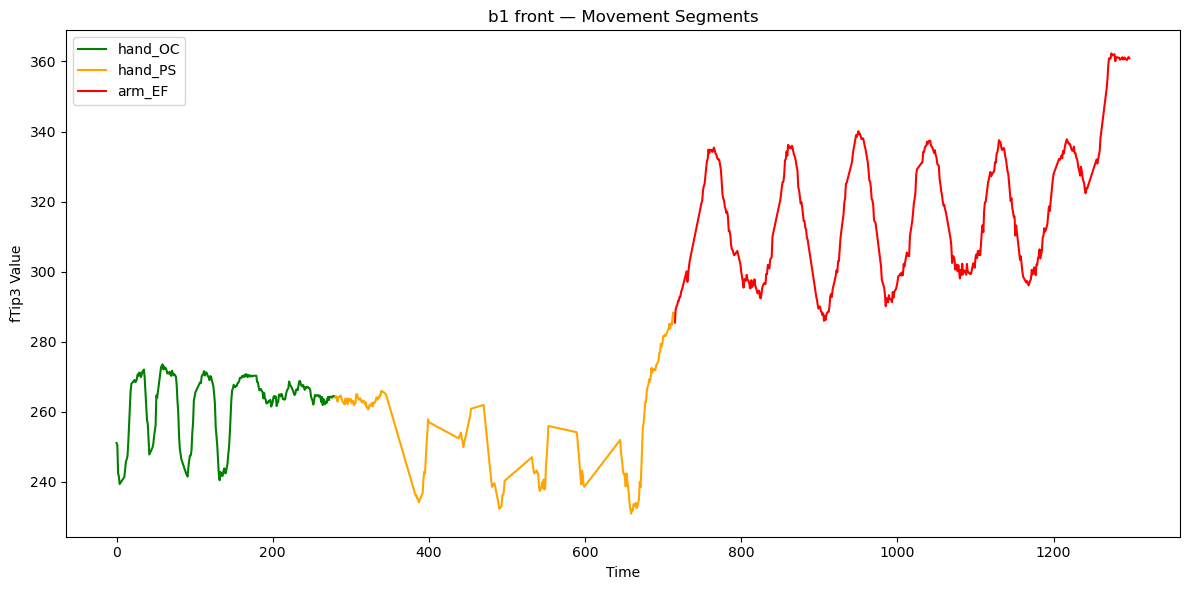

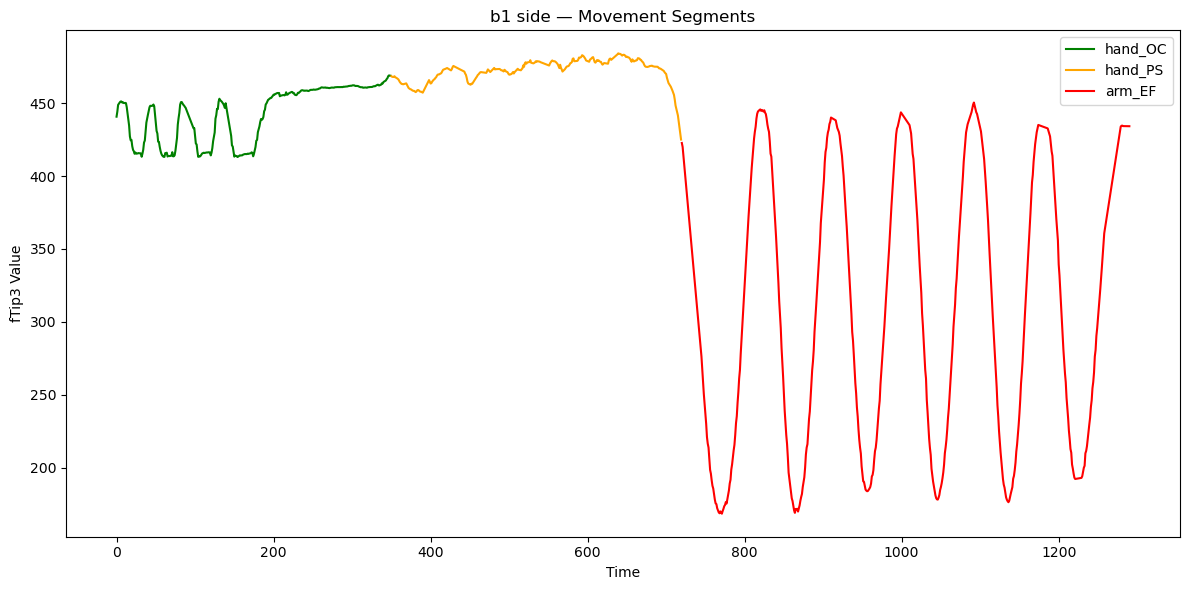

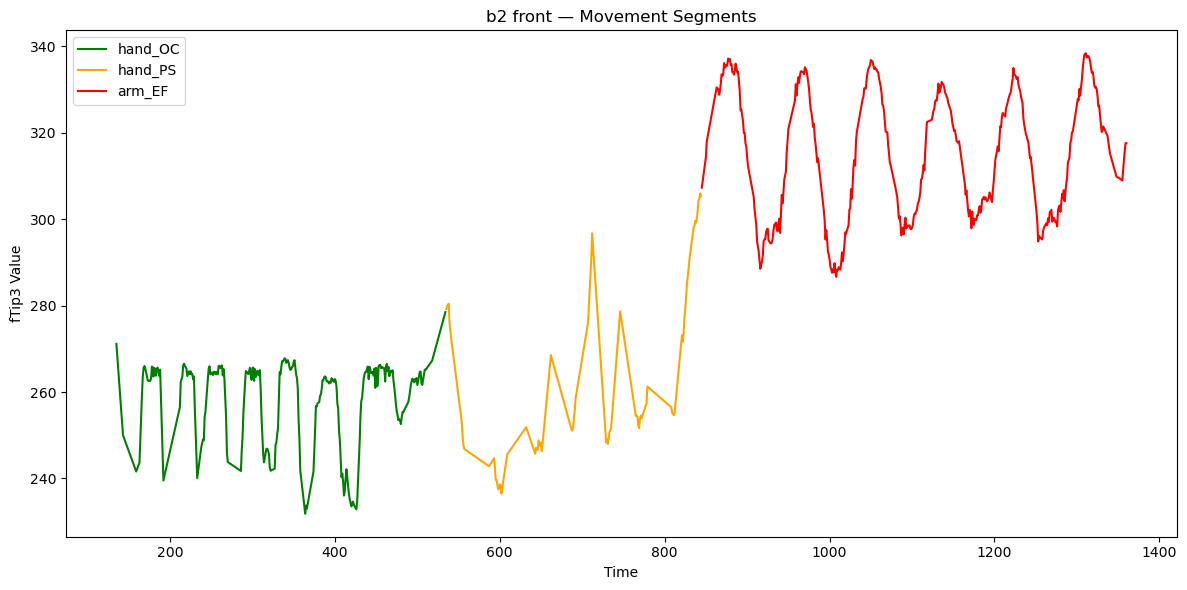

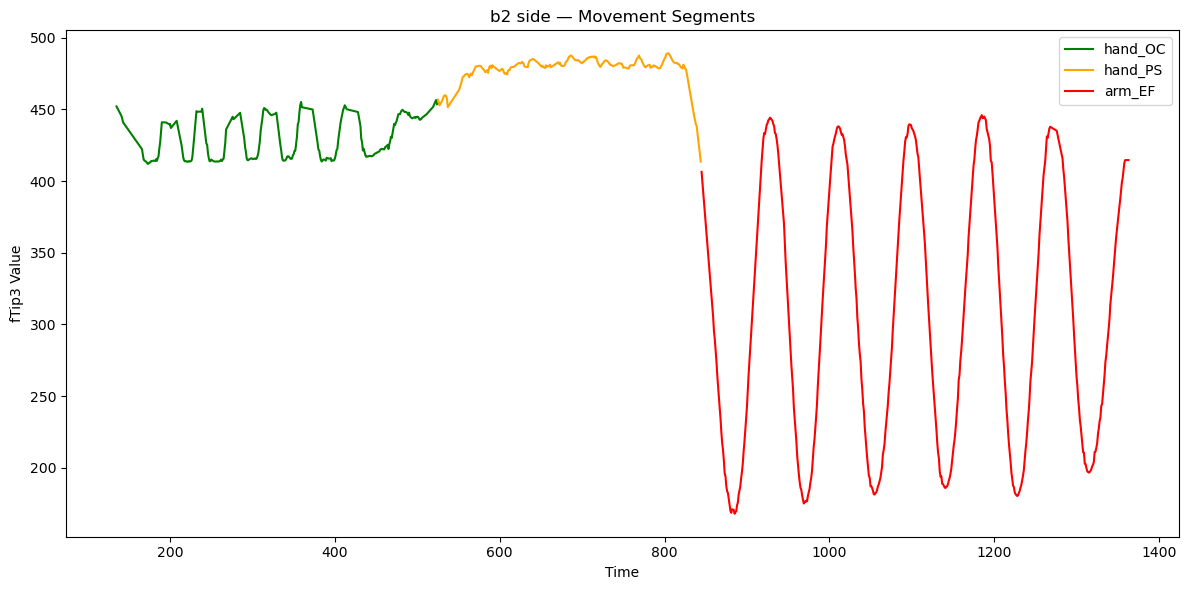

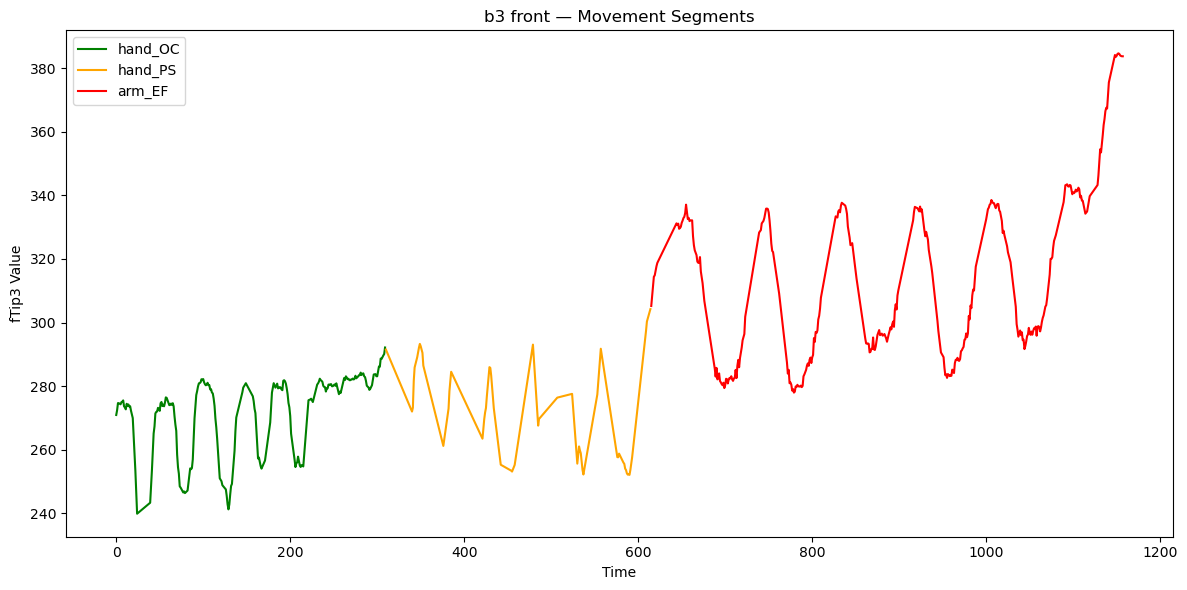

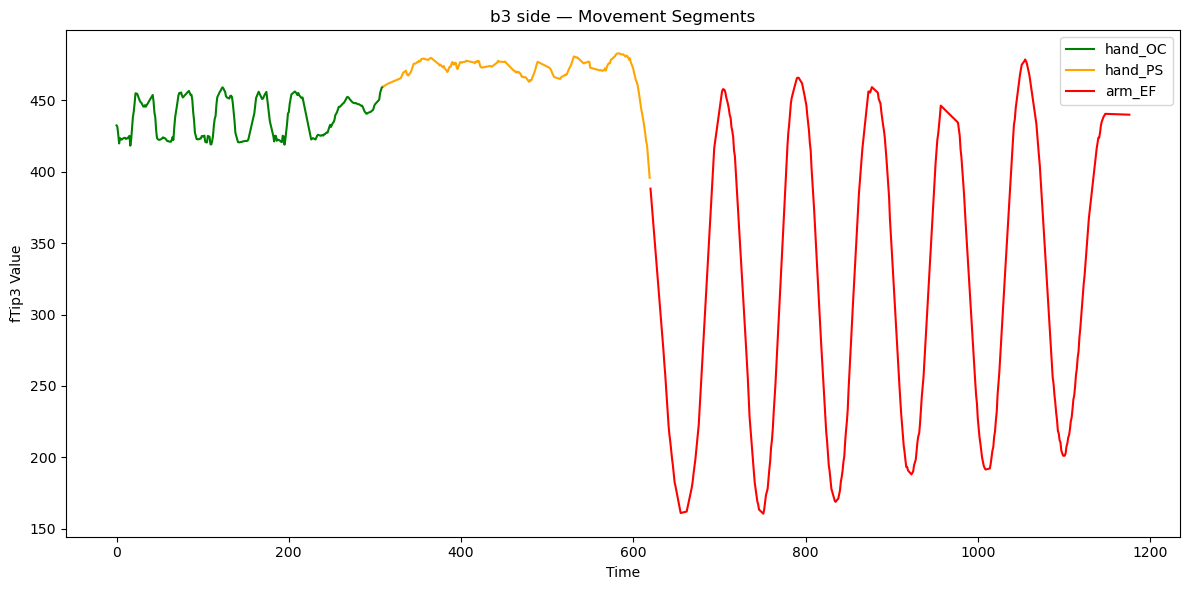

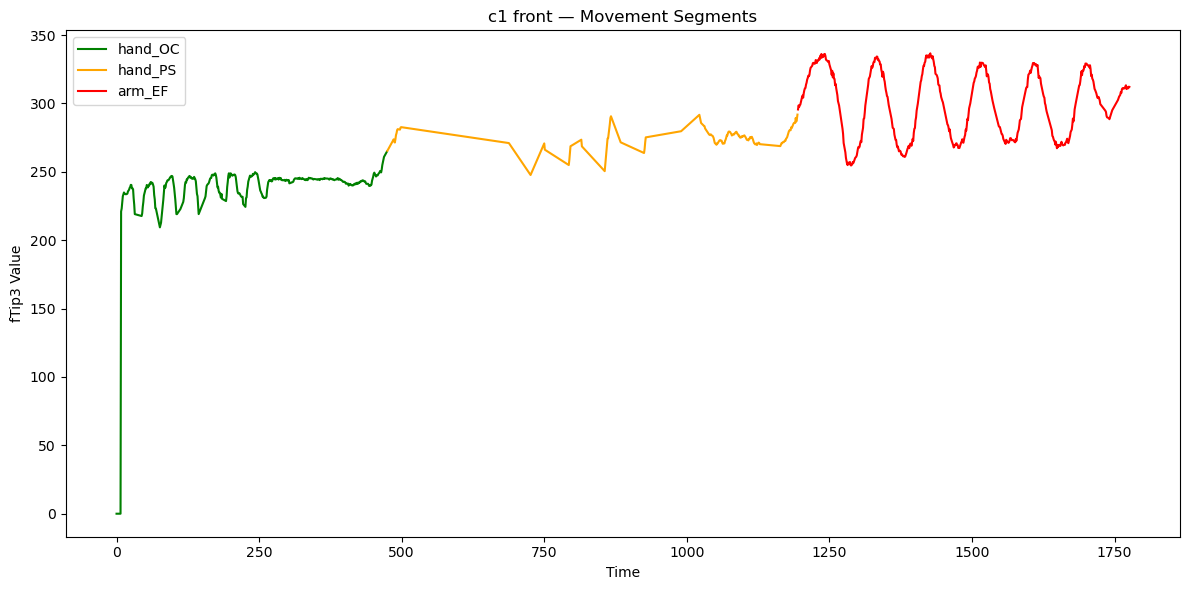

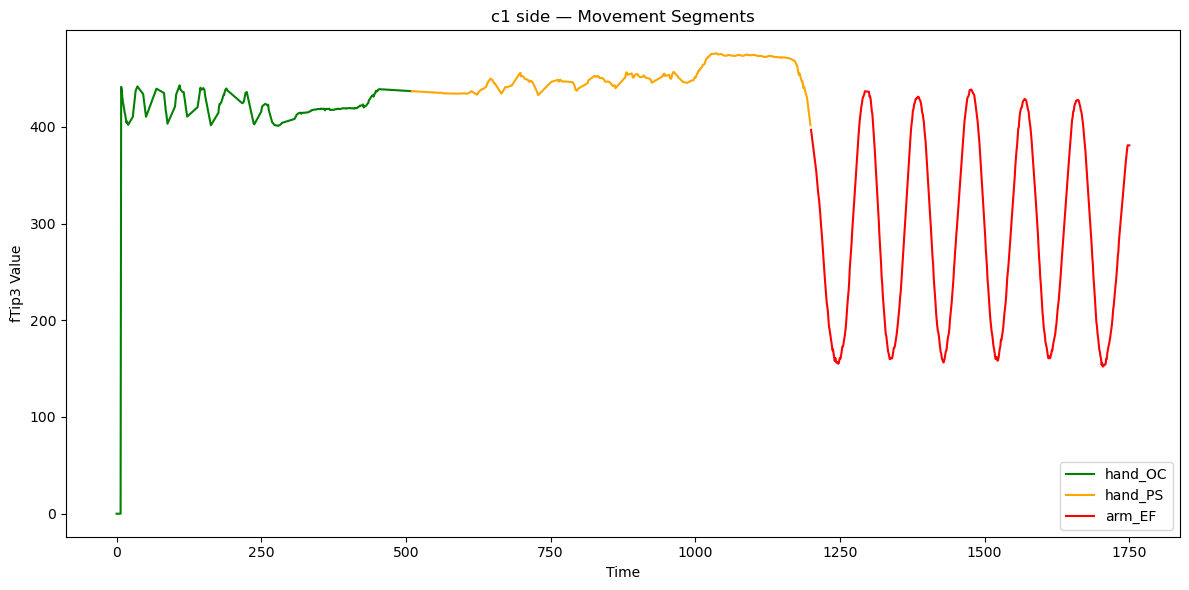

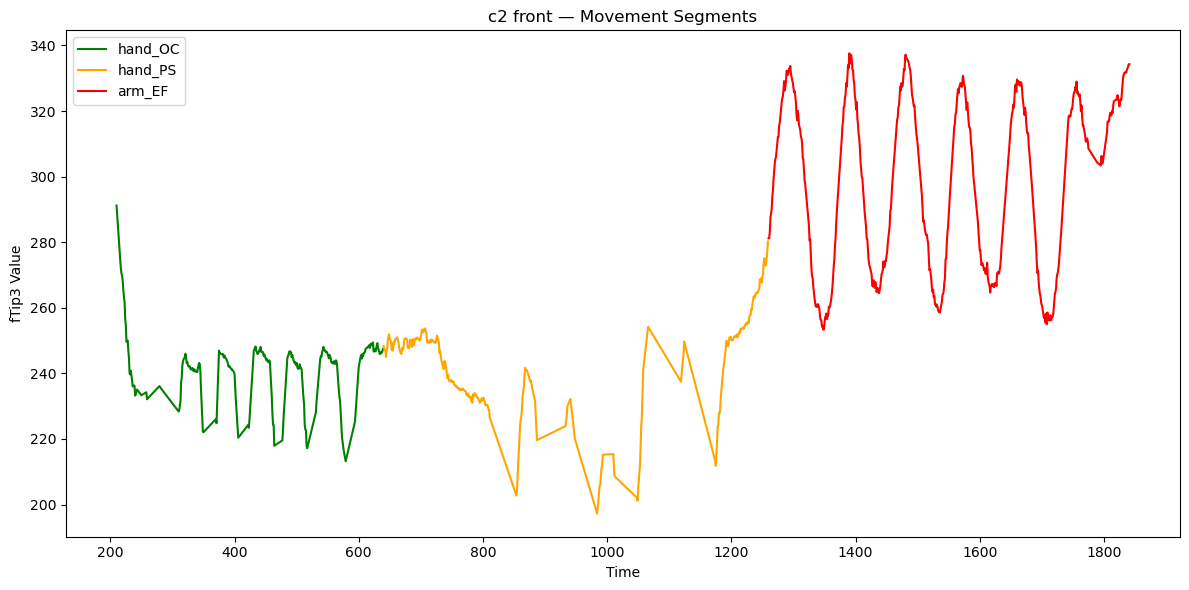

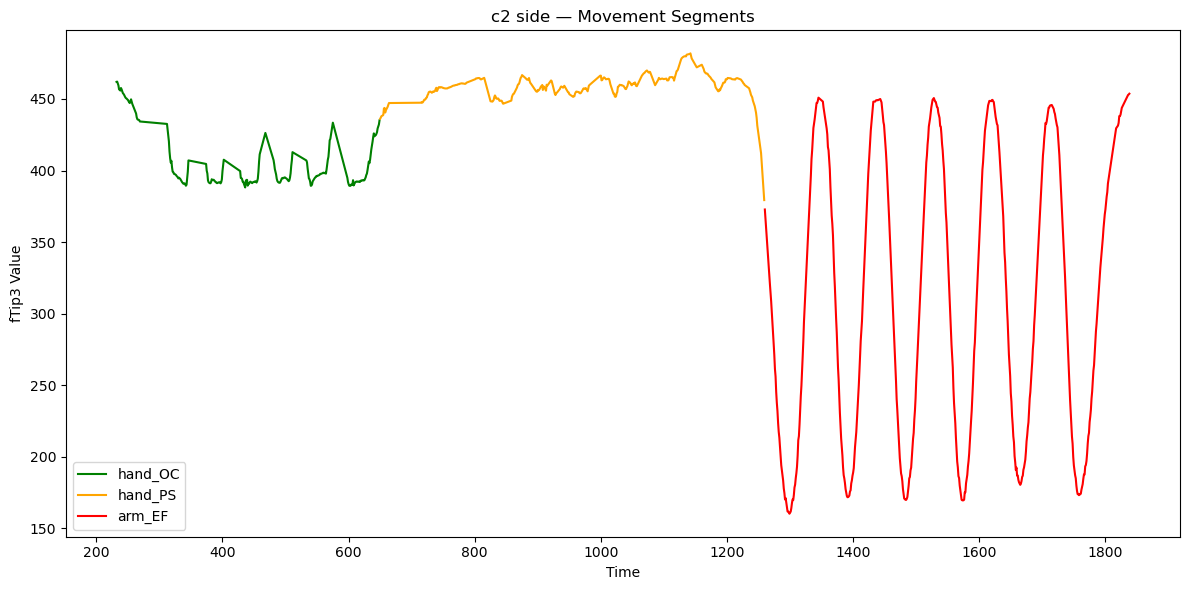

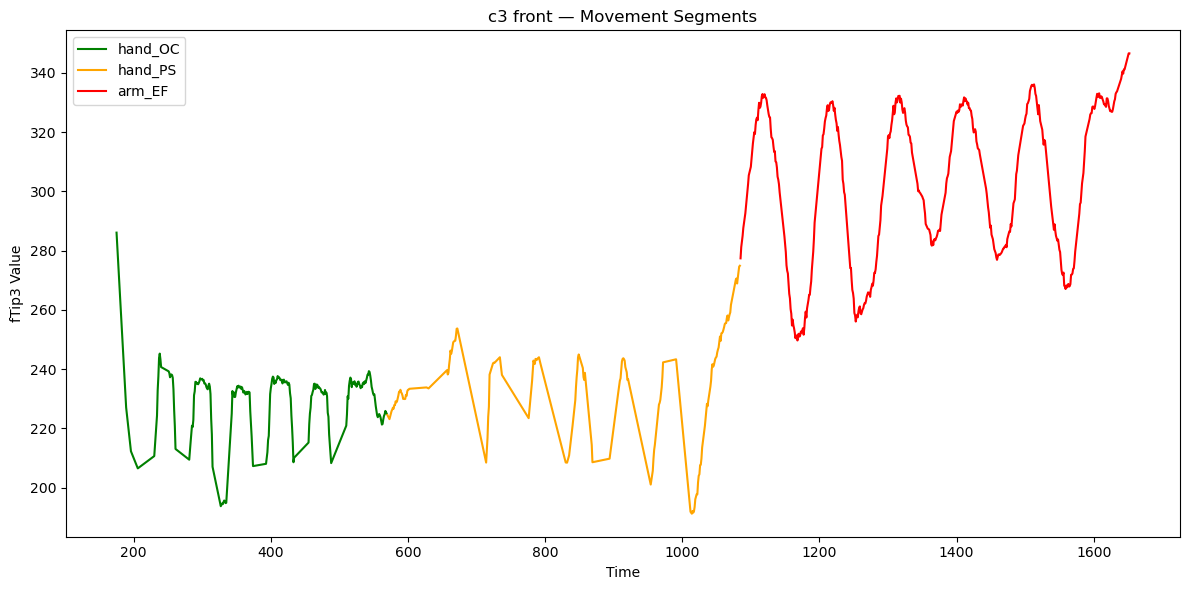

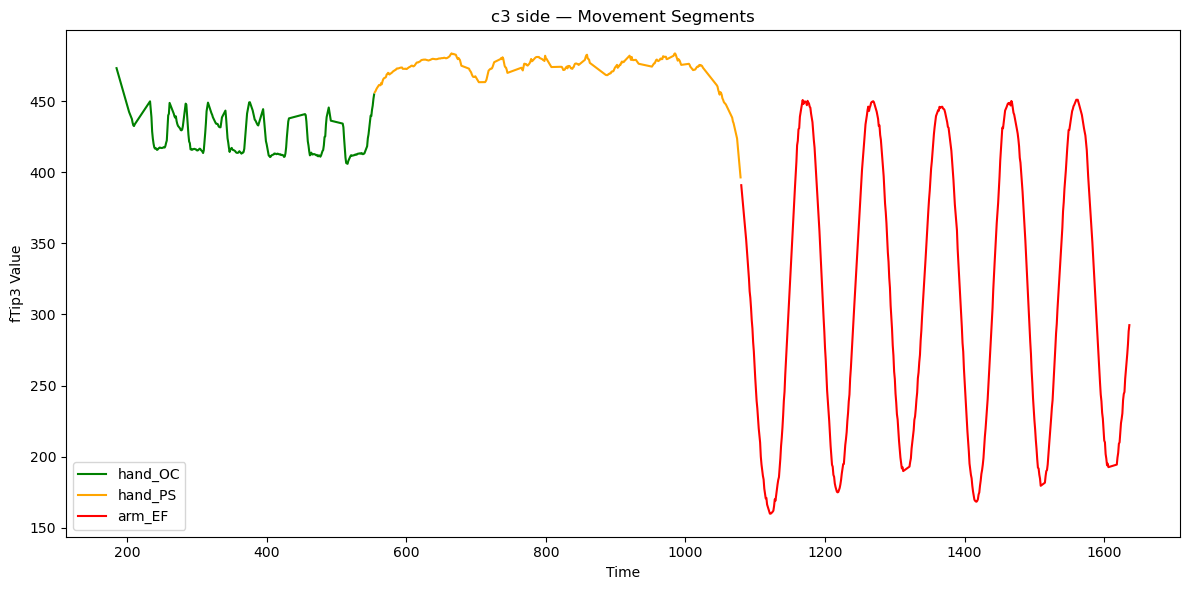

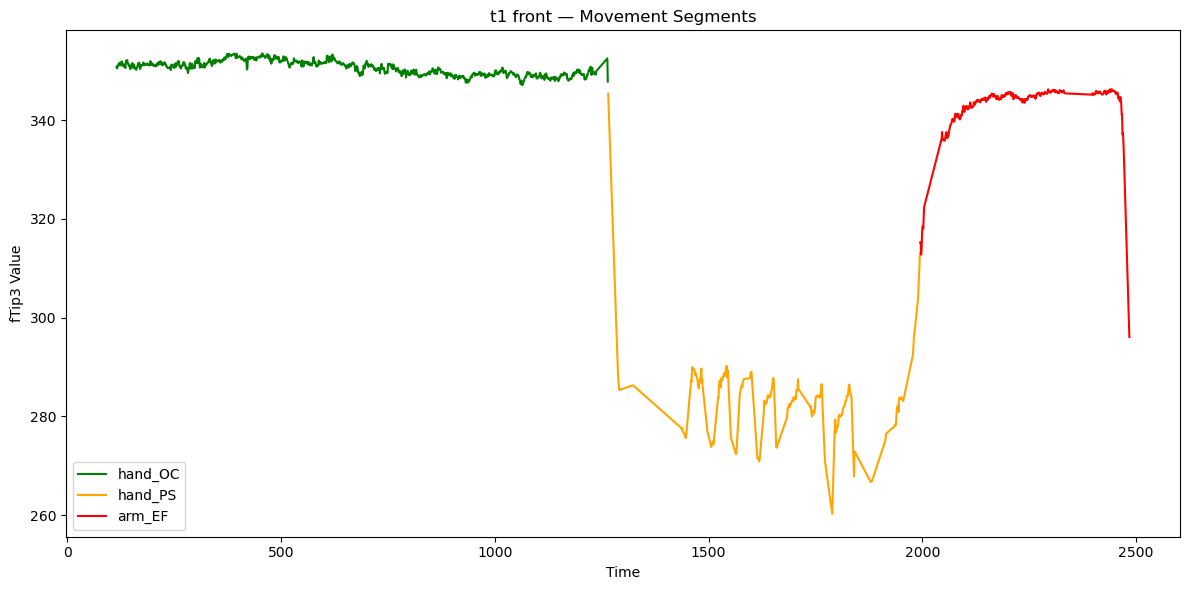

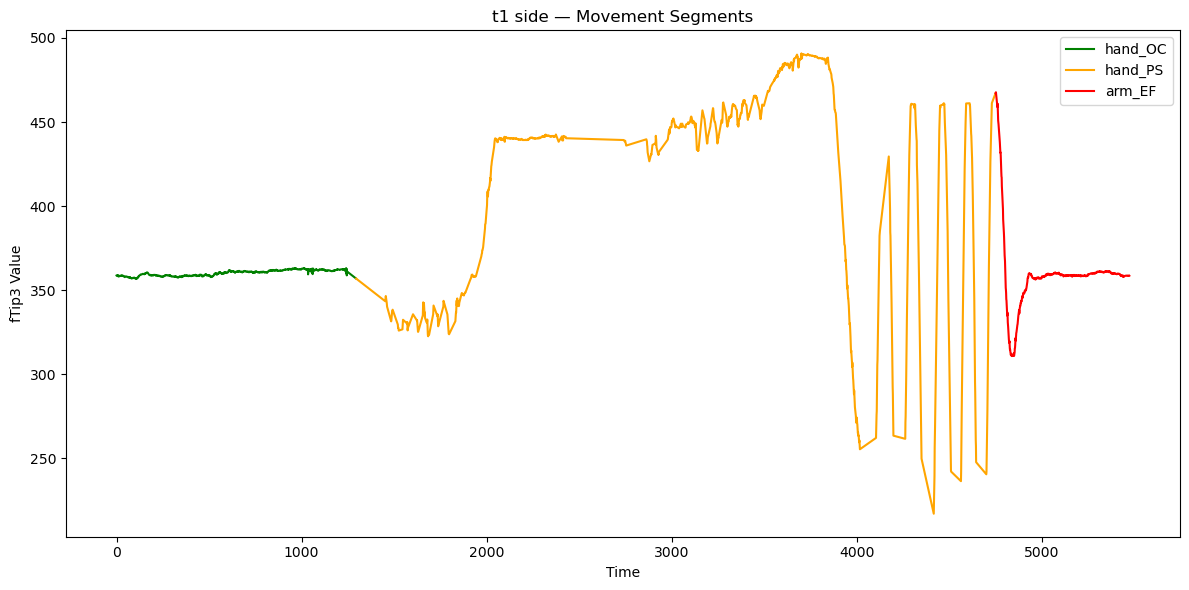

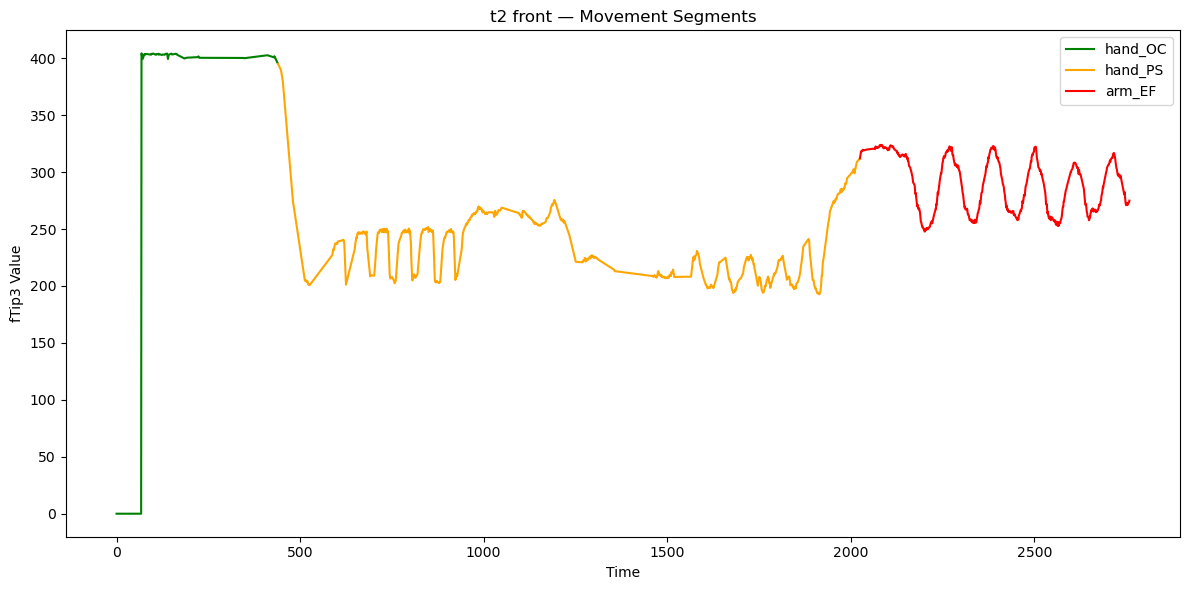

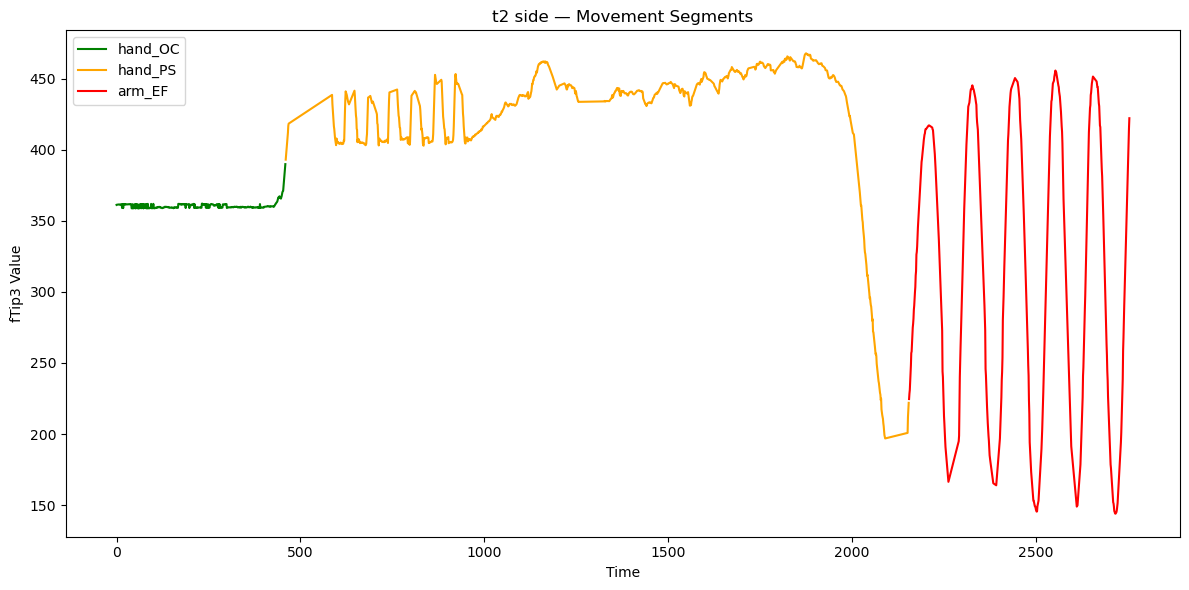

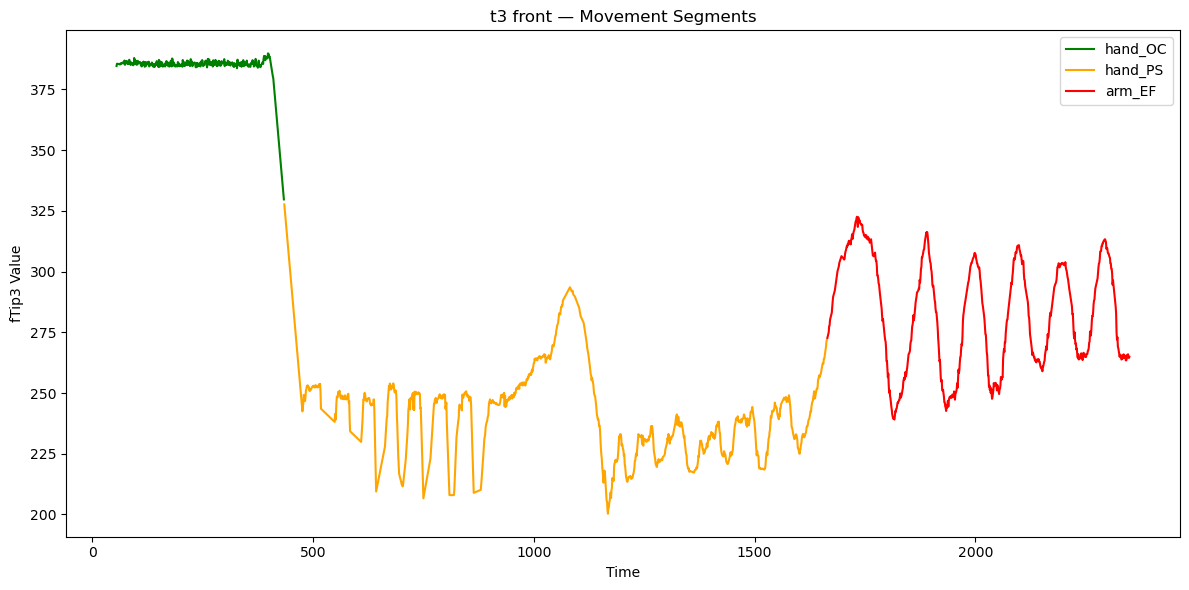

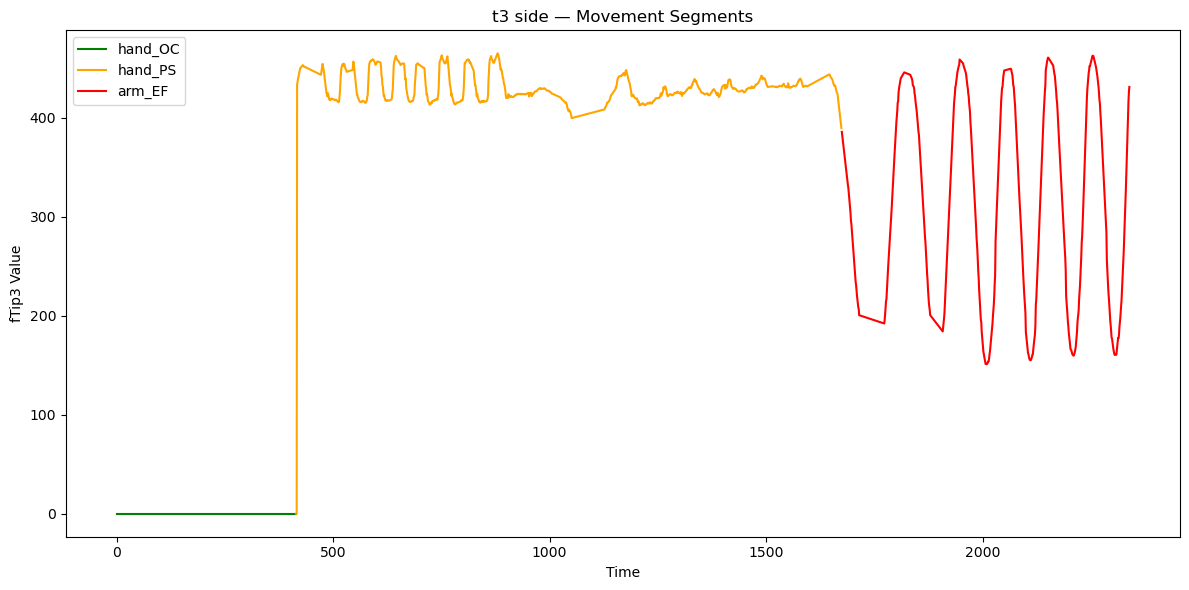

In [389]:
import matplotlib.pyplot as plt

# Example colors for the movements
movement_colors = {
    'hand_OC': 'green',
    'hand_PS': 'orange',
    'arm_EF': 'red'
}

for idx, row in df_movements.iterrows():
    dataset = row['dataset']
    view = row['view']

    # Build dataframe key like before (e.g., 'b1f' for b1 front)
    df_key = dataset + ('f' if view == 'front' else 's')

    if df_key not in dataframes:
        print(f"Skipping {df_key} — data not found.")
        continue

    df = dataframes[df_key]
    
    # Extract x and t data
    x = df[top_feature_pc1].to_numpy()
    t = np.arange(len(x))

    # Get segment indices
    armEF_start, armEF_end = row['arm_EF']
    handOC_start, handOC_end = row['hand_OC']
    handPS_start, handPS_end = row['hand_PS']

    plt.figure(figsize=(12, 6))
    
    # Plot hand_OC segment
    plt.plot(t[handOC_start:handOC_end], x[handOC_start:handOC_end],
             color=movement_colors['hand_OC'], label='hand_OC')

    # Plot hand_PS segment
    plt.plot(t[handPS_start:handPS_end], x[handPS_start:handPS_end],
             color=movement_colors['hand_PS'], label='hand_PS')

    # Plot arm_EF segment
    plt.plot(t[armEF_start:armEF_end], x[armEF_start:armEF_end],
             color=movement_colors['arm_EF'], label='arm_EF')

    plt.title(f"{dataset} {view} — Movement Segments")
    plt.xlabel("Time")
    plt.ylabel(f"{top_feature_pc1} Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


## NOT WORKING YET!!!!!

## Getting peaks and troughs

In [390]:
# Apply and create new columns
df_movements[['peaks', 'troughs', 'euclidean_dis']] = df_movements.apply(compute_peaks_troughs, axis=1)
df_movements

Error processing row 0: 'movement'
Error processing row 1: 'movement'
Error processing row 2: 'movement'
Error processing row 3: 'movement'
Error processing row 4: 'movement'
Error processing row 5: 'movement'
Error processing row 6: 'movement'
Error processing row 7: 'movement'
Error processing row 8: 'movement'
Error processing row 9: 'movement'
Error processing row 10: 'movement'
Error processing row 11: 'movement'
Error processing row 12: 'movement'
Error processing row 13: 'movement'
Error processing row 14: 'movement'
Error processing row 15: 'movement'
Error processing row 16: 'movement'
Error processing row 17: 'movement'


dataset   view        arm_EF      hand_OC       hand_PS peaks troughs  \
0       b1  front   (715, 1298)     (0, 280)    (280, 715)  None    None   
1       b1   side   (720, 1291)     (0, 350)    (350, 720)  None    None   
2       b2  front   (845, 1361)   (135, 535)    (535, 845)  None    None   
3       b2   side   (845, 1364)   (135, 525)    (525, 845)  None    None   
4       b3  front   (615, 1158)     (0, 310)    (310, 615)  None    None   
5       b3   side   (620, 1177)     (0, 310)    (310, 620)  None    None   
6       c1  front  (1195, 1777)     (0, 475)   (475, 1195)  None    None   
7       c1   side  (1200, 1751)     (0, 510)   (510, 1200)  None    None   
8       c2  front  (1260, 1842)   (210, 640)   (640, 1260)  None    None   
9       c2   side  (1260, 1839)   (232, 650)   (650, 1260)  None    None   
10      c3  front  (1085, 1653)   (175, 570)   (570, 1085)  None    None   
11      c3   side  (1080, 1637)   (185, 555)   (555, 1080)  None    None   
12      t1  front  (1995, 2485)  (115, 1265)  (1265, 1995)  None    None   
13      t1   side  (4750, 5474)    (0, 1295)  (1295, 4750)  None    None   
14      t2  front  (2025, 2760)     (0, 440)   (440, 2025)  None    None   
15      t2   side  (2155, 2755)     (0, 460)   (460, 2155)  None    None   
16      t3  front  (1665, 2350)    (55, 435)   (435, 1665)  None    None   
17      t3   side  (1675, 2340)     (0, 415)   (415, 1675)  None    None   

   euclidean_dis  
0           None  
1           None  
2           None  
3           None  
4           None  
5           None  
6           None  
7           None  
8           None  
9           None  
10          None  
11          None  
12          None  
13          None  
14          None  
15          None  
16          None  
17          None

## Viewing peaks and troughs

KeyError: 'peaks'

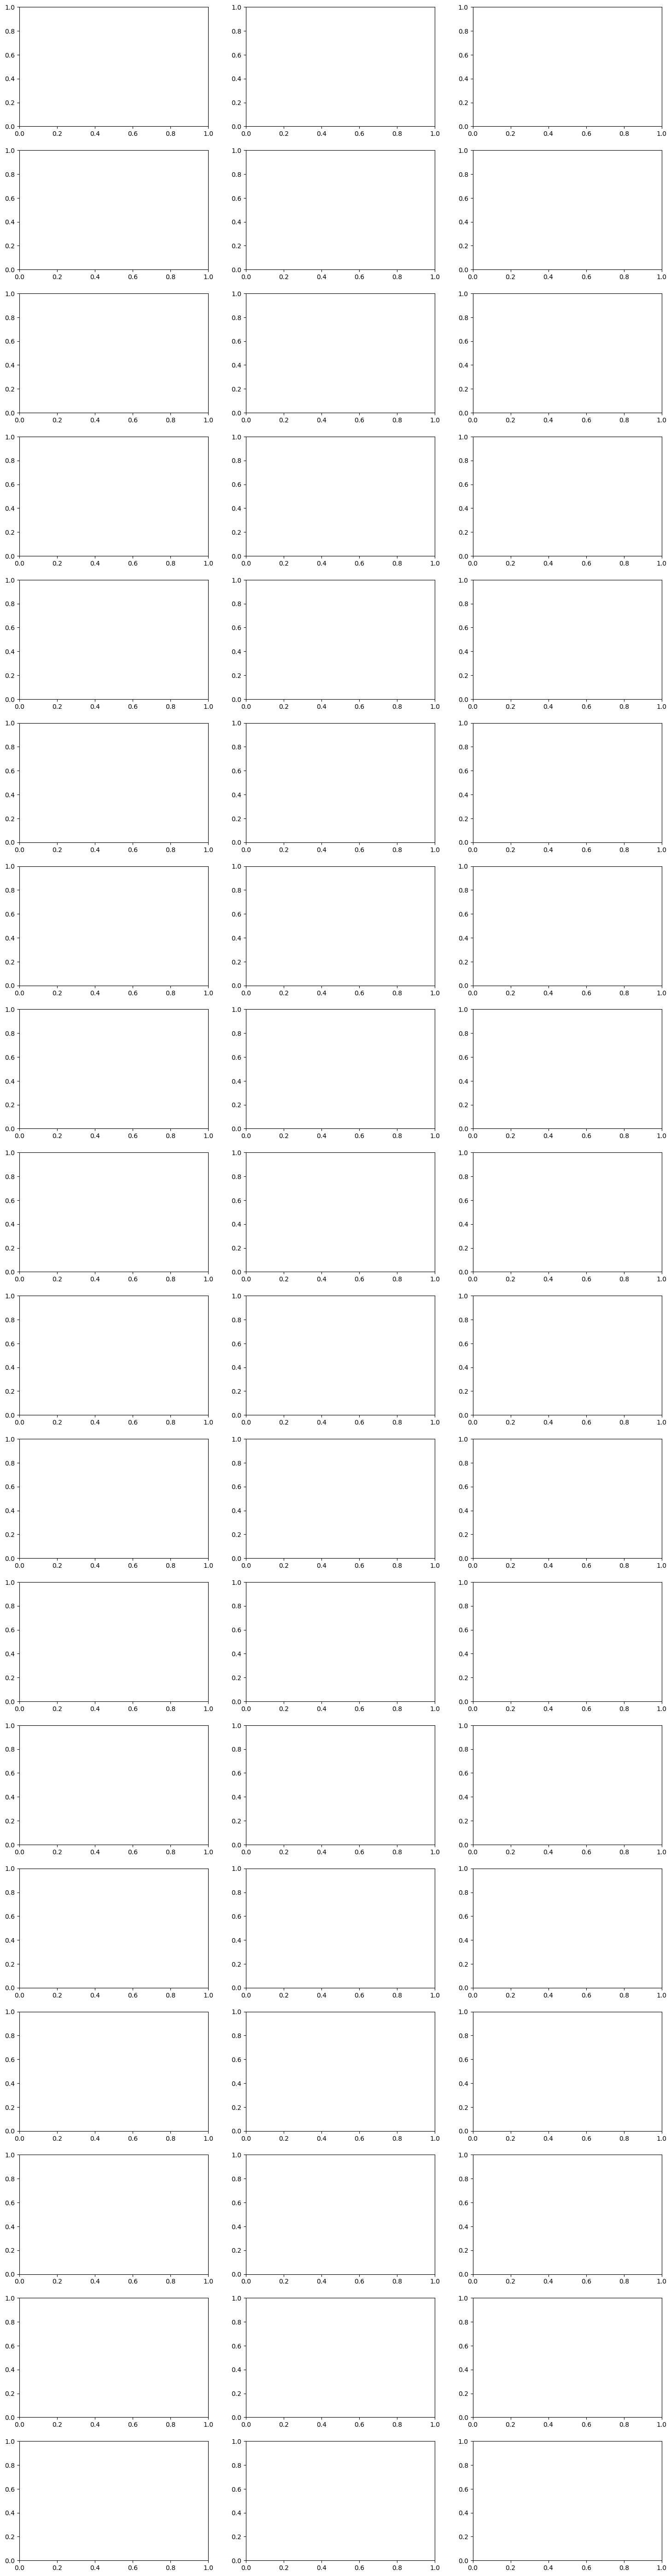

In [375]:
# Filter rows where 'peaks' is not None
# valid_rows = df_movements[df_movements['peaks'].notna()].reset_index()

num_plots = len(df_movements)
cols = 3
rows = (num_plots + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()


for i, (idx, row) in enumerate(df_movements.iterrows()):
    ax = axes[i]

    if row['peaks'] is None:
        fig.delaxes(ax)
        continue


    if row['movement'] == 'hand_OC':
        data = row['euclidean_dis']
    else:
        data = row['data']
    
    # Plot time vs data
    ax.plot(row['time'], data, label='Signal', color='black')

    # Plot peaks (if any)
    if isinstance(row['peaks'], (np.ndarray, list)):
        ax.plot(row['peaks'], np.interp(row['peaks'], row['time'], data), 'ro', label='Peaks')

    # Plot troughs (if any)
    if isinstance(row['troughs'], (np.ndarray, list)):
        ax.plot(row['troughs'], np.interp(row['troughs'], row['time'], data), 'bo', label='Troughs')

    # Add titles and labels
    ax.set_title(f"{row['dataset']} - {row['movement']}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
